## File Preparation

### 1) Test & Create Required Functions To Process Files

#### Load Required Modules

In [1]:
import os
from os import listdir
from os.path import isfile, join, isdir
import cv2
import math
import numpy as np
import pandas as pd
import dlib
import imutils
import json
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets
from IPython.display import display
import csv

#### Variable Initialization

In [2]:
tfolders = ['./ttrainval','./ttest']
nfolders = ['./ntrainval','./ntest']

In [3]:
tfolders = ['./ttrainval','./ttest']
nfolders = ['./xtrainval','./xtest']
#imgDir = './ttrainval/0bop3D7SdDM/50001/'
#imgDir = './ttrainval/LSdPxGLesE4/50002/'
#imgDir = './ttrainval/rbnBeSvXGQM/50001/'

#imgDir = './ttrainval/rbnBeSvXGQM/50008/
#imgDir = './ttrainval/rbnBeSvXGQM/50009/
imgDir = './ttrainval/rbnBeSvXGQM/50007/'

#### Directory and File Utilities

In [4]:
def getSubDirs(dirpath):
    files = [f for f in listdir(dirpath) if not f.startswith('.') and isdir(join(dirpath,f))]
    return files

len(getSubDirs('./ttrainval'))

4004

In [5]:
def getJPGFiles(dirpath):
    files = [f.replace('.jpg','') for f in listdir(dirpath) if not f.startswith('.') and f.endswith('.jpg') and isfile(join(dirpath,f))]
    return files

len(getJPGFiles(imgDir))

30

#### Frame Processor

In [6]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('./shape_predictor_68_face_landmarks.dat')

def getLipCoordsForFile(filepath):
    frame = cv2.cvtColor(cv2.imread(filepath), cv2.COLOR_BGR2GRAY)
    faces_loc = detector(frame, 0)
    if (len(faces_loc) > 0):
        face_loc = faces_loc[0]
        shape = predictor(frame, face_loc)
        print
        if type(shape) != dlib.full_object_detection:
            #print('No Points')
            return True, False, None
    else: 
        shape = predictor(frame, dlib.rectangle(0, 0, frame.shape[0]-1, frame.shape[1]-1))
        if type(shape) != dlib.full_object_detection:
            #print('No Face and Points')
            return False, False, None
    
    pts = dlibShapeToPoints(shape)
    if len(pts) != 68:
        #print('Less Points Than Needed')
        return True, pts, None
    
    mpts = np.vstack((
        pts[51], #lip_top
        pts[62], #mouth_top
        pts[57], #lip_bottom
        pts[66], #mouth_bottom
        pts[48], #lip_left 
        pts[60], #mouth_left 
        pts[54], #lip_right 
        pts[64] #mouth_right
    ))
    
    #mar = abs(safeDiv((mpts[3, 0] - mpts[1, 0]), (mpts[7, 1] - mpts[5, 1])))
    #lar = abs(safeDiv((mpts[2, 0] - mpts[0, 0]), (mpts[6, 1] - mpts[4, 1])))
    #print((mpts[0, 0] <= mpts[1, 0], mpts[2, 0] <= mpts[3, 0], mpts[4, 1] >= mpts[5, 1], mpts[6, 1] >= mpts[7, 1], mar, lar))
    #print(json.dumps(mpts.tolist()))
    
    verify = (mpts[0, 0] <= mpts[1, 0], mpts[2, 0] <= mpts[3, 0], mpts[4, 1] >= mpts[5, 1], mpts[6, 1] >= mpts[7, 1])
    #print(sum(verify))
    wh = np.array(frame.shape)
    
    return mpts, wh, verify

def safeDiv(x, y): 
    if y == 0: 
        return 0
    return x / y

def getLipCoordsAggregates(mpts, wh):
    mins = np.amin(mpts, axis=0)
    maxs = np.amax(mpts, axis=0)
    #xmin, xmax, width, ymin, ymax, height
    return np.vstack((mins, maxs, wh)).flatten('F')

def dlibShapeToPoints(shape, dtype=np.int32):
    points = np.zeros((68, 2), dtype=dtype)

    for j in range(0, 68):
        points[j] = (shape.part(j).x,shape.part(j).y)

    return points

mpts, wh, verify = getLipCoordsForFile(imgDir+'0.jpg')
getLipCoordsAggregates(mpts, wh)

array([ 61, 111, 224,  98, 117, 224])

#### Frames Processor

In [7]:
def getLipCoordsForAllFiles(dirpath):
    cols = ['filename', 'filenum', 'xmin', 'xmax', 'xdiff', 'xavg', 'xtmin', 'xtmax', 'width', 'ymin', 'ymax', 'ydiff', 'yavg', 'ytmin', 'ytmax', 'height', 'error', 'error_noface', 'error_nopts', 'error_lesspts', 'error_verifypts', 'error_bounds', 'pts']
    filenames = getJPGFiles(dirpath)
    df = pd.DataFrame(index=list(range(0,len(filenames))), columns=cols)
    df = df.fillna(0)
    df.filename = df.filename.astype(str)
    df.filenum = df.filenum.astype(int)
    df.error = df.error.astype(int)
    df.error = 0
    df.error_noface = df.error_noface.astype(int)
    df.error_noface = 0
    df.error_nopts = df.error_nopts.astype(int)
    df.error_nopts = 0
    df.error_lesspts = df.error_lesspts.astype(int)
    df.error_lesspts = 0
    df.pts = df.pts.astype(str)
    df.pts = ''
    for f in filenames:
        filename = f + '.jpg'
        filepath = join(dirpath, filename)
        #print(filepath)
        if not os.path.exists(filepath):
            df.at[f, 'error'] = 1
        else:
            pts, wh, verify = getLipCoordsForFile(filepath)
            f = int(f)
            if type(pts) == bool:
                df.at[f, 'error'] = 1
                if type(pts) == False:
                    df.at[f, 'error_noface'] = 1
                if type(wh) == bool and wh == False:
                    df.at[f, 'error_nopts'] = 1
                if type(wh) == int:
                    df.at[f, 'error_lesspts'] = 1
            else:
                if sum(verify) < 4:
                    df.at[f, 'error_verifypts'] = 1
                coords = getLipCoordsAggregates(pts, wh)
                #print(coords)
                df.at[f, 'filename'] = filename
                df.at[f, 'filenum'] = f 
                df.at[f, 'xmin'] = df.at[f, 'xtmin'] = coords[0]
                df.at[f, 'xmax'] = df.at[f, 'xtmax'] = coords[1]
                df.at[f, 'xdiff'] = coords[1] - coords[0]
                df.at[f, 'xavg'] = (coords[1] + coords[0])/2
                df.at[f, 'width'] = coords[2]
                df.at[f, 'ymin'] = df.at[f, 'ytmin'] = coords[3]
                df.at[f, 'ymax'] = df.at[f, 'ytmax'] = coords[4]
                df.at[f, 'ydiff'] = coords[4] - coords[3]
                df.at[f, 'yavg'] = (coords[4] + coords[3])/2
                df.at[f, 'height'] = coords[5]
                df.at[f, 'error'] = 0
                #else:
                #    df.at[f, 'error'] = 1
                #    df.at[f, 'error_verifypts'] = 1
                    
                df.at[f, 'pts'] = json.dumps(pts.tolist())
                
    return df.sort_values(by=['filenum'])

dfa = getLipCoordsForAllFiles(imgDir)
dfa.tail(85).head(20)

,filename,filenum,xmin,xmax,xdiff,xavg,xtmin,xtmax,width,ymin,...,ytmin,ytmax,height,error,error_noface,error_nopts,error_lesspts,error_verifypts,error_bounds,pts
0,0.jpg,0,61,111,50,86,61,111,224,98,...,98,117,224,0,0,0,0,0,0,"[[78, 98], [79, 104], [80, 113], [80, 106], [6..."
1,1.jpg,1,60,111,51,85,60,111,224,100,...,100,120,224,0,0,0,0,0,0,"[[79, 100], [80, 107], [80, 118], [80, 111], [..."
2,2.jpg,2,60,112,52,86,60,112,224,99,...,99,119,224,0,0,0,0,0,0,"[[80, 99], [80, 105], [82, 119], [82, 112], [6..."
3,3.jpg,3,65,114,49,89,65,114,224,99,...,99,119,224,0,0,0,0,1,0,"[[83, 99], [83, 105], [85, 119], [84, 114], [6..."
4,4.jpg,4,67,138,71,102,67,138,224,132,...,132,161,224,0,0,0,0,1,0,"[[98, 132], [100, 143], [106, 161], [103, 146]..."
5,5.jpg,5,70,118,48,94,70,118,224,95,...,95,119,224,0,0,0,0,0,0,"[[90, 95], [91, 102], [92, 119], [92, 110], [7..."
6,6.jpg,6,76,123,47,99,76,123,224,93,...,93,116,224,0,0,0,0,0,0,"[[98, 93], [98, 100], [99, 116], [99, 108], [7..."
7,7.jpg,7,77,127,50,102,77,127,224,92,...,92,112,224,0,0,0,0,0,0,"[[100, 92], [100, 99], [101, 110], [101, 102],..."
8,8.jpg,8,74,126,52,100,74,126,224,92,...,92,109,224,0,0,0,0,0,0,"[[97, 92], [97, 99], [98, 109], [98, 102], [74..."
9,9.jpg,9,73,125,52,99,73,125,224,92,...,92,109,224,0,0,0,0,0,0,"[[97, 92], [97, 99], [97, 109], [97, 102], [73..."


In [8]:
def proportionalDiff(x, y):
    mn = min(x, y)
    mx = max(x, y)
    #print("\t%s\t%s\t%.3f" % (mn, mx, safeDiv(mx - mn, mx)*math.log(mn)))
    return safeDiv(mx - mn, mx)*math.log(mn)

def verifyAndCorrectErrors(df):
    #print("\t# Errors:\t%s, %s" % (dfa[['error']].sum(axis=0).error, dfa[['error_verifypts']].sum(axis=0).error_verifypts))
    #print("===========================")  
    
    notverify = df.loc[df['error_verifypts'] == 0]["filenum"]
    for nv in notverify:
        if (nv == 0):
            pverified = True
        else:
            pverified = df.loc[nv - 1, 'error_verifypts'] == 0
            
        if (nv < 2):
            ppverified = True
        else:
            ppverified = df.loc[nv - 2, 'error_verifypts'] == 0
            
        if (nv == df.shape[0] - 1):
            nverified = True
        else:
            nverified = df.loc[nv + 1, 'error_verifypts'] == 0
        
        if (nv >= df.shape[0] - 2):
            nnverified = True
        else:
            nnverified = df.loc[nv + 2, 'error_verifypts'] == 0
            
        vs = sum((ppverified, pverified, nverified, nnverified))
        
        if vs < 2:
            #print("%s: %s, %s %s, %s = %s" % (nv, ppverified, pverified, nverified, nnverified, vs))
            df.at[nv, 'error_verifypts'] = 1
            
    #print("===========================")
    #print("\t# Errors:\t%s, %s" % (dfa[['error']].sum(axis=0).error, dfa[['error_verifypts']].sum(axis=0).error_verifypts))
    #print("===========================")  
    
    verify = df.loc[df['error_verifypts'] == 1]["filenum"]
    for v in verify:
        if (v == 0):
            pverified = False
        else:
            pverified = df.loc[v - 1, 'error_verifypts'] == 0
            
        if (v == df.shape[0] - 1):
            nverified = False
        else:
            nverified = df.loc[v + 1, 'error_verifypts'] == 0
            
        #print("%s: %s, %s" % (v, pverified, nverified))
        if not pverified and not nverified:
            df.at[v, 'error'] = 1
    
    #print("===========================")
    #print("\t# Errors:\t%s, %s" % (dfa[['error']].sum(axis=0).error, dfa[['error_verifypts']].sum(axis=0).error_verifypts))
    #print("===========================")  
    
    stillverify = df.loc[(df['error_verifypts'] == 1) & (df['error'] == 0)]["filenum"]
    for s in stillverify:
        #print(s)
        if (s == 0):
            prevn = df.loc[s + 1]
        else:
            prevn = df.loc[s - 1]
        if (s == df.shape[0] - 1):    
            nextn = df.loc[s - 1]
        else:  
            nextn = df.loc[s + 1]
        currn = df.loc[s]
        if (not (
                (
                    (
                        (prevn.error == 0) & 
                        (proportionalDiff(prevn.xdiff, currn.xdiff) < 1) &
                        (proportionalDiff(prevn.xavg, currn.xavg) < 1) &
                        (proportionalDiff(prevn.ydiff, currn.ydiff) < 1) &
                        (proportionalDiff(prevn.yavg, currn.yavg) < 1)
                    ) | (
                        (prevn.error == 1) & 
                        (proportionalDiff(prevn.xdiff, currn.xdiff) >= 1) &
                        (proportionalDiff(prevn.xavg, currn.xavg) >= 1) &
                        (proportionalDiff(prevn.ydiff, currn.ydiff) >= 1) &
                        (proportionalDiff(prevn.yavg, currn.yavg) >= 1)
                    )
                ) & (
                    (
                        (nextn.error == 0) & 
                        (proportionalDiff(nextn.xdiff, currn.xdiff) < 1) &
                        (proportionalDiff(nextn.xavg, currn.xavg) < 1) &
                        (proportionalDiff(nextn.ydiff, currn.ydiff) < 1) &
                        (proportionalDiff(nextn.yavg, currn.yavg) < 1)
                    ) | (
                        (nextn.error == 1) & 
                        (proportionalDiff(nextn.xdiff, currn.xdiff) >= 1) &
                        (proportionalDiff(nextn.xavg, currn.xavg) >= 1) &
                        (proportionalDiff(nextn.ydiff, currn.ydiff) >= 1) &
                        (proportionalDiff(nextn.yavg, currn.yavg) >= 1)
                    )
                )
        )):
            df.at[s, 'error'] = 1
            #print("\tERROR !!!!!")
        else:
            df.at[s, 'error_verifypts'] = 0
            #print("\tnot")
    
    stillerror = df.loc[df['error'] == 1]["filenum"]
    noterror = df.loc[df['error'] == 0]["filenum"]

    #print("===========================") 
    #print("\t# Errors:\t%s, %s" % (dfa[['error']].sum(axis=0).error, dfa[['error_verifypts']].sum(axis=0).error_verifypts))
    #print("===========================") 
    
    if (len(noterror)):
        for s in stillerror:
            closestgood = min(noterror, key=lambda x:abs(x-s))
            closestgoods = []

            if abs(closestgood - s) == 1 and s > 0 and s < df.shape[0] - 1:
                if df.loc[s + 1, 'error'] == 0:
                    closestgoods.append(s + 1)
                if df.loc[s - 1, 'error'] == 0:
                    closestgoods.append(s - 1)
            else:
                closestgoods.append(closestgood)

            #print("%s: %s" % (s, closestgoods))
            if len(closestgoods) == 1:
                c = closestgoods[0]
                df.at[s, 'xmin'] = df.at[s, 'xtmin'] = df.loc[c, 'xmin']
                df.at[s, 'xmax'] = df.at[s, 'xtmax'] = df.loc[c, 'xmax']
                df.at[s, 'xdiff'] = df.loc[c, 'xdiff']
                df.at[s, 'xavg'] = df.loc[c, 'xavg']
                df.at[s, 'ymin'] = df.at[s, 'ytmin'] = df.loc[c, 'ymin']
                df.at[s, 'ymax'] = df.at[s, 'ytmax'] = df.loc[c, 'ymax']
                df.at[s, 'ydiff'] = df.loc[c, 'ydiff']
                df.at[s, 'yavg'] = df.loc[c, 'yavg']
            else:
                p = closestgoods[0]
                n = closestgoods[1]
                df.at[s, 'xmin'] = df.at[s, 'xtmin'] = (df.loc[p, 'xmin'] + df.loc[n, 'xmin'])/2
                df.at[s, 'xmax'] = df.at[s, 'xtmax'] = (df.loc[p, 'xmax'] + df.loc[n, 'xmax'])/2
                df.at[s, 'xdiff'] = (df.loc[p, 'xdiff'] + df.loc[n, 'xdiff'])/2
                df.at[s, 'xavg'] = (df.loc[p, 'xavg'] + df.loc[n, 'xavg'])/2
                df.at[s, 'ymin'] = df.at[s, 'ytmin'] = (df.loc[p, 'ymin'] + df.loc[n, 'ymin'])/2
                df.at[s, 'ymax'] = df.at[s, 'ytmax'] = (df.loc[p, 'ymax'] + df.loc[n, 'ymax'])/2
                df.at[s, 'ydiff'] = (df.loc[p, 'ydiff'] + df.loc[n, 'ydiff'])/2
                df.at[s, 'yavg'] = (df.loc[p, 'yavg'] + df.loc[n, 'yavg'])/2

            df.at[s, 'error'] = int(0)
    
    #print("===========================") 
    #print("\t# Errors:\t%s, %s" % (dfa[['error']].sum(axis=0).error, dfa[['error_verifypts']].sum(axis=0).error_verifypts))
    
    
    #print(df.loc[df['error'] == 1])
    #print(df.loc[df['error'] == 1]["filenum"].size)
    
    return df.copy()
        
#dfa = getLipCoordsForAllFiles(imgDir)
dfb = verifyAndCorrectErrors(dfa)
dfb.tail(85).head(20)

,filename,filenum,xmin,xmax,xdiff,xavg,xtmin,xtmax,width,ymin,...,ytmin,ytmax,height,error,error_noface,error_nopts,error_lesspts,error_verifypts,error_bounds,pts
0,0.jpg,0,61,111,50,86,61,111,224,98,...,98,117,224,0,0,0,0,0,0,"[[78, 98], [79, 104], [80, 113], [80, 106], [6..."
1,1.jpg,1,60,111,51,85,60,111,224,100,...,100,120,224,0,0,0,0,0,0,"[[79, 100], [80, 107], [80, 118], [80, 111], [..."
2,2.jpg,2,60,112,52,86,60,112,224,99,...,99,119,224,0,0,0,0,0,0,"[[80, 99], [80, 105], [82, 119], [82, 112], [6..."
3,3.jpg,3,60,112,52,86,60,112,224,99,...,99,119,224,0,0,0,0,1,0,"[[83, 99], [83, 105], [85, 119], [84, 114], [6..."
4,4.jpg,4,65,115,50,90,65,115,224,97,...,97,119,224,0,0,0,0,1,0,"[[98, 132], [100, 143], [106, 161], [103, 146]..."
5,5.jpg,5,70,118,48,94,70,118,224,95,...,95,119,224,0,0,0,0,0,0,"[[90, 95], [91, 102], [92, 119], [92, 110], [7..."
6,6.jpg,6,76,123,47,99,76,123,224,93,...,93,116,224,0,0,0,0,0,0,"[[98, 93], [98, 100], [99, 116], [99, 108], [7..."
7,7.jpg,7,77,127,50,102,77,127,224,92,...,92,112,224,0,0,0,0,0,0,"[[100, 92], [100, 99], [101, 110], [101, 102],..."
8,8.jpg,8,74,126,52,100,74,126,224,92,...,92,109,224,0,0,0,0,0,0,"[[97, 92], [97, 99], [98, 109], [98, 102], [74..."
9,9.jpg,9,73,125,52,99,73,125,224,92,...,92,109,224,0,0,0,0,0,0,"[[97, 92], [97, 99], [97, 109], [97, 102], [73..."


#### Find minimum and maximums for bounding box lengths

In [9]:
def getBoundingBoxMaxLengthsFromAggregatesDataframe(dfa):
    return dfa['xdiff'].max(), dfa['ydiff'].max()

def getOptimalBoundingBoxWidthAndHeight(max_xdiff, max_ydiff):
    max_xydiff = math.ceil(np.amax([max_xdiff, max_ydiff])/ 2) * 2
    max_xydiff = math.floor(max_xydiff*1.75 / 2) * 2
    return max_xydiff

max_xdiff, max_ydiff = getBoundingBoxMaxLengthsFromAggregatesDataframe(dfa)
max_xydiff = getOptimalBoundingBoxWidthAndHeight(max_xdiff, max_ydiff)

print(str(max_xdiff) + ', ' + str(max_ydiff))
print(max_xydiff)

52, 27
90


In [10]:
def fillTotalMinAndMaxForAggregatesDataframe(dfa, max_xydiff):
    half_max_xydiff = max_xydiff / 2
    pc60_max_xydiff = max_xydiff*0.63
    pc40_max_xydiff = max_xydiff*0.37
    xavg = dfa['xavg']
    yavg = dfa['yavg']
    dfa['xtmin'] = np.floor(xavg - half_max_xydiff)
    dfa['xtmax'] = np.ceil(xavg + half_max_xydiff)
    dfa['ytmin'] = np.floor(yavg - pc40_max_xydiff)
    dfa['ytmax'] = np.ceil(yavg + pc60_max_xydiff)
    if dfa.loc[dfa.xtmin < 0]["filenum"].size > 0:
        dfa.loc[(dfa.xtmin < 0), 'error_bounds'] = 1 
        dfa.loc[(dfa.xtmin < 0), 'xtmax'] -= dfa.loc[(dfa.xtmin < 0), 'xtmin']
        dfa.loc[(dfa.xtmin < 0), 'xtmin'] -= dfa.loc[(dfa.xtmin < 0), 'xtmin']
    elif dfa.loc[dfa.xtmax > dfa.width]["filenum"].size > 0:
        dfa.loc[(dfa.xtmax > dfa.width), 'error_bounds'] = 1 
        dfa.loc[(dfa.xtmax > dfa.width), 'xtmin'] -= dfa.loc[(dfa.xtmax > dfa.width), 'xtmax'] - dfa.loc[(dfa.xtmax > dfa.width), 'width']
        dfa.loc[(dfa.xtmax > dfa.width), 'xtmax'] -= dfa.loc[(dfa.xtmax > dfa.width), 'xtmax'] - dfa.loc[(dfa.xtmax > dfa.width), 'width']
    if dfa.loc[dfa.ytmin < 0]["filenum"].size > 0:
        dfa.loc[(dfa.ytmin < 0), 'error_bounds'] = 1
        dfa.loc[(dfa.ytmin < 0), 'ytmax'] -= dfa.loc[(dfa.ytmin < 0), 'ytmin']
        dfa.loc[(dfa.ytmin < 0), 'ytmin'] -= dfa.loc[(dfa.ytmin < 0), 'ytmin']
    elif dfa.loc[dfa.ytmax > dfa.height]["filenum"].size > 0:
        dfa.loc[(dfa.ytmax > dfa.height), 'error_bounds'] = 1
        dfa.loc[(dfa.ytmax > dfa.height), 'ytmin'] -= dfa.loc[(dfa.ytmax > dfa.height), 'ytmax'] - dfa.loc[(dfa.ytmax > dfa.height), 'height']
        dfa.loc[(dfa.ytmax > dfa.height), 'ytmax'] -= dfa.loc[(dfa.ytmax > dfa.height), 'ytmax'] - dfa.loc[(dfa.ytmax > dfa.height), 'height'] 
                
    return dfa

dfc = fillTotalMinAndMaxForAggregatesDataframe(dfb, max_xydiff)
dfc.tail(85).head(20)

,filename,filenum,xmin,xmax,xdiff,xavg,xtmin,xtmax,width,ymin,...,ytmin,ytmax,height,error,error_noface,error_nopts,error_lesspts,error_verifypts,error_bounds,pts
0,0.jpg,0,61,111,50,86,41.0,131.0,224,98,...,73.0,164.0,224,0,0,0,0,0,0,"[[78, 98], [79, 104], [80, 113], [80, 106], [6..."
1,1.jpg,1,60,111,51,85,40.0,130.0,224,100,...,76.0,167.0,224,0,0,0,0,0,0,"[[79, 100], [80, 107], [80, 118], [80, 111], [..."
2,2.jpg,2,60,112,52,86,41.0,131.0,224,99,...,75.0,166.0,224,0,0,0,0,0,0,"[[80, 99], [80, 105], [82, 119], [82, 112], [6..."
3,3.jpg,3,60,112,52,86,41.0,131.0,224,99,...,75.0,166.0,224,0,0,0,0,1,0,"[[83, 99], [83, 105], [85, 119], [84, 114], [6..."
4,4.jpg,4,65,115,50,90,45.0,135.0,224,97,...,74.0,165.0,224,0,0,0,0,1,0,"[[98, 132], [100, 143], [106, 161], [103, 146]..."
5,5.jpg,5,70,118,48,94,49.0,139.0,224,95,...,73.0,164.0,224,0,0,0,0,0,0,"[[90, 95], [91, 102], [92, 119], [92, 110], [7..."
6,6.jpg,6,76,123,47,99,54.0,144.0,224,93,...,70.0,161.0,224,0,0,0,0,0,0,"[[98, 93], [98, 100], [99, 116], [99, 108], [7..."
7,7.jpg,7,77,127,50,102,57.0,147.0,224,92,...,68.0,159.0,224,0,0,0,0,0,0,"[[100, 92], [100, 99], [101, 110], [101, 102],..."
8,8.jpg,8,74,126,52,100,55.0,145.0,224,92,...,66.0,157.0,224,0,0,0,0,0,0,"[[97, 92], [97, 99], [98, 109], [98, 102], [74..."
9,9.jpg,9,73,125,52,99,54.0,144.0,224,92,...,66.0,157.0,224,0,0,0,0,0,0,"[[97, 92], [97, 99], [97, 109], [97, 102], [73..."


### 2) Test How Bounding Boxes Fit Images

#### Test bounding box on images

In [11]:
def getImageByNum(imgDir, filenum, existsOnly=False):
    loc = join(imgDir, str(filenum) + ".jpg")
    #print(loc)
    if os.path.exists(loc):
        if existsOnly:
            return True
        else:
            return cv2.cvtColor(cv2.cvtColor(cv2.imread(loc), cv2.COLOR_BGR2GRAY), cv2.COLOR_GRAY2RGB)
    else:
        return False

def annotateImage(imgDir, filenum, adf):
    pts = json.loads(adf.loc[filenum, "pts"])
    bbinfo = adf.loc[[filenum]] #['xpos','tmin']
    img = getImageByNum(imgDir, filenum)
    for pt in pts:
        x = int(round(pt[0],0))
        y = int(round(pt[1],0))
        cv2.circle(img,(x,y), 2, (0,255,0), -1)
    cv2.rectangle(img,(int(bbinfo['xtmin']),int(bbinfo['ytmin'])),(int(bbinfo['xtmax']),int(bbinfo['ytmax'])),(255,0,0),3)
    return img

def simpleAnnotateImage(img, pts):
    image = img.copy()
    for pt in pts:
        x = int(round(pt[0],0))
        y = int(round(pt[1],0))
        #print("(%s, %s)" % (x,y))
        cv2.circle(img,(x,y), 2, (0,255,0), -1)
    return image

def showImage(img):
    height, width, depth = img.shape
    margin=50 # pixels
    dpi = 80

    figsize=((width+2*margin)/dpi, (height+2*margin)/dpi) # inches
    left = margin/dpi/figsize[0] #axes ratio
    bottom = margin/dpi/figsize[1]

    fig = plt.figure(figsize=figsize, dpi=dpi)
    fig.subplots_adjust(left=left, bottom=bottom, right=1.-left, top=1.-bottom)
    
    plt.tick_params(labelsize=20)
    plt.imshow(img)
    plt.show()
    
def getBoundingBoxCoords(adf, num):
    bbinfo = adf.loc[[num]]
    xmin = int(bbinfo['xtmin'])
    ymin = int(bbinfo['ytmin'])
    xmax = int(bbinfo['xtmax'])
    ymax = int(bbinfo['ytmax'])
    return xmin, xmax, ymin, ymax

def showAnnotatedImageByPos(pos):
    num = dfc.index.values[pos]
    xmin, xmax, ymin, ymax = getBoundingBoxCoords(dfc, num)
    showImage(annotateImage(imgDir, num, dfc))
    print(str(num) + ': (' + str(xmin) + ',' + str(ymin) + ') → (' + str(xmax) + ',' + str(ymax) + ')')

interact(showAnnotatedImageByPos, pos=widgets.IntSlider(min=0, max=len(dfc)-1, step=1, value=0, continuous_update=False));
#showAnnotatedImageByPos(0)

interactive(children=(IntSlider(value=0, continuous_update=False, description='pos', max=29), Output()), _dom_…

#### Crop images to bounding box

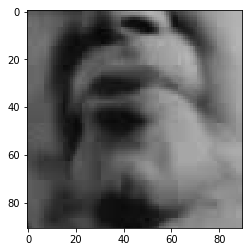

In [12]:
def getCroppedImageByPos(imgDir, df, num):
    image = getImageByNum(imgDir, num)
    if type(image) == bool:
        return False
    image = cv2.cvtColor(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), cv2.COLOR_GRAY2RGB)
    xmin, xmax, ymin, ymax = getBoundingBoxCoords(df, num)
    return image[ymin:ymax, xmin:xmax]

cropped = getCroppedImageByPos(imgDir, dfc, 0)
plt.imshow(cropped)

#### Resize image

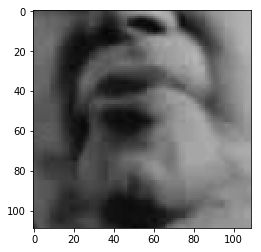

In [13]:
def resizeSquareImageTo(img, dim):
    return cv2.resize(img, (dim, dim), interpolation = cv2.INTER_CUBIC)

resized = resizeSquareImageTo(cropped, 109) 
plt.imshow(resized)

#### Output MP4

In [14]:
def generateMP4(df, srcPath, destPath, subdir, filename, resizeTo=125, fps=25):
    outputPath = join(destPath, subdir)
    if not os.path.exists(outputPath):
        os.makedirs(outputPath)
    inputPath = join(srcPath, subdir, filename)
    outputPath = join(outputPath, filename + '.mp4')
    size = (resizeTo, resizeTo)
    fourcc = cv2.VideoWriter_fourcc('P', 'I', 'M', 'J') #('D', 'I', 'V', 'X') ('M', 'P', '4', 'V')
    out = cv2.VideoWriter(outputPath, fourcc, fps, size)
    for f in range(df.shape[0]):
        cropped = getCroppedImageByPos(inputPath, df, f)
        if (type(cropped) == np.ndarray):
            resized = resizeSquareImageTo(cropped, resizeTo) 
            out.write(resized)
    out.release()
    return outputPath

generateMP4(dfc, './ttrainval', './ntrainval', 'rbnBeSvXGQM', '50007', 120)

'./ntrainval/rbnBeSvXGQM/50007.mp4'

### 3) BATCH PROCESS ALL FOLDERS (no testing)

In [15]:
i = 0
with open("output.csv",'w') as csvfile:
    csvwriter = csv.writer(csvfile, dialect='excel')
    csvwriter.writerow(['id', 'mp4', 'mp3', 'txt', 'mp4_new', 'frames', 'resolution', 'errors', 'no_face', 'no_pts', 'less_pts', 'verify_pts', 'bad_bounds'])
    #tfolders = ['./ttrainval']
    for f, folder in enumerate(tfolders, start=0):
        srcPath = folder
        destPath = nfolders[f]
        print(srcPath+"\t => \t"+destPath)
        print("\t%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s" % ("SUBDIRECTORY" ,"FILE", "# FRAME", "RES", "# E's:", " x face", "x pts", "- pts", "v pts", "- bounds"))
        subdirs = getSubDirs(srcPath)
        #subdirs = ['rbnBeSvXGQM']
        s = 0
        for subdir in subdirs:
            videos = getSubDirs(join(srcPath, subdir))
            #videos = ['50002']
            for video in videos:
                i += 1
                #print("\t%s\t%s" % (subdir, video))
                imgDir = join(srcPath, subdir, video)
                dfa_ = getLipCoordsForAllFiles(imgDir)
                dfb_ = verifyAndCorrectErrors(dfa_)
                errors = dfb_[['error']].sum(axis=0).error
                errors_noface = dfb_[['error_noface']].sum(axis=0).error_noface
                errors_nopts = dfb_[['error_nopts']].sum(axis=0).error_nopts
                errors_lesspts = dfb_[['error_lesspts']].sum(axis=0).error_lesspts
                errors_verifypts = dfb_[['error_verifypts']].sum(axis=0).error_verifypts
                max_xdiff, max_ydiff = getBoundingBoxMaxLengthsFromAggregatesDataframe(dfb_)
                max_xydiff = getOptimalBoundingBoxWidthAndHeight(max_xdiff, max_ydiff)
                dfc_ = fillTotalMinAndMaxForAggregatesDataframe(dfb_, max_xydiff)
                errors_bounds = dfc_[['error_bounds']].sum(axis=0).error_bounds
                keep = (errors == 0)
                if keep:
                    mp4Path = generateMP4(dfc_, srcPath, destPath, subdir, video, 120).replace('./ntest/', 'test/ntest/').replace('./ntrainval/', 'train/ntrainval/')
                    #mp4Path = join(destPath, subdir, video+'.mp4').replace('./ntest/', 'test/ntest/').replace('./ntrainval/', 'train/ntrainval/')
                else:
                    mp4Path = ""
                mainPath = join(srcPath, subdir, video).replace('./ttest/', 'test/test/').replace('./ttrainval/', 'train/trainval/')
                csvwriter.writerow([i, mainPath+'.mp4', mainPath+'.mp3', mainPath+'.txt', mp4Path, dfa_.shape[0], max_xydiff, errors, errors_noface, errors_nopts, errors_lesspts, errors_verifypts, errors_bounds])
                print("%s\t%s\t%s\t%s\t%s\t%.0d\t%.0d\t%.0d\t%.0d\t%.0d\t%.0d\t%s" % (s, subdir, video, dfa_.shape[0], max_xydiff, errors, errors_noface, errors_nopts, errors_lesspts, errors_verifypts, errors_bounds, keep))
            s += 1
            #if s > 20:
            #    break

./ttrainval	 => 	./xtrainval
	SUBDIRECTORY	FILE	# FRAME	RES	# E's:	 x face	x pts	- pts	v pts	- bounds
0	rbnBeSvXGQM	50006	51	108	0	0	0	0	1	0	True
0	rbnBeSvXGQM	50001	25	150	25	0	0	0	25	24	False
0	rbnBeSvXGQM	50008	26	136	26	0	0	0	26	24	False
0	rbnBeSvXGQM	50009	22	150	22	0	0	0	22	19	False
0	rbnBeSvXGQM	50007	30	90	0	0	0	0	15	0	True
0	rbnBeSvXGQM	50012	38	108	0	0	0	0	5	0	True
0	rbnBeSvXGQM	50002	27	94	0	0	0	0	11	0	True
0	rbnBeSvXGQM	50005	34	90	0	0	0	0	30	0	True
0	rbnBeSvXGQM	50004	30	128	0	0	0	0	17	4	True
0	rbnBeSvXGQM	50003	30	94	0	0	0	0	19	0	True
0	rbnBeSvXGQM	50010	54	100	0	0	0	0	37	0	True
0	rbnBeSvXGQM	50011	29	142	29	0	0	0	29	28	False
1	pNttjJUtkA4	50001	152	86	0	0	0	0	147	0	True
2	ywgdCrcx6oM	50001	78	90	0	0	0	0	51	0	True
2	ywgdCrcx6oM	50002	40	80	0	0	0	0	30	0	True
3	GjYt5uQPu8o	50001	50	156	50	0	0	0	50	44	False
4	PdxPCeWw75k	50001	35	52	0	0	0	0	24	0	True
5	CLWRclarri0	50001	65	150	65	0	0	0	65	65	False
6	WFImhWa5oUw	50001	51	80	0	0	0	0	48	0	True
7	CdxVbUjaSpY	50006	23	80	0	0	0	0	

32	qQDC7c2I8l8	50007	152	104	0	0	0	0	149	0	True
32	qQDC7c2I8l8	50002	72	100	0	0	0	0	58	0	True
32	qQDC7c2I8l8	50005	57	104	57	0	0	0	57	0	False
32	qQDC7c2I8l8	50004	152	76	0	0	0	0	151	0	True
32	qQDC7c2I8l8	50003	144	104	144	0	0	0	144	0	False
32	qQDC7c2I8l8	50010	152	98	152	0	0	0	152	0	False
32	qQDC7c2I8l8	50011	152	100	0	0	0	0	113	0	True
33	79zra755WgA	50006	81	98	0	0	0	0	74	0	True
33	79zra755WgA	50001	35	90	0	0	0	0	33	0	True
33	79zra755WgA	50008	151	98	0	0	0	0	118	0	True
33	79zra755WgA	50009	47	76	0	0	0	0	45	0	True
33	79zra755WgA	50007	154	84	0	0	0	0	147	0	True
33	79zra755WgA	50014	150	80	0	0	0	0	125	0	True
33	79zra755WgA	50013	58	90	58	0	0	0	58	0	False
33	79zra755WgA	50012	35	154	35	0	0	0	35	8	False
33	79zra755WgA	50015	68	86	68	0	0	0	68	0	False
33	79zra755WgA	50002	48	76	0	0	0	0	45	0	True
33	79zra755WgA	50005	129	136	129	0	0	0	129	4	False
33	79zra755WgA	50004	38	156	38	0	0	0	38	28	False
33	79zra755WgA	50003	39	86	39	0	0	0	39	0	False
33	79zra755WgA	50010	131	70	0	0	0	0	128	0	True
33	79

47	MIRoB4LStDY	50007	91	72	0	0	0	0	80	0	True
47	MIRoB4LStDY	50002	20	62	0	0	0	0	19	0	True
47	MIRoB4LStDY	50005	96	70	0	0	0	0	91	0	True
47	MIRoB4LStDY	50004	56	72	0	0	0	0	46	0	True
47	MIRoB4LStDY	50003	33	80	33	0	0	0	33	0	False
48	eMSonXncSjA	50006	149	94	149	0	0	0	149	0	False
48	eMSonXncSjA	50001	152	100	152	0	0	0	152	0	False
48	eMSonXncSjA	50008	152	104	152	0	0	0	152	1	False
48	eMSonXncSjA	50009	29	86	29	0	0	0	29	0	False
48	eMSonXncSjA	50007	123	112	123	0	0	0	123	0	False
48	eMSonXncSjA	50014	38	70	0	0	0	0	35	0	True
48	eMSonXncSjA	50013	144	104	144	0	0	0	144	0	False
48	eMSonXncSjA	50012	112	84	0	0	0	0	108	0	True
48	eMSonXncSjA	50015	79	84	0	0	0	0	76	0	True
48	eMSonXncSjA	50002	137	90	137	0	0	0	137	0	False
48	eMSonXncSjA	50005	142	90	142	0	0	0	142	0	False
48	eMSonXncSjA	50004	39	86	39	0	0	0	39	0	False
48	eMSonXncSjA	50021	154	98	154	0	0	0	154	0	False
48	eMSonXncSjA	50019	40	94	40	0	0	0	40	0	False
48	eMSonXncSjA	50010	33	86	33	0	0	0	33	0	False
48	eMSonXncSjA	50017	153	98	153	0	0	0	153	0	

69	855Now8h5Rs	50010	154	86	0	0	0	0	143	0	True
69	855Now8h5Rs	50017	73	84	0	0	0	0	69	0	True
69	855Now8h5Rs	50016	69	76	0	0	0	0	57	0	True
69	855Now8h5Rs	50011	150	76	0	0	0	0	136	0	True
69	855Now8h5Rs	50027	145	84	0	0	0	0	61	0	True
69	855Now8h5Rs	50018	36	72	0	0	0	0	30	0	True
69	855Now8h5Rs	50020	55	70	0	0	0	0	51	0	True
70	fddYApFEWfY	50001	50	80	50	0	0	0	50	0	False
70	fddYApFEWfY	50002	89	70	0	0	0	0	41	0	True
71	xmlekZSSOWE	50006	35	94	0	0	0	0	34	0	True
71	xmlekZSSOWE	50001	29	114	0	0	0	0	27	28	True
71	xmlekZSSOWE	50008	49	128	49	0	0	0	49	1	False
71	xmlekZSSOWE	50009	149	98	0	0	0	0	111	0	True
71	xmlekZSSOWE	50007	88	100	0	0	0	0	58	0	True
71	xmlekZSSOWE	50002	30	86	0	0	0	0	9	0	True
71	xmlekZSSOWE	50005	154	104	0	0	0	0	133	0	True
71	xmlekZSSOWE	50004	81	98	0	0	0	0	76	0	True
71	xmlekZSSOWE	50003	81	108	0	0	0	0	64	0	True
72	jSSqQDPGW2k	50006	153	76	153	0	0	0	153	0	False
72	jSSqQDPGW2k	50001	72	84	72	0	0	0	72	0	False
72	jSSqQDPGW2k	50008	82	80	0	0	0	0	56	0	True
72	jSSqQDPGW2k	50009	52	72	52	

89	UGtFXtnWME4	50013	39	114	39	0	0	0	39	39	False
89	UGtFXtnWME4	50012	36	66	0	0	0	0	31	0	True
89	UGtFXtnWME4	50015	54	76	0	0	0	0	44	0	True
89	UGtFXtnWME4	50023	43	72	0	0	0	0	28	0	True
89	UGtFXtnWME4	50024	19	108	19	0	0	0	19	7	False
89	UGtFXtnWME4	50002	78	98	0	0	0	0	55	8	True
89	UGtFXtnWME4	50005	29	44	0	0	0	0	26	0	True
89	UGtFXtnWME4	50004	25	108	25	0	0	0	25	6	False
89	UGtFXtnWME4	50003	153	84	0	0	0	0	82	0	True
89	UGtFXtnWME4	50021	33	84	33	0	0	0	33	0	False
89	UGtFXtnWME4	50026	48	80	0	0	0	0	15	0	True
89	UGtFXtnWME4	50019	83	80	0	0	0	0	59	0	True
89	UGtFXtnWME4	50010	36	108	36	0	0	0	36	23	False
89	UGtFXtnWME4	50017	65	100	0	0	0	0	5	0	True
89	UGtFXtnWME4	50016	46	84	0	0	0	0	16	0	True
89	UGtFXtnWME4	50011	33	72	0	0	0	0	29	0	True
89	UGtFXtnWME4	50027	20	72	0	0	0	0	3	0	True
89	UGtFXtnWME4	50018	57	76	0	0	0	0	1	0	True
89	UGtFXtnWME4	50020	108	70	0	0	0	0	96	0	True
90	7sqeoYOQ4qg	50006	62	76	0	0	0	0	55	0	True
90	7sqeoYOQ4qg	50001	117	80	0	0	0	0	97	0	True
90	7sqeoYOQ4qg	50008	97	90	0	0	0	0	80	

109	q319HSSLs9Q	50006	72	84	72	0	0	0	72	0	False
109	q319HSSLs9Q	50001	31	66	0	0	0	0	30	0	True
109	q319HSSLs9Q	50008	41	72	0	0	0	0	27	0	True
109	q319HSSLs9Q	50009	78	86	78	0	0	0	78	0	False
109	q319HSSLs9Q	50007	29	76	0	0	0	0	20	0	True
109	q319HSSLs9Q	50005	37	84	37	0	0	0	37	0	False
109	q319HSSLs9Q	50004	39	80	39	0	0	0	39	0	False
109	q319HSSLs9Q	50003	32	86	32	0	0	0	32	0	False
109	q319HSSLs9Q	50010	50	80	0	0	0	0	44	0	True
109	q319HSSLs9Q	50011	44	84	44	0	0	0	44	0	False
110	IjHlyKTSUug	50006	98	76	0	0	0	0	95	0	True
110	IjHlyKTSUug	50001	53	86	0	0	0	0	4	0	True
110	IjHlyKTSUug	50007	70	86	0	0	0	0	28	0	True
110	IjHlyKTSUug	50014	91	80	0	0	0	0	88	0	True
110	IjHlyKTSUug	50012	35	84	0	0	0	0	14	0	True
110	IjHlyKTSUug	50015	113	80	0	0	0	0	17	0	True
110	IjHlyKTSUug	50005	28	80	0	0	0	0	27	0	True
110	IjHlyKTSUug	50003	31	84	0	0	0	0	10	0	True
110	IjHlyKTSUug	50010	41	84	0	0	0	0	0	0	True
110	IjHlyKTSUug	50011	63	86	0	0	0	0	15	0	True
111	SwaBFUgSoT8	50006	147	86	0	0	0	0	100	0	True
111	SwaBFUgSoT8	50001

137	v84pD2g3gSk	50001	50	112	0	0	0	0	29	0	True
137	v84pD2g3gSk	50008	29	100	29	0	0	0	29	0	False
137	v84pD2g3gSk	50009	46	104	0	0	0	0	14	0	True
137	v84pD2g3gSk	50007	46	98	0	0	0	0	31	0	True
137	v84pD2g3gSk	50002	49	126	0	0	0	0	23	13	True
137	v84pD2g3gSk	50005	56	136	56	0	0	0	56	10	False
137	v84pD2g3gSk	50003	31	98	0	0	0	0	22	0	True
137	v84pD2g3gSk	50010	36	94	0	0	0	0	27	0	True
138	BQj2ZSGPsY8	50006	29	58	0	0	0	0	25	0	True
138	BQj2ZSGPsY8	50001	146	84	0	0	0	0	87	0	True
138	BQj2ZSGPsY8	50008	75	62	0	0	0	0	71	0	True
138	BQj2ZSGPsY8	50009	155	86	0	0	0	0	95	0	True
138	BQj2ZSGPsY8	50007	151	76	0	0	0	0	28	0	True
138	BQj2ZSGPsY8	50014	94	86	0	0	0	0	66	0	True
138	BQj2ZSGPsY8	50013	40	90	0	0	0	0	13	0	True
138	BQj2ZSGPsY8	50012	35	86	0	0	0	0	31	0	True
138	BQj2ZSGPsY8	50015	73	84	0	0	0	0	58	0	True
138	BQj2ZSGPsY8	50002	146	84	0	0	0	0	88	0	True
138	BQj2ZSGPsY8	50005	153	84	0	0	0	0	62	0	True
138	BQj2ZSGPsY8	50004	74	72	0	0	0	0	50	0	True
138	BQj2ZSGPsY8	50003	44	72	0	0	0	0	27	0	True
138	BQj2ZSGPsY8	50

162	DqCsQqy9MyU	50019	92	76	0	0	0	0	64	0	True
162	DqCsQqy9MyU	50010	151	66	0	0	0	0	131	0	True
162	DqCsQqy9MyU	50017	75	62	0	0	0	0	68	0	True
162	DqCsQqy9MyU	50016	147	72	0	0	0	0	119	0	True
162	DqCsQqy9MyU	50011	128	72	0	0	0	0	54	0	True
162	DqCsQqy9MyU	50018	81	76	0	0	0	0	53	0	True
162	DqCsQqy9MyU	50020	35	70	35	0	0	0	35	0	False
163	bbT8jSPS2LA	50039	45	84	0	0	0	0	39	0	True
163	bbT8jSPS2LA	50006	79	80	0	0	0	0	67	0	True
163	bbT8jSPS2LA	50001	37	86	37	0	0	0	37	0	False
163	bbT8jSPS2LA	50008	45	84	0	0	0	0	35	0	True
163	bbT8jSPS2LA	50037	22	84	22	0	0	0	22	0	False
163	bbT8jSPS2LA	50030	47	72	0	0	0	0	45	0	True
163	bbT8jSPS2LA	50031	56	80	0	0	0	0	44	0	True
163	bbT8jSPS2LA	50009	56	84	0	0	0	0	31	0	True
163	bbT8jSPS2LA	50036	53	80	0	0	0	0	50	0	True
163	bbT8jSPS2LA	50038	45	84	0	0	0	0	40	0	True
163	bbT8jSPS2LA	50007	150	80	0	0	0	0	57	0	True
163	bbT8jSPS2LA	50047	47	84	0	0	0	0	19	0	True
163	bbT8jSPS2LA	50040	80	84	0	0	0	0	59	0	True
163	bbT8jSPS2LA	50025	96	84	0	0	0	0	32	0	True
163	bbT8jSPS2LA	50022	

183	lwVYaY39YbQ	50002	75	104	0	0	0	0	37	0	True
184	bpi6us7wQfE	50006	66	70	0	0	0	0	60	0	True
184	bpi6us7wQfE	50001	34	72	0	0	0	0	0	0	True
184	bpi6us7wQfE	50008	47	76	0	0	0	0	9	0	True
184	bpi6us7wQfE	50007	28	76	0	0	0	0	25	0	True
184	bpi6us7wQfE	50012	33	70	0	0	0	0	0	0	True
184	bpi6us7wQfE	50015	38	76	0	0	0	0	22	0	True
184	bpi6us7wQfE	50002	27	58	27	0	0	0	27	0	False
184	bpi6us7wQfE	50005	71	66	0	0	0	0	12	0	True
184	bpi6us7wQfE	50004	34	70	0	0	0	0	6	0	True
184	bpi6us7wQfE	50003	34	62	0	0	0	0	18	0	True
185	nZLO2PnGzMg	50006	35	80	35	0	0	0	35	0	False
185	nZLO2PnGzMg	50001	47	76	0	0	0	0	26	0	True
185	nZLO2PnGzMg	50002	90	128	90	0	0	0	90	53	False
185	nZLO2PnGzMg	50005	37	150	37	0	0	0	37	22	False
185	nZLO2PnGzMg	50004	41	100	0	0	0	0	35	0	True
185	nZLO2PnGzMg	50003	34	76	34	0	0	0	34	0	False
186	vJ66jv8ICjc	50001	55	70	0	0	0	0	35	0	True
187	jHLm5Lne3D0	50001	49	66	0	0	0	0	45	0	True
187	jHLm5Lne3D0	50004	33	66	0	0	0	0	27	0	True
187	jHLm5Lne3D0	50003	81	84	0	0	0	0	32	0	True
188	xuAAPsiD768	50006	

201	GhpFTQfiqCs	50005	34	94	0	0	0	0	17	0	True
201	GhpFTQfiqCs	50004	41	84	41	0	0	0	41	0	False
201	GhpFTQfiqCs	50003	51	84	0	0	0	0	45	0	True
202	W0StyxgMk1o	50006	145	80	0	0	0	0	125	0	True
202	W0StyxgMk1o	50001	87	90	87	0	0	0	87	0	False
202	W0StyxgMk1o	50007	29	140	29	0	0	0	29	2	False
202	W0StyxgMk1o	50002	52	62	0	0	0	0	47	0	True
202	W0StyxgMk1o	50005	88	90	88	0	0	0	88	0	False
202	W0StyxgMk1o	50004	101	80	0	0	0	0	18	0	True
202	W0StyxgMk1o	50003	61	72	0	0	0	0	38	0	True
202	W0StyxgMk1o	50010	43	80	43	0	0	0	43	0	False
203	yqc9zX04DXs	50001	74	126	74	0	0	0	74	1	False
204	yPGwA7t6bpI	50001	151	58	0	0	0	0	140	0	True
204	yPGwA7t6bpI	50002	65	72	0	0	0	0	51	0	True
204	yPGwA7t6bpI	50005	49	178	49	0	0	0	49	49	False
204	yPGwA7t6bpI	50004	51	146	51	0	0	0	51	41	False
204	yPGwA7t6bpI	50003	155	66	0	0	0	0	141	0	True
205	vqPAdUeU6mQ	50001	38	86	0	0	0	0	11	0	True
205	vqPAdUeU6mQ	50002	108	84	0	0	0	0	1	0	True
205	vqPAdUeU6mQ	50003	51	66	0	0	0	0	46	0	True
206	80GqbW1MmQM	50006	142	104	0	0	0	0	106	0	True
20

228	VmP574ikRFs	50021	27	94	0	0	0	0	20	0	True
228	VmP574ikRFs	50019	48	100	48	0	0	0	48	0	False
228	VmP574ikRFs	50010	39	90	0	0	0	0	31	0	True
228	VmP574ikRFs	50017	38	86	0	0	0	0	37	0	True
228	VmP574ikRFs	50016	61	94	0	0	0	0	51	0	True
228	VmP574ikRFs	50011	26	90	26	0	0	0	26	0	False
228	VmP574ikRFs	50018	113	94	0	0	0	0	51	0	True
228	VmP574ikRFs	50020	77	94	0	0	0	0	59	0	True
229	3E7hkPZSHTk	50006	72	72	0	0	0	0	67	0	True
229	3E7hkPZSHTk	50001	22	80	0	0	0	0	11	0	True
229	3E7hkPZSHTk	50008	46	80	0	0	0	0	16	0	True
229	3E7hkPZSHTk	50009	93	86	0	0	0	0	62	0	True
229	3E7hkPZSHTk	50007	134	90	0	0	0	0	86	0	True
229	3E7hkPZSHTk	50002	95	80	0	0	0	0	54	0	True
229	3E7hkPZSHTk	50005	151	84	0	0	0	0	100	0	True
229	3E7hkPZSHTk	50004	32	72	0	0	0	0	4	0	True
229	3E7hkPZSHTk	50003	154	80	0	0	0	0	115	0	True
229	3E7hkPZSHTk	50010	74	86	0	0	0	0	50	0	True
230	G9wIXAGzn1w	50001	100	104	0	0	0	0	88	42	True
230	G9wIXAGzn1w	50002	88	112	0	0	0	0	76	88	True
230	G9wIXAGzn1w	50003	144	142	144	0	0	0	144	40	False
231	zsLz0mRm

256	EiTrl0W1QrM	50013	31	76	0	0	0	0	28	0	True
256	EiTrl0W1QrM	50012	152	62	0	0	0	0	146	0	True
256	EiTrl0W1QrM	50015	150	90	0	0	0	0	126	0	True
256	EiTrl0W1QrM	50002	82	150	82	0	0	0	82	36	False
256	EiTrl0W1QrM	50005	36	76	0	0	0	0	31	0	True
256	EiTrl0W1QrM	50004	66	84	66	0	0	0	66	0	False
256	EiTrl0W1QrM	50003	32	66	32	0	0	0	32	0	False
256	EiTrl0W1QrM	50019	89	70	0	0	0	0	88	0	True
256	EiTrl0W1QrM	50010	85	86	0	0	0	0	48	0	True
256	EiTrl0W1QrM	50017	56	56	0	0	0	0	53	0	True
256	EiTrl0W1QrM	50016	116	84	0	0	0	0	109	0	True
256	EiTrl0W1QrM	50011	132	62	0	0	0	0	121	0	True
256	EiTrl0W1QrM	50018	53	70	53	0	0	0	53	0	False
256	EiTrl0W1QrM	50020	37	80	37	0	0	0	37	0	False
257	BzDEFAGvShc	50001	62	84	0	0	0	0	49	0	True
257	BzDEFAGvShc	50002	24	84	0	0	0	0	23	0	True
257	BzDEFAGvShc	50003	37	70	0	0	0	0	36	0	True
258	apiScBmE6rA	50001	24	70	0	0	0	0	23	0	True
258	apiScBmE6rA	50002	29	66	0	0	0	0	27	0	True
258	apiScBmE6rA	50004	93	76	0	0	0	0	83	0	True
258	apiScBmE6rA	50003	141	72	0	0	0	0	128	0	True
259	gSUvy6pv

276	7Xmr87nsl74	50004	63	86	0	0	0	0	52	0	True
276	7Xmr87nsl74	50003	54	84	0	0	0	0	53	0	True
276	7Xmr87nsl74	50010	142	118	142	0	0	0	142	3	False
276	7Xmr87nsl74	50011	154	84	0	0	0	0	147	0	True
277	2dRlssVF7fc	50002	104	70	0	0	0	0	41	0	True
277	2dRlssVF7fc	50004	139	70	0	0	0	0	127	0	True
277	2dRlssVF7fc	50003	144	70	0	0	0	0	91	0	True
278	1fZ4XOnnh1c	50006	147	86	0	0	0	0	120	0	True
278	1fZ4XOnnh1c	50001	28	72	0	0	0	0	13	0	True
278	1fZ4XOnnh1c	50008	147	80	0	0	0	0	139	0	True
278	1fZ4XOnnh1c	50007	94	76	0	0	0	0	87	0	True
278	1fZ4XOnnh1c	50002	46	52	0	0	0	0	42	0	True
278	1fZ4XOnnh1c	50005	144	94	0	0	0	0	131	0	True
278	1fZ4XOnnh1c	50004	141	90	0	0	0	0	135	0	True
278	1fZ4XOnnh1c	50003	147	80	0	0	0	0	140	0	True
279	jKAehegqTvg	50006	34	98	34	0	0	0	34	0	False
279	jKAehegqTvg	50001	65	84	0	0	0	0	58	0	True
279	jKAehegqTvg	50008	43	94	43	0	0	0	43	0	False
279	jKAehegqTvg	50009	97	94	97	0	0	0	97	0	False
279	jKAehegqTvg	50007	94	86	0	0	0	0	61	0	True
279	jKAehegqTvg	50022	81	86	0	0	0	0	54	0	True
279	jK

301	KDBcoRLkut8	50004	103	76	0	0	0	0	87	0	True
301	KDBcoRLkut8	50003	145	80	0	0	0	0	107	0	True
302	hj7wkh6nONE	50001	31	84	0	0	0	0	20	0	True
303	soqnBdPOwoo	50001	93	80	93	0	0	0	93	0	False
303	soqnBdPOwoo	50002	65	84	65	0	0	0	65	0	False
303	soqnBdPOwoo	50003	71	94	71	0	0	0	71	0	False
304	SsU5CJRaKP8	50006	144	86	0	0	0	0	122	0	True
304	SsU5CJRaKP8	50001	65	86	0	0	0	0	28	0	True
304	SsU5CJRaKP8	50008	58	76	0	0	0	0	56	0	True
304	SsU5CJRaKP8	50009	144	86	0	0	0	0	111	0	True
304	SsU5CJRaKP8	50007	153	84	0	0	0	0	125	0	True
304	SsU5CJRaKP8	50002	57	84	0	0	0	0	47	0	True
304	SsU5CJRaKP8	50005	33	72	0	0	0	0	23	0	True
304	SsU5CJRaKP8	50004	143	84	0	0	0	0	139	0	True
304	SsU5CJRaKP8	50003	137	94	0	0	0	0	98	0	True
304	SsU5CJRaKP8	50010	152	84	0	0	0	0	120	0	True
305	chXsLtHqfdM	50006	43	72	0	0	0	0	42	0	True
305	chXsLtHqfdM	50001	126	84	0	0	0	0	103	0	True
305	chXsLtHqfdM	50008	152	90	0	0	0	0	109	0	True
305	chXsLtHqfdM	50009	27	86	0	0	0	0	11	0	True
305	chXsLtHqfdM	50007	50	80	50	0	0	0	50	0	False
305	chXs

332	mzy84VbSGxk	50008	57	70	57	0	0	0	57	0	False
332	mzy84VbSGxk	50009	24	70	24	0	0	0	24	0	False
332	mzy84VbSGxk	50007	61	76	61	0	0	0	61	0	False
332	mzy84VbSGxk	50002	28	72	0	0	0	0	25	0	True
332	mzy84VbSGxk	50004	150	150	150	0	0	0	150	45	False
332	mzy84VbSGxk	50003	127	80	0	0	0	0	118	0	True
333	796LfXwzIUk	50006	37	66	0	0	0	0	7	0	True
333	796LfXwzIUk	50001	42	70	42	0	0	0	42	0	False
333	796LfXwzIUk	50008	155	70	0	0	0	0	88	0	True
333	796LfXwzIUk	50037	43	66	0	0	0	0	15	0	True
333	796LfXwzIUk	50030	129	66	129	0	0	0	129	0	False
333	796LfXwzIUk	50031	149	146	149	0	0	0	149	3	False
333	796LfXwzIUk	50009	83	56	0	0	0	0	80	0	True
333	796LfXwzIUk	50038	82	84	82	0	0	0	82	0	False
333	796LfXwzIUk	50007	41	58	0	0	0	0	38	0	True
333	796LfXwzIUk	50025	49	56	0	0	0	0	16	0	True
333	796LfXwzIUk	50022	129	66	0	0	0	0	121	0	True
333	796LfXwzIUk	50014	59	70	0	0	0	0	14	0	True
333	796LfXwzIUk	50013	150	66	0	0	0	0	82	0	True
333	796LfXwzIUk	50012	95	70	0	0	0	0	39	0	True
333	796LfXwzIUk	50015	152	70	0	0	0	0	121	0	True

346	KI3WJXNhCJ8	50040	79	86	0	0	0	0	74	0	True
346	KI3WJXNhCJ8	50049	27	90	0	0	0	0	15	0	True
346	KI3WJXNhCJ8	50025	59	70	0	0	0	0	53	0	True
346	KI3WJXNhCJ8	50022	135	76	0	0	0	0	129	0	True
346	KI3WJXNhCJ8	50014	79	90	0	0	0	0	40	0	True
346	KI3WJXNhCJ8	50013	105	90	0	0	0	0	55	0	True
346	KI3WJXNhCJ8	50048	19	86	0	0	0	0	18	0	True
346	KI3WJXNhCJ8	50041	36	86	0	0	0	0	0	0	True
346	KI3WJXNhCJ8	50046	67	94	0	0	0	0	34	0	True
346	KI3WJXNhCJ8	50012	139	90	0	0	0	0	99	0	True
346	KI3WJXNhCJ8	50015	30	100	30	0	0	0	30	0	False
346	KI3WJXNhCJ8	50023	86	86	0	0	0	0	67	0	True
346	KI3WJXNhCJ8	50024	129	94	0	0	0	0	103	0	True
346	KI3WJXNhCJ8	50051	53	86	53	0	0	0	53	0	False
346	KI3WJXNhCJ8	50002	26	84	0	0	0	0	18	0	True
346	KI3WJXNhCJ8	50005	43	86	0	0	0	0	40	0	True
346	KI3WJXNhCJ8	50033	138	90	0	0	0	0	118	0	True
346	KI3WJXNhCJ8	50034	108	84	0	0	0	0	104	0	True
346	KI3WJXNhCJ8	50050	147	90	0	0	0	0	78	0	True
346	KI3WJXNhCJ8	50035	122	84	0	0	0	0	90	0	True
346	KI3WJXNhCJ8	50032	56	70	0	0	0	0	50	0	True
346	KI3WJXNhCJ8	50

372	ZcFRfJb2ONk	50007	55	76	0	0	0	0	10	0	True
372	ZcFRfJb2ONk	50002	33	84	0	0	0	0	4	0	True
372	ZcFRfJb2ONk	50005	142	86	0	0	0	0	39	0	True
372	ZcFRfJb2ONk	50004	67	80	0	0	0	0	15	0	True
372	ZcFRfJb2ONk	50003	138	90	0	0	0	0	36	0	True
373	WbuIl6phdco	50006	31	128	31	0	0	0	31	22	False
373	WbuIl6phdco	50001	65	80	0	0	0	0	52	0	True
373	WbuIl6phdco	50008	24	76	0	0	0	0	0	0	True
373	WbuIl6phdco	50009	148	80	0	0	0	0	81	0	True
373	WbuIl6phdco	50007	152	76	0	0	0	0	114	0	True
373	WbuIl6phdco	50013	42	86	0	0	0	0	12	0	True
373	WbuIl6phdco	50012	56	86	0	0	0	0	23	0	True
373	WbuIl6phdco	50002	43	90	0	0	0	0	23	0	True
373	WbuIl6phdco	50005	74	80	0	0	0	0	51	0	True
373	WbuIl6phdco	50004	37	84	0	0	0	0	25	0	True
373	WbuIl6phdco	50003	33	114	33	0	0	0	33	18	False
373	WbuIl6phdco	50010	68	84	0	0	0	0	19	0	True
373	WbuIl6phdco	50011	95	80	0	0	0	0	26	0	True
374	mgSx0q6AjdI	50001	68	104	0	0	0	0	66	0	True
374	mgSx0q6AjdI	50008	34	150	34	0	0	0	34	17	False
374	mgSx0q6AjdI	50009	148	118	148	0	0	0	148	5	False
374	mgSx0q6A

391	6Co3dn0nSTk	50004	136	84	0	0	0	0	130	0	True
391	6Co3dn0nSTk	50003	103	94	0	0	0	0	86	0	True
392	I64CQp6z0Pk	50001	151	80	0	0	0	0	94	0	True
392	I64CQp6z0Pk	50002	30	62	30	0	0	0	30	0	False
392	I64CQp6z0Pk	50003	82	80	0	0	0	0	41	0	True
393	M3mnUMmUAHQ	50006	146	72	0	0	0	0	119	0	True
393	M3mnUMmUAHQ	50001	112	86	112	0	0	0	112	0	False
393	M3mnUMmUAHQ	50008	151	66	0	0	0	0	139	0	True
393	M3mnUMmUAHQ	50009	41	72	0	0	0	0	25	0	True
393	M3mnUMmUAHQ	50007	103	80	0	0	0	0	62	0	True
393	M3mnUMmUAHQ	50014	154	72	0	0	0	0	87	0	True
393	M3mnUMmUAHQ	50013	102	80	0	0	0	0	95	0	True
393	M3mnUMmUAHQ	50012	121	80	0	0	0	0	93	0	True
393	M3mnUMmUAHQ	50015	152	76	0	0	0	0	87	0	True
393	M3mnUMmUAHQ	50002	70	132	70	0	0	0	70	34	False
393	M3mnUMmUAHQ	50005	143	84	0	0	0	0	109	0	True
393	M3mnUMmUAHQ	50004	68	80	68	0	0	0	68	0	False
393	M3mnUMmUAHQ	50003	71	80	71	0	0	0	71	0	False
393	M3mnUMmUAHQ	50019	52	72	52	0	0	0	52	0	False
393	M3mnUMmUAHQ	50010	91	80	0	0	0	0	36	0	True
393	M3mnUMmUAHQ	50017	54	84	0	0	0	0	18	0	True
39

417	J6oMG7u9HGE	50035	152	76	0	0	0	0	150	0	True
417	J6oMG7u9HGE	50032	41	86	0	0	0	0	20	0	True
417	J6oMG7u9HGE	50004	50	76	0	0	0	0	38	0	True
417	J6oMG7u9HGE	50003	55	86	0	0	0	0	34	0	True
417	J6oMG7u9HGE	50021	23	72	0	0	0	0	13	0	True
417	J6oMG7u9HGE	50026	80	62	0	0	0	0	76	0	True
417	J6oMG7u9HGE	50019	32	94	32	0	0	0	32	0	False
417	J6oMG7u9HGE	50010	35	66	0	0	0	0	34	0	True
417	J6oMG7u9HGE	50017	64	80	0	0	0	0	55	0	True
417	J6oMG7u9HGE	50028	69	84	0	0	0	0	54	0	True
417	J6oMG7u9HGE	50043	66	80	0	0	0	0	51	0	True
417	J6oMG7u9HGE	50044	43	76	0	0	0	0	25	0	True
417	J6oMG7u9HGE	50072	82	76	0	0	0	0	74	0	True
417	J6oMG7u9HGE	50081	72	86	0	0	0	0	65	0	True
417	J6oMG7u9HGE	50075	25	86	0	0	0	0	13	0	True
417	J6oMG7u9HGE	50016	23	90	0	0	0	0	3	0	True
417	J6oMG7u9HGE	50011	40	86	40	0	0	0	40	0	False
417	J6oMG7u9HGE	50027	33	72	33	0	0	0	33	0	False
417	J6oMG7u9HGE	50018	148	84	0	0	0	0	136	0	True
417	J6oMG7u9HGE	50020	53	86	0	0	0	0	36	0	True
417	J6oMG7u9HGE	50074	128	66	0	0	0	0	120	0	True
417	J6oMG7u9HGE	50080	6

440	bZS7T5eF3hY	50007	100	112	0	0	0	0	78	18	True
440	bZS7T5eF3hY	50002	154	126	0	0	0	0	112	52	True
440	bZS7T5eF3hY	50005	44	122	0	0	0	0	26	34	True
440	bZS7T5eF3hY	50004	46	126	0	0	0	0	39	1	True
440	bZS7T5eF3hY	50003	104	128	0	0	0	0	83	43	True
441	TQMbvJNRpLE	50006	152	94	0	0	0	0	96	0	True
441	TQMbvJNRpLE	50001	151	90	0	0	0	0	123	0	True
441	TQMbvJNRpLE	50008	58	94	0	0	0	0	48	0	True
441	TQMbvJNRpLE	50007	34	86	0	0	0	0	25	0	True
441	TQMbvJNRpLE	50002	146	94	0	0	0	0	74	0	True
441	TQMbvJNRpLE	50005	153	84	0	0	0	0	108	0	True
441	TQMbvJNRpLE	50004	44	94	0	0	0	0	33	0	True
441	TQMbvJNRpLE	50003	88	90	0	0	0	0	61	0	True
442	4AaSUyfNN4c	50001	31	80	0	0	0	0	16	0	True
442	4AaSUyfNN4c	50002	43	76	0	0	0	0	41	0	True
443	8olL43PKJKw	50006	36	118	36	0	0	0	36	1	False
443	8olL43PKJKw	50001	31	84	0	0	0	0	21	0	True
443	8olL43PKJKw	50008	67	90	0	0	0	0	23	0	True
443	8olL43PKJKw	50009	125	80	0	0	0	0	120	0	True
443	8olL43PKJKw	50007	54	70	0	0	0	0	51	0	True
443	8olL43PKJKw	50013	41	100	41	0	0	0	41	0	False
443	8ol

459	8COaMKbNrX0	50012	57	76	57	0	0	0	57	0	False
459	8COaMKbNrX0	50002	48	58	48	0	0	0	48	0	False
459	8COaMKbNrX0	50005	51	80	51	0	0	0	51	0	False
459	8COaMKbNrX0	50004	149	86	149	0	0	0	149	0	False
459	8COaMKbNrX0	50003	138	84	0	0	0	0	100	0	True
459	8COaMKbNrX0	50010	138	72	0	0	0	0	137	0	True
460	3F2jACWwKdU	50006	53	76	0	0	0	0	41	0	True
460	3F2jACWwKdU	50008	48	84	0	0	0	0	37	0	True
460	3F2jACWwKdU	50009	54	90	0	0	0	0	50	0	True
460	3F2jACWwKdU	50007	49	72	0	0	0	0	42	0	True
460	3F2jACWwKdU	50025	74	70	0	0	0	0	58	0	True
460	3F2jACWwKdU	50022	41	84	0	0	0	0	11	0	True
460	3F2jACWwKdU	50014	56	90	0	0	0	0	43	0	True
460	3F2jACWwKdU	50013	43	84	0	0	0	0	15	0	True
460	3F2jACWwKdU	50012	49	76	0	0	0	0	34	0	True
460	3F2jACWwKdU	50015	47	90	0	0	0	0	46	0	True
460	3F2jACWwKdU	50023	32	80	0	0	0	0	11	0	True
460	3F2jACWwKdU	50024	104	90	0	0	0	0	68	0	True
460	3F2jACWwKdU	50002	69	98	69	0	0	0	69	0	False
460	3F2jACWwKdU	50004	25	108	25	0	0	0	25	0	False
460	3F2jACWwKdU	50003	79	86	0	0	0	0	56	0	True
460	3F2jACWwK

481	SXYwKxdxfF8	50004	55	76	0	0	0	0	48	0	True
481	SXYwKxdxfF8	50003	42	72	0	0	0	0	35	0	True
482	8t987Lxt1t4	50006	48	112	0	0	0	0	40	25	True
482	8t987Lxt1t4	50001	153	94	0	0	0	0	138	0	True
482	8t987Lxt1t4	50007	81	100	0	0	0	0	64	38	True
482	8t987Lxt1t4	50002	54	104	0	0	0	0	44	0	True
482	8t987Lxt1t4	50005	46	114	0	0	0	0	21	46	True
482	8t987Lxt1t4	50004	36	66	0	0	0	0	34	0	True
482	8t987Lxt1t4	50003	70	76	0	0	0	0	42	0	True
483	RgtoZ2ue05w	50001	45	80	0	0	0	0	36	0	True
483	RgtoZ2ue05w	50002	146	86	0	0	0	0	31	0	True
483	RgtoZ2ue05w	50003	63	86	0	0	0	0	30	0	True
484	dsfROmgVN5U	50006	134	76	0	0	0	0	45	0	True
484	dsfROmgVN5U	50001	151	56	0	0	0	0	145	0	True
484	dsfROmgVN5U	50008	38	72	0	0	0	0	23	0	True
484	dsfROmgVN5U	50007	154	80	0	0	0	0	89	0	True
484	dsfROmgVN5U	50002	29	76	0	0	0	0	18	0	True
484	dsfROmgVN5U	50005	56	62	0	0	0	0	51	0	True
484	dsfROmgVN5U	50004	105	80	0	0	0	0	91	0	True
484	dsfROmgVN5U	50003	148	80	0	0	0	0	90	0	True
485	89Dhye1lgik	50001	39	108	39	0	0	0	39	0	False
485	89Dhye1lgik

497	7Y9W1Gex660	50005	82	80	0	0	0	0	10	0	True
497	7Y9W1Gex660	50004	37	66	0	0	0	0	32	0	True
497	7Y9W1Gex660	50003	155	84	0	0	0	0	55	0	True
498	YKACzIrog24	50006	147	70	0	0	0	0	125	0	True
498	YKACzIrog24	50001	32	70	0	0	0	0	19	0	True
498	YKACzIrog24	50008	154	76	0	0	0	0	109	0	True
498	YKACzIrog24	50009	151	70	0	0	0	0	85	0	True
498	YKACzIrog24	50007	154	76	0	0	0	0	96	0	True
498	YKACzIrog24	50002	137	72	0	0	0	0	103	0	True
498	YKACzIrog24	50005	153	80	0	0	0	0	81	0	True
498	YKACzIrog24	50004	150	76	0	0	0	0	64	0	True
498	YKACzIrog24	50003	144	80	0	0	0	0	64	0	True
499	BZsdiVTFt7Y	50001	79	76	79	0	0	0	79	0	False
499	BZsdiVTFt7Y	50002	51	126	51	0	0	0	51	3	False
499	BZsdiVTFt7Y	50003	153	86	153	0	0	0	153	0	False
500	EBebWBjpWIQ	50001	90	84	90	0	0	0	90	0	False
500	EBebWBjpWIQ	50002	82	86	82	0	0	0	82	0	False
500	EBebWBjpWIQ	50004	72	90	0	0	0	0	58	0	True
500	EBebWBjpWIQ	50003	83	76	0	0	0	0	80	0	True
501	vwhSTukb07U	50006	104	86	0	0	0	0	52	0	True
501	vwhSTukb07U	50001	37	84	0	0	0	0	16	0	True
501	vwh

518	RcGyVTAoXEU	50002	29	112	29	0	0	0	29	0	False
518	RcGyVTAoXEU	50005	54	94	54	0	0	0	54	0	False
518	RcGyVTAoXEU	50004	71	100	71	0	0	0	71	0	False
518	RcGyVTAoXEU	50003	139	76	0	0	0	0	114	0	True
519	B905LapVP7I	50006	85	66	0	0	0	0	83	0	True
519	B905LapVP7I	50001	89	72	0	0	0	0	77	0	True
519	B905LapVP7I	50008	50	76	0	0	0	0	32	0	True
519	B905LapVP7I	50009	101	72	0	0	0	0	51	0	True
519	B905LapVP7I	50007	143	72	0	0	0	0	101	0	True
519	B905LapVP7I	50002	148	76	0	0	0	0	112	0	True
519	B905LapVP7I	50005	67	76	0	0	0	0	17	0	True
519	B905LapVP7I	50004	145	76	0	0	0	0	113	0	True
519	B905LapVP7I	50003	148	76	0	0	0	0	97	0	True
519	B905LapVP7I	50010	51	58	51	0	0	0	51	0	False
519	B905LapVP7I	50011	149	66	0	0	0	0	110	0	True
520	jpRqbP9Nv9k	50001	33	42	0	0	0	0	32	0	True
520	jpRqbP9Nv9k	50002	55	168	55	0	0	0	55	46	False
520	jpRqbP9Nv9k	50004	31	168	31	0	0	0	31	23	False
520	jpRqbP9Nv9k	50003	30	118	30	0	0	0	30	7	False
521	lcZyzcTS5GU	50001	123	84	123	0	0	0	123	0	False
521	lcZyzcTS5GU	50002	94	70	0	0	0	0	88	0	T

542	9EglK8Mk18o	50017	23	94	23	0	0	0	23	0	False
542	9EglK8Mk18o	50028	152	90	0	0	0	0	100	0	True
542	9EglK8Mk18o	50016	50	90	0	0	0	0	35	0	True
542	9EglK8Mk18o	50029	30	104	30	0	0	0	30	0	False
542	9EglK8Mk18o	50027	79	66	0	0	0	0	74	0	True
542	9EglK8Mk18o	50018	26	86	0	0	0	0	23	0	True
542	9EglK8Mk18o	50020	55	76	0	0	0	0	48	0	True
543	tH5iEf9oxaI	50006	151	122	0	0	0	0	135	151	True
543	tH5iEf9oxaI	50001	155	72	0	0	0	0	129	0	True
543	tH5iEf9oxaI	50008	87	72	0	0	0	0	79	0	True
543	tH5iEf9oxaI	50009	140	94	140	0	0	0	140	0	False
543	tH5iEf9oxaI	50007	148	84	0	0	0	0	140	0	True
543	tH5iEf9oxaI	50014	40	142	40	0	0	0	40	27	False
543	tH5iEf9oxaI	50013	117	104	0	0	0	0	109	0	True
543	tH5iEf9oxaI	50012	63	86	0	0	0	0	58	0	True
543	tH5iEf9oxaI	50015	53	84	0	0	0	0	50	0	True
543	tH5iEf9oxaI	50002	145	94	0	0	0	0	73	0	True
543	tH5iEf9oxaI	50005	81	114	81	0	0	0	81	0	False
543	tH5iEf9oxaI	50004	144	98	144	0	0	0	144	0	False
543	tH5iEf9oxaI	50003	135	154	135	0	0	0	135	40	False
543	tH5iEf9oxaI	50010	152	80	0	0	0	0

558	LM3ISST2eg8	50004	32	84	32	0	0	0	32	0	False
558	LM3ISST2eg8	50003	37	76	37	0	0	0	37	0	False
558	LM3ISST2eg8	50010	153	72	0	0	0	0	150	0	True
558	LM3ISST2eg8	50011	145	114	145	0	0	0	145	35	False
559	VLe84OkwKOA	50006	154	90	0	0	0	0	48	0	True
559	VLe84OkwKOA	50001	38	98	38	0	0	0	38	1	False
559	VLe84OkwKOA	50008	48	76	0	0	0	0	38	0	True
559	VLe84OkwKOA	50009	129	94	0	0	0	0	62	0	True
559	VLe84OkwKOA	50007	153	86	0	0	0	0	152	0	True
559	VLe84OkwKOA	50002	39	136	39	0	0	0	39	4	False
559	VLe84OkwKOA	50004	142	80	0	0	0	0	110	0	True
559	VLe84OkwKOA	50003	66	86	0	0	0	0	47	0	True
559	VLe84OkwKOA	50010	22	168	22	0	0	0	22	21	False
560	5Jqk1rkuUwU	50006	43	80	43	0	0	0	43	0	False
560	5Jqk1rkuUwU	50001	25	70	0	0	0	0	21	0	True
560	5Jqk1rkuUwU	50008	55	70	0	0	0	0	54	0	True
560	5Jqk1rkuUwU	50007	27	70	27	0	0	0	27	0	False
560	5Jqk1rkuUwU	50025	81	80	0	0	0	0	77	0	True
560	5Jqk1rkuUwU	50022	27	76	27	0	0	0	27	0	False
560	5Jqk1rkuUwU	50014	23	80	23	0	0	0	23	0	False
560	5Jqk1rkuUwU	50013	83	84	83	0	0	0	83	0	Fa

581	y9Trdafp83U	50003	83	62	0	0	0	0	71	0	True
581	y9Trdafp83U	50010	50	80	50	0	0	0	50	0	False
581	y9Trdafp83U	50011	130	86	130	0	0	0	130	0	False
582	OHBaOyaltpU	50001	46	90	0	0	0	0	34	0	True
582	OHBaOyaltpU	50002	102	84	0	0	0	0	74	0	True
582	OHBaOyaltpU	50003	48	94	48	0	0	0	48	0	False
583	8lEUvISNgEE	50001	70	70	0	0	0	0	58	0	True
583	8lEUvISNgEE	50002	155	70	0	0	0	0	147	0	True
584	f5q9ZJ62NOo	50001	154	118	154	0	0	0	154	2	False
585	qNvDRuGK84I	50006	44	76	0	0	0	0	35	0	True
585	qNvDRuGK84I	50001	80	76	0	0	0	0	64	0	True
585	qNvDRuGK84I	50008	140	72	0	0	0	0	139	0	True
585	qNvDRuGK84I	50007	112	76	0	0	0	0	97	0	True
585	qNvDRuGK84I	50002	83	76	0	0	0	0	48	0	True
585	qNvDRuGK84I	50005	29	72	0	0	0	0	24	0	True
585	qNvDRuGK84I	50004	154	76	0	0	0	0	126	0	True
585	qNvDRuGK84I	50003	154	80	0	0	0	0	129	0	True
586	VjQ3ufqnfSM	50001	47	76	0	0	0	0	45	0	True
586	VjQ3ufqnfSM	50002	87	140	87	0	0	0	87	42	False
586	VjQ3ufqnfSM	50003	26	80	0	0	0	0	25	0	True
587	bmFhWr693is	50001	79	72	0	0	0	0	76	0	True
587	b

604	4mFzIumKKsc	50011	87	70	0	0	0	0	78	0	True
604	4mFzIumKKsc	50018	56	84	56	0	0	0	56	0	False
605	iFTWM7HV2UI	50006	34	98	34	0	0	0	34	0	False
605	iFTWM7HV2UI	50001	50	98	50	0	0	0	50	0	False
605	iFTWM7HV2UI	50008	153	90	0	0	0	0	124	0	True
605	iFTWM7HV2UI	50002	26	132	26	0	0	0	26	21	False
605	iFTWM7HV2UI	50005	61	86	61	0	0	0	61	0	False
605	iFTWM7HV2UI	50004	87	70	0	0	0	0	85	0	True
605	iFTWM7HV2UI	50003	76	136	76	0	0	0	76	10	False
606	oXbhTHaMwTw	50001	55	118	55	0	0	0	55	1	False
607	3E46oWB4V0s	50039	115	84	0	0	0	0	94	0	True
607	3E46oWB4V0s	50006	30	94	30	0	0	0	30	0	False
607	3E46oWB4V0s	50001	155	136	155	0	0	0	155	15	False
607	3E46oWB4V0s	50008	77	86	77	0	0	0	77	0	False
607	3E46oWB4V0s	50037	64	146	64	0	0	0	64	20	False
607	3E46oWB4V0s	50030	145	94	145	0	0	0	145	0	False
607	3E46oWB4V0s	50031	108	100	108	0	0	0	108	0	False
607	3E46oWB4V0s	50009	108	98	108	0	0	0	108	0	False
607	3E46oWB4V0s	50036	74	44	0	0	0	0	73	0	True
607	3E46oWB4V0s	50038	152	80	0	0	0	0	149	0	True
607	3E46oWB4V0s	50007	135

622	d6eMdixkoRI	50005	126	72	0	0	0	0	97	0	True
622	d6eMdixkoRI	50004	70	72	0	0	0	0	43	0	True
622	d6eMdixkoRI	50003	39	76	0	0	0	0	23	0	True
622	d6eMdixkoRI	50019	47	70	0	0	0	0	43	0	True
622	d6eMdixkoRI	50010	89	66	0	0	0	0	81	0	True
622	d6eMdixkoRI	50017	100	70	0	0	0	0	63	0	True
622	d6eMdixkoRI	50016	72	72	0	0	0	0	66	0	True
622	d6eMdixkoRI	50011	50	72	0	0	0	0	27	0	True
622	d6eMdixkoRI	50018	75	70	0	0	0	0	63	0	True
622	d6eMdixkoRI	50020	106	72	0	0	0	0	92	0	True
623	pvBlSFVmoaw	50006	45	76	0	0	0	0	43	0	True
623	pvBlSFVmoaw	50001	35	136	35	0	0	0	35	9	False
623	pvBlSFVmoaw	50008	140	114	140	0	0	0	140	2	False
623	pvBlSFVmoaw	50009	124	76	124	0	0	0	124	0	False
623	pvBlSFVmoaw	50007	73	80	0	0	0	0	51	0	True
623	pvBlSFVmoaw	50002	66	80	0	0	0	0	60	0	True
623	pvBlSFVmoaw	50004	66	70	0	0	0	0	61	0	True
623	pvBlSFVmoaw	50003	139	72	0	0	0	0	100	0	True
624	lSYy6poJ2zs	50001	70	90	70	0	0	0	70	0	False
624	lSYy6poJ2zs	50002	148	90	0	0	0	0	36	0	True
624	lSYy6poJ2zs	50004	65	126	65	0	0	0	65	5	False
624	lSYy6

647	B0YSGU3JqiQ	50002	39	80	0	0	0	0	34	0	True
647	B0YSGU3JqiQ	50005	146	90	0	0	0	0	132	7	True
647	B0YSGU3JqiQ	50003	34	84	34	0	0	0	34	0	False
648	Wgt8QUHQjw8	50001	144	86	0	0	0	0	89	0	True
648	Wgt8QUHQjw8	50002	143	86	0	0	0	0	118	0	True
649	fTosle3h3G8	50001	130	62	0	0	0	0	121	0	True
649	fTosle3h3G8	50002	152	112	0	0	0	0	110	32	True
649	fTosle3h3G8	50005	152	128	152	0	0	0	152	152	False
649	fTosle3h3G8	50004	70	122	70	0	0	0	70	70	False
649	fTosle3h3G8	50003	96	112	96	0	0	0	96	86	False
650	J0WQz9qlgZI	50001	147	94	0	0	0	0	109	0	True
650	J0WQz9qlgZI	50002	151	86	0	0	0	0	114	0	True
650	J0WQz9qlgZI	50005	117	84	0	0	0	0	93	0	True
650	J0WQz9qlgZI	50004	95	80	0	0	0	0	83	0	True
650	J0WQz9qlgZI	50003	68	86	68	0	0	0	68	0	False
651	7Mn4PnGRuPk	50001	46	100	0	0	0	0	29	0	True
651	7Mn4PnGRuPk	50002	49	86	0	0	0	0	45	0	True
652	S9gAgInOV8w	50001	64	86	64	0	0	0	64	0	False
653	oHDq1PcYkT4	50001	53	80	0	0	0	0	15	0	True
653	oHDq1PcYkT4	50002	145	84	0	0	0	0	112	0	True
654	gpSnhBdsKE4	50001	54	86	0	0	0	0	50	

679	150cqgYh8sQ	50001	109	72	0	0	0	0	66	0	True
679	150cqgYh8sQ	50008	150	76	0	0	0	0	71	0	True
679	150cqgYh8sQ	50009	118	72	0	0	0	0	44	0	True
679	150cqgYh8sQ	50007	152	76	0	0	0	0	16	0	True
679	150cqgYh8sQ	50014	150	76	0	0	0	0	47	0	True
679	150cqgYh8sQ	50013	87	70	0	0	0	0	66	0	True
679	150cqgYh8sQ	50012	82	72	0	0	0	0	0	0	True
679	150cqgYh8sQ	50015	154	76	0	0	0	0	133	0	True
679	150cqgYh8sQ	50002	31	72	0	0	0	0	13	0	True
679	150cqgYh8sQ	50005	147	72	0	0	0	0	60	0	True
679	150cqgYh8sQ	50004	34	72	0	0	0	0	11	0	True
679	150cqgYh8sQ	50003	33	72	0	0	0	0	7	0	True
679	150cqgYh8sQ	50010	122	76	0	0	0	0	63	0	True
679	150cqgYh8sQ	50016	33	84	0	0	0	0	0	0	True
679	150cqgYh8sQ	50011	58	170	58	0	0	0	58	58	False
680	lqSBVyou38s	50001	71	72	0	0	0	0	44	0	True
680	lqSBVyou38s	50002	65	66	0	0	0	0	55	0	True
681	xWVWhSvNLtU	50006	151	58	0	0	0	0	148	0	True
681	xWVWhSvNLtU	50001	108	126	108	0	0	0	108	5	False
681	xWVWhSvNLtU	50009	152	70	0	0	0	0	146	0	True
681	xWVWhSvNLtU	50007	148	76	0	0	0	0	126	0	True
681	xWVWhSvN

703	qAYqK9lAxic	50010	147	76	0	0	0	0	118	0	True
703	qAYqK9lAxic	50011	151	140	151	0	0	0	151	33	False
704	MqnbE5WRPEU	50006	144	80	0	0	0	0	124	0	True
704	MqnbE5WRPEU	50001	154	84	0	0	0	0	134	0	True
704	MqnbE5WRPEU	50008	153	84	0	0	0	0	137	0	True
704	MqnbE5WRPEU	50009	47	86	47	0	0	0	47	0	False
704	MqnbE5WRPEU	50007	143	84	143	0	0	0	143	0	False
704	MqnbE5WRPEU	50013	143	94	143	0	0	0	143	0	False
704	MqnbE5WRPEU	50012	137	86	137	0	0	0	137	0	False
704	MqnbE5WRPEU	50002	28	84	28	0	0	0	28	0	False
704	MqnbE5WRPEU	50005	70	84	0	0	0	0	65	0	True
704	MqnbE5WRPEU	50004	149	76	0	0	0	0	143	0	True
704	MqnbE5WRPEU	50003	109	76	0	0	0	0	104	0	True
704	MqnbE5WRPEU	50010	113	76	0	0	0	0	110	0	True
704	MqnbE5WRPEU	50011	152	156	152	0	0	0	152	13	False
705	5YL3LT1ZvOM	50006	52	90	0	0	0	0	15	0	True
705	5YL3LT1ZvOM	50001	104	76	0	0	0	0	91	0	True
705	5YL3LT1ZvOM	50002	146	80	0	0	0	0	138	0	True
705	5YL3LT1ZvOM	50005	86	76	0	0	0	0	73	0	True
705	5YL3LT1ZvOM	50004	71	80	0	0	0	0	63	0	True
705	5YL3LT1ZvOM	50003	75	70	0	

719	n706Sqp20Mk	50006	140	70	0	0	0	0	125	0	True
719	n706Sqp20Mk	50001	150	70	0	0	0	0	94	0	True
719	n706Sqp20Mk	50002	90	70	0	0	0	0	68	0	True
719	n706Sqp20Mk	50005	115	70	0	0	0	0	90	0	True
719	n706Sqp20Mk	50004	90	66	0	0	0	0	84	0	True
719	n706Sqp20Mk	50003	84	70	0	0	0	0	56	0	True
720	RlToQQfSlLA	50001	63	90	0	0	0	0	51	0	True
721	PzSw6OsEP9Q	50006	77	104	77	0	0	0	77	0	False
721	PzSw6OsEP9Q	50001	48	94	0	0	0	0	47	0	True
721	PzSw6OsEP9Q	50008	151	62	0	0	0	0	150	0	True
721	PzSw6OsEP9Q	50009	155	80	0	0	0	0	132	0	True
721	PzSw6OsEP9Q	50007	126	86	0	0	0	0	105	0	True
721	PzSw6OsEP9Q	50002	152	80	0	0	0	0	89	0	True
721	PzSw6OsEP9Q	50005	44	86	44	0	0	0	44	0	False
721	PzSw6OsEP9Q	50004	140	86	0	0	0	0	100	0	True
721	PzSw6OsEP9Q	50003	47	86	47	0	0	0	47	0	False
721	PzSw6OsEP9Q	50010	140	70	140	0	0	0	140	0	False
721	PzSw6OsEP9Q	50011	123	80	0	0	0	0	76	0	True
722	ESlb3D7AySM	50006	95	76	0	0	0	0	47	0	True
722	ESlb3D7AySM	50001	150	112	0	0	0	0	111	60	True
722	ESlb3D7AySM	50008	87	52	0	0	0	0	84	0	True
722	

745	IfjI0tVUpbc	50003	36	84	0	0	0	0	27	0	True
745	IfjI0tVUpbc	50010	39	114	0	0	0	0	34	21	True
745	IfjI0tVUpbc	50011	59	114	0	0	0	0	48	23	True
746	gtDS5rzd6R8	50001	144	112	0	0	0	0	104	0	True
746	gtDS5rzd6R8	50002	154	98	0	0	0	0	70	0	True
747	5M3Dow20KlM	50001	68	90	0	0	0	0	26	0	True
748	tXlNvlzd9M8	50001	34	72	0	0	0	0	31	0	True
749	ZvSJE9n0GfA	50001	44	118	44	0	0	0	44	11	False
749	ZvSJE9n0GfA	50002	40	118	40	0	0	0	40	23	False
749	ZvSJE9n0GfA	50004	27	100	0	0	0	0	18	27	True
749	ZvSJE9n0GfA	50003	45	76	0	0	0	0	42	0	True
750	tVoE8eSu4bw	50001	76	100	0	0	0	0	72	0	True
751	QG4Z185MBJE	50006	40	90	0	0	0	0	8	0	True
751	QG4Z185MBJE	50001	150	112	0	0	0	0	114	1	True
751	QG4Z185MBJE	50008	64	94	0	0	0	0	39	0	True
751	QG4Z185MBJE	50007	152	86	0	0	0	0	102	0	True
751	QG4Z185MBJE	50002	152	94	0	0	0	0	97	0	True
751	QG4Z185MBJE	50005	106	90	0	0	0	0	37	0	True
751	QG4Z185MBJE	50004	154	84	0	0	0	0	58	0	True
751	QG4Z185MBJE	50003	33	80	0	0	0	0	15	0	True
752	4XESlSz0TLM	50001	43	70	43	0	0	0	43	0	False
752	4X

773	o08ykAqLOxk	50010	148	118	0	0	0	0	136	71	True
773	o08ykAqLOxk	50011	62	156	62	0	0	0	62	41	False
774	WKlIytaSlu4	50006	142	100	142	0	0	0	142	0	False
774	WKlIytaSlu4	50001	57	104	0	0	0	0	48	0	True
774	WKlIytaSlu4	50002	79	80	0	0	0	0	70	0	True
774	WKlIytaSlu4	50005	153	90	0	0	0	0	140	0	True
774	WKlIytaSlu4	50004	149	84	0	0	0	0	106	0	True
774	WKlIytaSlu4	50003	140	86	0	0	0	0	99	0	True
775	USnf5kbsMlg	50006	148	90	0	0	0	0	131	0	True
775	USnf5kbsMlg	50001	149	84	0	0	0	0	121	0	True
775	USnf5kbsMlg	50007	97	72	0	0	0	0	93	0	True
775	USnf5kbsMlg	50002	153	84	0	0	0	0	144	0	True
775	USnf5kbsMlg	50005	46	86	46	0	0	0	46	0	False
775	USnf5kbsMlg	50004	150	84	0	0	0	0	146	0	True
776	nubSKdtzLcE	50006	142	98	142	0	0	0	142	0	False
776	nubSKdtzLcE	50001	25	76	0	0	0	0	19	0	True
776	nubSKdtzLcE	50008	86	86	0	0	0	0	69	0	True
776	nubSKdtzLcE	50009	109	86	0	0	0	0	93	0	True
776	nubSKdtzLcE	50007	153	90	0	0	0	0	96	0	True
776	nubSKdtzLcE	50013	130	76	0	0	0	0	119	0	True
776	nubSKdtzLcE	50012	150	94	0	0	0	0	144	

796	mWp4Sp8GTgI	50005	49	70	0	0	0	0	32	0	True
796	mWp4Sp8GTgI	50004	88	72	0	0	0	0	19	0	True
796	mWp4Sp8GTgI	50003	45	76	0	0	0	0	12	0	True
797	bUaU9kdt9I8	50006	56	104	56	0	0	0	56	0	False
797	bUaU9kdt9I8	50001	34	104	34	0	0	0	34	0	False
797	bUaU9kdt9I8	50008	137	112	137	0	0	0	137	0	False
797	bUaU9kdt9I8	50009	151	160	151	0	0	0	151	96	False
797	bUaU9kdt9I8	50007	112	126	112	0	0	0	112	0	False
797	bUaU9kdt9I8	50014	153	98	153	0	0	0	153	0	False
797	bUaU9kdt9I8	50013	148	112	148	0	0	0	148	0	False
797	bUaU9kdt9I8	50012	147	112	147	0	0	0	147	0	False
797	bUaU9kdt9I8	50015	149	118	149	0	0	0	149	0	False
797	bUaU9kdt9I8	50002	30	118	30	0	0	0	30	0	False
797	bUaU9kdt9I8	50005	94	114	94	0	0	0	94	0	False
797	bUaU9kdt9I8	50004	61	160	61	0	0	0	61	37	False
797	bUaU9kdt9I8	50003	71	112	71	0	0	0	71	0	False
797	bUaU9kdt9I8	50010	108	100	108	0	0	0	108	0	False
797	bUaU9kdt9I8	50017	142	108	142	0	0	0	142	0	False
797	bUaU9kdt9I8	50016	152	118	152	0	0	0	152	0	False
797	bUaU9kdt9I8	50011	28	100	28	0	0	0	28	0	Fals

810	awtmTJW9ic8	50001	66	56	0	0	0	0	63	0	True
810	awtmTJW9ic8	50002	114	76	0	0	0	0	110	0	True
811	5Walt8nPINM	50006	141	76	0	0	0	0	138	0	True
811	5Walt8nPINM	50001	70	86	70	0	0	0	70	0	False
811	5Walt8nPINM	50008	123	80	123	0	0	0	123	0	False
811	5Walt8nPINM	50009	124	70	0	0	0	0	117	0	True
811	5Walt8nPINM	50002	144	76	0	0	0	0	140	0	True
811	5Walt8nPINM	50005	154	76	0	0	0	0	139	0	True
811	5Walt8nPINM	50004	146	72	0	0	0	0	141	0	True
811	5Walt8nPINM	50003	81	76	81	0	0	0	81	0	False
812	sAINrzTddA0	50001	72	58	0	0	0	0	59	0	True
813	dTwXeZ4GkzI	50006	54	80	0	0	0	0	51	0	True
813	dTwXeZ4GkzI	50001	34	90	34	0	0	0	34	0	False
813	dTwXeZ4GkzI	50008	27	98	27	0	0	0	27	0	False
813	dTwXeZ4GkzI	50009	33	70	0	0	0	0	32	0	True
813	dTwXeZ4GkzI	50007	49	86	0	0	0	0	45	0	True
813	dTwXeZ4GkzI	50002	153	80	0	0	0	0	112	0	True
813	dTwXeZ4GkzI	50004	125	84	0	0	0	0	81	0	True
813	dTwXeZ4GkzI	50003	143	72	0	0	0	0	113	0	True
813	dTwXeZ4GkzI	50010	143	86	143	0	0	0	143	0	False
814	tJ54irRmdC0	50006	46	66	0	0	0	0	17	0	True

834	6EghiYSs2ts	50005	68	76	0	0	0	0	24	0	True
834	6EghiYSs2ts	50003	73	66	0	0	0	0	65	0	True
834	6EghiYSs2ts	50010	72	76	0	0	0	0	51	0	True
834	6EghiYSs2ts	50011	35	84	35	0	0	0	35	0	False
835	icI94blMKIc	50006	136	84	0	0	0	0	117	0	True
835	icI94blMKIc	50001	149	90	0	0	0	0	78	0	True
835	icI94blMKIc	50007	39	76	0	0	0	0	37	0	True
835	icI94blMKIc	50002	142	80	0	0	0	0	107	0	True
835	icI94blMKIc	50005	155	90	0	0	0	0	79	0	True
835	icI94blMKIc	50004	66	76	0	0	0	0	49	0	True
835	icI94blMKIc	50003	126	84	0	0	0	0	81	0	True
836	ndAHAjgquwk	50006	29	72	0	0	0	0	15	0	True
836	ndAHAjgquwk	50001	81	86	0	0	0	0	41	0	True
836	ndAHAjgquwk	50008	107	90	0	0	0	0	93	0	True
836	ndAHAjgquwk	50009	109	84	0	0	0	0	57	0	True
836	ndAHAjgquwk	50007	34	80	0	0	0	0	23	0	True
836	ndAHAjgquwk	50014	41	72	0	0	0	0	34	0	True
836	ndAHAjgquwk	50013	49	86	0	0	0	0	35	0	True
836	ndAHAjgquwk	50012	113	90	0	0	0	0	93	0	True
836	ndAHAjgquwk	50015	155	86	0	0	0	0	86	0	True
836	ndAHAjgquwk	50002	39	86	0	0	0	0	12	0	True
836	ndAHAjgquwk	50005

858	kiDfwUQySEs	50026	133	84	0	0	0	0	124	0	True
858	kiDfwUQySEs	50019	142	98	0	0	0	0	126	0	True
858	kiDfwUQySEs	50010	21	126	21	0	0	0	21	6	False
858	kiDfwUQySEs	50017	147	98	0	0	0	0	129	0	True
858	kiDfwUQySEs	50016	60	122	60	0	0	0	60	5	False
858	kiDfwUQySEs	50011	90	118	90	0	0	0	90	0	False
858	kiDfwUQySEs	50027	144	136	144	0	0	0	144	2	False
858	kiDfwUQySEs	50018	155	90	0	0	0	0	150	0	True
858	kiDfwUQySEs	50020	155	122	155	0	0	0	155	19	False
859	m45SshJqOP4	50006	68	100	68	0	0	0	68	0	False
859	m45SshJqOP4	50001	48	98	48	0	0	0	48	0	False
859	m45SshJqOP4	50008	61	94	0	0	0	0	54	0	True
859	m45SshJqOP4	50007	113	94	113	0	0	0	113	0	False
859	m45SshJqOP4	50002	48	86	0	0	0	0	45	0	True
859	m45SshJqOP4	50005	143	94	0	0	0	0	138	0	True
859	m45SshJqOP4	50004	155	98	0	0	0	0	141	0	True
859	m45SshJqOP4	50003	125	90	0	0	0	0	115	0	True
860	UUqr4P7P3gM	50006	113	76	0	0	0	0	66	0	True
860	UUqr4P7P3gM	50001	145	84	0	0	0	0	45	0	True
860	UUqr4P7P3gM	50008	74	72	0	0	0	0	62	0	True
860	UUqr4P7P3gM	50009	141	84	0	0

878	2SEv4rU27HY	50001	24	84	0	0	0	0	8	0	True
878	2SEv4rU27HY	50005	38	80	38	0	0	0	38	0	False
878	2SEv4rU27HY	50004	150	84	150	0	0	0	150	0	False
878	2SEv4rU27HY	50003	46	66	0	0	0	0	43	0	True
879	VktGgoVvgXo	50006	127	70	0	0	0	0	92	0	True
879	VktGgoVvgXo	50001	79	72	0	0	0	0	67	0	True
879	VktGgoVvgXo	50008	88	76	0	0	0	0	81	0	True
879	VktGgoVvgXo	50009	103	80	0	0	0	0	88	0	True
879	VktGgoVvgXo	50007	44	84	0	0	0	0	27	0	True
879	VktGgoVvgXo	50002	67	72	0	0	0	0	60	0	True
879	VktGgoVvgXo	50005	71	66	0	0	0	0	65	0	True
879	VktGgoVvgXo	50004	146	86	0	0	0	0	121	0	True
879	VktGgoVvgXo	50003	153	70	0	0	0	0	136	0	True
880	SS3qnZrVy9o	50001	152	98	0	0	0	0	150	0	True
880	SS3qnZrVy9o	50008	142	98	0	0	0	0	119	0	True
880	SS3qnZrVy9o	50009	145	86	0	0	0	0	139	0	True
880	SS3qnZrVy9o	50007	99	94	0	0	0	0	74	0	True
880	SS3qnZrVy9o	50002	141	86	0	0	0	0	105	0	True
880	SS3qnZrVy9o	50005	154	90	0	0	0	0	139	0	True
880	SS3qnZrVy9o	50004	148	108	0	0	0	0	125	0	True
880	SS3qnZrVy9o	50003	150	98	0	0	0	0	124	0	True
880	SS3

901	pX8zZdLw7cs	50021	64	70	0	0	0	0	58	0	True
901	pX8zZdLw7cs	50019	25	70	0	0	0	0	19	0	True
901	pX8zZdLw7cs	50010	152	70	0	0	0	0	136	0	True
901	pX8zZdLw7cs	50017	83	72	0	0	0	0	61	0	True
901	pX8zZdLw7cs	50016	82	66	0	0	0	0	78	0	True
901	pX8zZdLw7cs	50011	70	70	0	0	0	0	65	0	True
901	pX8zZdLw7cs	50018	118	72	118	0	0	0	118	0	False
901	pX8zZdLw7cs	50020	84	72	0	0	0	0	69	0	True
902	c2tOp7OxyQ8	50039	27	72	0	0	0	0	13	0	True
902	c2tOp7OxyQ8	50006	79	108	79	0	0	0	79	9	False
902	c2tOp7OxyQ8	50001	98	90	0	0	0	0	71	0	True
902	c2tOp7OxyQ8	50008	52	80	0	0	0	0	45	0	True
902	c2tOp7OxyQ8	50037	87	98	0	0	0	0	75	0	True
902	c2tOp7OxyQ8	50030	144	80	0	0	0	0	112	0	True
902	c2tOp7OxyQ8	50064	47	142	47	0	0	0	47	35	False
902	c2tOp7OxyQ8	50063	106	128	106	0	0	0	106	5	False
902	c2tOp7OxyQ8	50055	57	72	0	0	0	0	48	0	True
902	c2tOp7OxyQ8	50052	22	150	22	0	0	0	22	22	False
902	c2tOp7OxyQ8	50031	57	104	0	0	0	0	41	1	True
902	c2tOp7OxyQ8	50009	18	84	18	0	0	0	18	0	False
902	c2tOp7OxyQ8	50036	28	114	28	0	0	0	28	18	False
9

916	KPPxXeoIzRY	50006	150	70	0	0	0	0	111	0	True
916	KPPxXeoIzRY	50001	61	58	0	0	0	0	57	0	True
916	KPPxXeoIzRY	50008	56	66	0	0	0	0	24	0	True
916	KPPxXeoIzRY	50009	147	114	0	0	0	0	115	17	True
916	KPPxXeoIzRY	50002	56	76	0	0	0	0	51	0	True
916	KPPxXeoIzRY	50005	64	108	64	0	0	0	64	14	False
916	KPPxXeoIzRY	50004	35	126	35	0	0	0	35	4	False
916	KPPxXeoIzRY	50003	154	84	0	0	0	0	71	0	True
917	p1i6A7t6L2g	50001	38	150	38	0	0	0	38	7	False
918	jobYTQTgeUE	50006	95	86	0	0	0	0	16	0	True
918	jobYTQTgeUE	50001	152	94	0	0	0	0	89	0	True
918	jobYTQTgeUE	50008	30	80	30	0	0	0	30	0	False
918	jobYTQTgeUE	50009	143	76	0	0	0	0	128	0	True
918	jobYTQTgeUE	50007	39	86	0	0	0	0	10	0	True
918	jobYTQTgeUE	50025	125	90	0	0	0	0	89	0	True
918	jobYTQTgeUE	50022	36	76	0	0	0	0	14	0	True
918	jobYTQTgeUE	50014	140	90	0	0	0	0	75	0	True
918	jobYTQTgeUE	50013	151	86	0	0	0	0	86	0	True
918	jobYTQTgeUE	50012	147	86	0	0	0	0	106	0	True
918	jobYTQTgeUE	50015	151	70	0	0	0	0	138	0	True
918	jobYTQTgeUE	50023	150	112	150	0	0	0	150	5	False

934	RvpXNXXP5Vc	50003	30	84	30	0	0	0	30	0	False
935	yG7v4ySxwzQ	50001	41	70	41	0	0	0	41	0	False
935	yG7v4ySxwzQ	50008	145	76	0	0	0	0	112	0	True
935	yG7v4ySxwzQ	50009	93	70	0	0	0	0	69	0	True
935	yG7v4ySxwzQ	50007	39	76	0	0	0	0	28	0	True
935	yG7v4ySxwzQ	50012	154	72	0	0	0	0	132	0	True
935	yG7v4ySxwzQ	50002	32	70	0	0	0	0	31	0	True
935	yG7v4ySxwzQ	50004	66	76	0	0	0	0	58	0	True
935	yG7v4ySxwzQ	50003	47	70	0	0	0	0	32	0	True
935	yG7v4ySxwzQ	50010	89	72	0	0	0	0	82	0	True
935	yG7v4ySxwzQ	50011	155	70	0	0	0	0	89	0	True
936	Mh3SwYHdeVs	50001	150	84	0	0	0	0	133	0	True
937	mWA2uL8zXPI	50006	148	66	0	0	0	0	116	0	True
937	mWA2uL8zXPI	50001	154	84	0	0	0	0	125	0	True
937	mWA2uL8zXPI	50008	150	72	0	0	0	0	106	0	True
937	mWA2uL8zXPI	50009	139	72	0	0	0	0	135	0	True
937	mWA2uL8zXPI	50007	58	62	0	0	0	0	57	0	True
937	mWA2uL8zXPI	50012	145	76	145	0	0	0	145	0	False
937	mWA2uL8zXPI	50002	138	76	0	0	0	0	126	0	True
937	mWA2uL8zXPI	50005	76	76	0	0	0	0	29	0	True
937	mWA2uL8zXPI	50004	53	72	53	0	0	0	53	0	False
937	mW

956	vEli4dfAXrM	50014	24	80	24	0	0	0	24	0	False
956	vEli4dfAXrM	50013	58	80	0	0	0	0	44	0	True
956	vEli4dfAXrM	50012	154	84	0	0	0	0	144	0	True
956	vEli4dfAXrM	50015	83	108	0	0	0	0	60	0	True
956	vEli4dfAXrM	50023	108	86	0	0	0	0	87	0	True
956	vEli4dfAXrM	50024	146	90	0	0	0	0	102	0	True
956	vEli4dfAXrM	50002	37	80	0	0	0	0	25	0	True
956	vEli4dfAXrM	50005	47	72	0	0	0	0	41	0	True
956	vEli4dfAXrM	50004	142	90	0	0	0	0	95	0	True
956	vEli4dfAXrM	50003	38	76	0	0	0	0	37	0	True
956	vEli4dfAXrM	50026	19	94	19	0	0	0	19	0	False
956	vEli4dfAXrM	50019	148	84	0	0	0	0	126	0	True
956	vEli4dfAXrM	50010	32	100	32	0	0	0	32	0	False
956	vEli4dfAXrM	50017	29	86	0	0	0	0	24	0	True
956	vEli4dfAXrM	50016	30	86	0	0	0	0	27	0	True
956	vEli4dfAXrM	50011	24	70	0	0	0	0	21	0	True
956	vEli4dfAXrM	50027	151	86	0	0	0	0	141	0	True
956	vEli4dfAXrM	50018	23	150	23	0	0	0	23	8	False
956	vEli4dfAXrM	50020	98	72	0	0	0	0	74	0	True
957	Iv3Ud7Shv9g	50006	47	122	0	0	0	0	35	14	True
957	Iv3Ud7Shv9g	50001	105	112	0	0	0	0	74	0	True
957	Iv3Ud

985	HA7GwKXfJB0	50001	122	72	0	0	0	0	98	0	True
985	HA7GwKXfJB0	50002	93	66	0	0	0	0	64	0	True
985	HA7GwKXfJB0	50004	149	66	0	0	0	0	130	0	True
985	HA7GwKXfJB0	50003	109	70	0	0	0	0	82	0	True
986	6xy5pWOgeBY	50001	72	94	0	0	0	0	45	0	True
986	6xy5pWOgeBY	50002	29	136	29	0	0	0	29	25	False
986	6xy5pWOgeBY	50004	68	156	68	0	0	0	68	8	False
986	6xy5pWOgeBY	50003	90	62	0	0	0	0	82	0	True
987	fqJAeReFr8I	50001	146	86	0	0	0	0	123	0	True
987	fqJAeReFr8I	50002	146	84	0	0	0	0	120	0	True
987	fqJAeReFr8I	50003	35	94	35	0	0	0	35	0	False
988	oI7QJytJrco	50001	51	76	0	0	0	0	25	0	True
989	cRrgDS4SD8s	50006	67	86	0	0	0	0	54	0	True
989	cRrgDS4SD8s	50001	88	142	88	0	0	0	88	7	False
989	cRrgDS4SD8s	50008	152	86	0	0	0	0	137	0	True
989	cRrgDS4SD8s	50009	35	100	35	0	0	0	35	0	False
989	cRrgDS4SD8s	50007	36	86	0	0	0	0	29	0	True
989	cRrgDS4SD8s	50014	45	94	0	0	0	0	42	0	True
989	cRrgDS4SD8s	50013	42	126	42	0	0	0	42	2	False
989	cRrgDS4SD8s	50012	145	94	0	0	0	0	66	0	True
989	cRrgDS4SD8s	50015	39	86	0	0	0	0	35	0	True
989	c

1007	kbAac9DxM1I	50007	50	86	0	0	0	0	31	0	True
1007	kbAac9DxM1I	50002	60	72	0	0	0	0	49	0	True
1007	kbAac9DxM1I	50005	34	76	0	0	0	0	24	0	True
1007	kbAac9DxM1I	50004	120	70	0	0	0	0	117	0	True
1007	kbAac9DxM1I	50003	53	56	0	0	0	0	51	0	True
1007	kbAac9DxM1I	50010	46	66	0	0	0	0	45	0	True
1007	kbAac9DxM1I	50011	60	70	0	0	0	0	53	0	True
1008	dk60sYrU2RU	50006	76	76	0	0	0	0	59	0	True
1008	dk60sYrU2RU	50001	64	84	0	0	0	0	41	0	True
1008	dk60sYrU2RU	50008	23	128	23	0	0	0	23	1	False
1008	dk60sYrU2RU	50009	22	150	22	0	0	0	22	7	False
1008	dk60sYrU2RU	50007	40	80	0	0	0	0	24	0	True
1008	dk60sYrU2RU	50014	88	80	0	0	0	0	56	0	True
1008	dk60sYrU2RU	50013	43	76	0	0	0	0	36	0	True
1008	dk60sYrU2RU	50012	154	84	0	0	0	0	146	0	True
1008	dk60sYrU2RU	50015	46	84	0	0	0	0	21	0	True
1008	dk60sYrU2RU	50002	57	76	0	0	0	0	46	0	True
1008	dk60sYrU2RU	50005	61	72	61	0	0	0	61	0	False
1008	dk60sYrU2RU	50004	57	84	0	0	0	0	1	0	True
1008	dk60sYrU2RU	50003	62	86	0	0	0	0	20	0	True
1008	dk60sYrU2RU	50010	29	84	0	0	0	0	23	0	True
10

1024	kpfsQbFV5SU	50005	57	80	0	0	0	0	55	0	True
1024	kpfsQbFV5SU	50004	134	84	0	0	0	0	126	0	True
1024	kpfsQbFV5SU	50003	40	160	40	0	0	0	40	39	False
1025	ARGkp6am3S8	50001	37	80	0	0	0	0	34	0	True
1025	ARGkp6am3S8	50002	146	66	0	0	0	0	140	0	True
1025	ARGkp6am3S8	50003	36	100	0	0	0	0	23	0	True
1026	V1qHNrQQHZI	50006	68	126	68	0	0	0	68	0	False
1026	V1qHNrQQHZI	50001	154	94	0	0	0	0	145	0	True
1026	V1qHNrQQHZI	50002	145	94	145	0	0	0	145	0	False
1026	V1qHNrQQHZI	50005	126	84	126	0	0	0	126	0	False
1026	V1qHNrQQHZI	50004	46	72	0	0	0	0	30	0	True
1026	V1qHNrQQHZI	50003	107	86	107	0	0	0	107	0	False
1027	OmMv9tShW8k	50001	147	90	0	0	0	0	140	0	True
1028	tbRM4Q6OI8A	50006	152	80	0	0	0	0	100	0	True
1028	tbRM4Q6OI8A	50001	43	80	0	0	0	0	35	0	True
1028	tbRM4Q6OI8A	50007	18	114	18	0	0	0	18	18	False
1028	tbRM4Q6OI8A	50002	42	84	0	0	0	0	30	0	True
1028	tbRM4Q6OI8A	50005	134	126	134	0	0	0	134	18	False
1028	tbRM4Q6OI8A	50004	38	86	0	0	0	0	30	0	True
1029	LhszKevcH30	50001	47	84	47	0	0	0	47	0	False
1029	LhszKevcH

1056	nnYhZCUYOxs	50005	97	72	0	0	0	0	94	0	True
1056	nnYhZCUYOxs	50004	121	118	121	0	0	0	121	6	False
1057	yyW9W3e9VD0	50001	45	112	45	0	0	0	45	0	False
1057	yyW9W3e9VD0	50002	87	112	87	0	0	0	87	0	False
1057	yyW9W3e9VD0	50003	38	104	38	0	0	0	38	0	False
1058	hsSYuHv0vUk	50006	117	70	0	0	0	0	86	0	True
1058	hsSYuHv0vUk	50001	136	80	0	0	0	0	99	0	True
1058	hsSYuHv0vUk	50007	155	70	0	0	0	0	147	0	True
1058	hsSYuHv0vUk	50002	149	72	0	0	0	0	71	0	True
1058	hsSYuHv0vUk	50005	30	66	0	0	0	0	11	0	True
1058	hsSYuHv0vUk	50004	153	72	0	0	0	0	127	0	True
1058	hsSYuHv0vUk	50003	55	84	55	0	0	0	55	0	False
1059	JCJ9BMSmqAY	50001	65	84	0	0	0	0	43	0	True
1060	THJUvXkqmBk	50006	98	72	0	0	0	0	41	0	True
1060	THJUvXkqmBk	50001	42	160	42	0	0	0	42	42	False
1060	THJUvXkqmBk	50008	153	76	0	0	0	0	54	0	True
1060	THJUvXkqmBk	50009	133	72	0	0	0	0	81	0	True
1060	THJUvXkqmBk	50007	71	70	0	0	0	0	27	0	True
1060	THJUvXkqmBk	50002	75	72	0	0	0	0	12	0	True
1060	THJUvXkqmBk	50005	72	72	0	0	0	0	20	0	True
1060	THJUvXkqmBk	50004	77	72	0

1076	R1vskiVDwl4	50011	48	100	48	0	0	0	48	0	False
1076	R1vskiVDwl4	50027	40	84	40	0	0	0	40	0	False
1076	R1vskiVDwl4	50018	52	90	0	0	0	0	43	0	True
1076	R1vskiVDwl4	50020	46	90	0	0	0	0	32	0	True
1076	R1vskiVDwl4	50045	53	94	53	0	0	0	53	0	False
1076	R1vskiVDwl4	50042	33	90	0	0	0	0	27	0	True
1077	UkLWzSxAQJU	50001	153	72	0	0	0	0	46	0	True
1077	UkLWzSxAQJU	50002	112	72	0	0	0	0	77	0	True
1078	Zq7QPnqLoUk	50006	35	86	0	0	0	0	27	0	True
1078	Zq7QPnqLoUk	50001	40	58	0	0	0	0	39	0	True
1078	Zq7QPnqLoUk	50008	133	76	0	0	0	0	118	0	True
1078	Zq7QPnqLoUk	50009	44	80	0	0	0	0	10	0	True
1078	Zq7QPnqLoUk	50007	144	80	0	0	0	0	103	0	True
1078	Zq7QPnqLoUk	50013	62	76	0	0	0	0	37	0	True
1078	Zq7QPnqLoUk	50012	57	84	57	0	0	0	57	0	False
1078	Zq7QPnqLoUk	50002	151	84	0	0	0	0	136	0	True
1078	Zq7QPnqLoUk	50005	113	84	0	0	0	0	85	0	True
1078	Zq7QPnqLoUk	50004	147	70	0	0	0	0	135	0	True
1078	Zq7QPnqLoUk	50003	112	90	112	0	0	0	112	0	False
1078	Zq7QPnqLoUk	50011	41	84	41	0	0	0	41	0	False
1079	zawpbVpu5nY	50001	151	86	0	0

1096	sJKFyDbWVqA	50015	112	72	0	0	0	0	77	0	True
1096	sJKFyDbWVqA	50023	87	72	0	0	0	0	79	0	True
1096	sJKFyDbWVqA	50024	23	76	0	0	0	0	0	0	True
1096	sJKFyDbWVqA	50002	100	62	0	0	0	0	77	0	True
1096	sJKFyDbWVqA	50005	48	70	48	0	0	0	48	0	False
1096	sJKFyDbWVqA	50004	109	72	0	0	0	0	82	0	True
1096	sJKFyDbWVqA	50021	28	76	0	0	0	0	19	0	True
1096	sJKFyDbWVqA	50026	51	72	0	0	0	0	35	0	True
1096	sJKFyDbWVqA	50019	154	66	0	0	0	0	133	0	True
1096	sJKFyDbWVqA	50010	50	72	0	0	0	0	44	0	True
1096	sJKFyDbWVqA	50017	55	66	0	0	0	0	45	0	True
1096	sJKFyDbWVqA	50016	45	66	0	0	0	0	35	0	True
1096	sJKFyDbWVqA	50011	45	58	0	0	0	0	44	0	True
1096	sJKFyDbWVqA	50027	28	70	0	0	0	0	3	0	True
1096	sJKFyDbWVqA	50018	24	66	0	0	0	0	16	0	True
1096	sJKFyDbWVqA	50020	47	66	0	0	0	0	36	0	True
1097	A4KMN9W4pRs	50001	21	128	21	0	0	0	21	6	False
1097	A4KMN9W4pRs	50002	28	76	28	0	0	0	28	0	False
1097	A4KMN9W4pRs	50004	145	150	145	0	0	0	145	76	False
1097	A4KMN9W4pRs	50003	148	76	0	0	0	0	143	0	True
1098	DwYQHj7Hmik	50001	92	84	0	0	0	0	59	0

1109	KTvSfeCRxe8	50057	55	56	0	0	0	0	52	0	True
1109	KTvSfeCRxe8	50050	147	140	0	0	0	0	135	118	True
1109	KTvSfeCRxe8	50059	38	84	0	0	0	0	28	14	True
1109	KTvSfeCRxe8	50061	61	128	0	0	0	0	44	37	True
1109	KTvSfeCRxe8	50035	37	66	0	0	0	0	21	0	True
1109	KTvSfeCRxe8	50032	31	132	31	0	0	0	31	8	False
1109	KTvSfeCRxe8	50004	54	62	54	0	0	0	54	0	False
1109	KTvSfeCRxe8	50003	146	70	0	0	0	0	121	0	True
1109	KTvSfeCRxe8	50021	52	70	52	0	0	0	52	0	False
1109	KTvSfeCRxe8	50026	98	100	0	0	0	0	27	10	True
1109	KTvSfeCRxe8	50019	89	114	89	0	0	0	89	12	False
1109	KTvSfeCRxe8	50010	70	76	0	0	0	0	14	0	True
1109	KTvSfeCRxe8	50017	98	72	0	0	0	0	77	0	True
1109	KTvSfeCRxe8	50028	83	94	0	0	0	0	80	83	True
1109	KTvSfeCRxe8	50043	72	100	0	0	0	0	69	72	True
1109	KTvSfeCRxe8	50044	63	108	63	0	0	0	63	6	False
1109	KTvSfeCRxe8	50016	41	76	0	0	0	0	29	0	True
1109	KTvSfeCRxe8	50029	83	100	0	0	0	0	77	44	True
1109	KTvSfeCRxe8	50011	152	70	0	0	0	0	146	0	True
1109	KTvSfeCRxe8	50027	14	72	0	0	0	0	0	0	True
1109	KTvSfeCRxe8	50018	89	76

1122	HpiZTvlWx2g	50015	85	56	0	0	0	0	81	0	True
1122	HpiZTvlWx2g	50023	126	76	0	0	0	0	120	0	True
1122	HpiZTvlWx2g	50024	90	84	0	0	0	0	75	0	True
1122	HpiZTvlWx2g	50002	42	76	42	0	0	0	42	0	False
1122	HpiZTvlWx2g	50005	35	84	35	0	0	0	35	0	False
1122	HpiZTvlWx2g	50004	46	160	46	0	0	0	46	43	False
1122	HpiZTvlWx2g	50003	67	128	67	0	0	0	67	7	False
1122	HpiZTvlWx2g	50021	83	56	0	0	0	0	74	0	True
1122	HpiZTvlWx2g	50026	130	70	0	0	0	0	127	0	True
1122	HpiZTvlWx2g	50019	62	142	62	0	0	0	62	5	False
1122	HpiZTvlWx2g	50010	37	70	37	0	0	0	37	0	False
1122	HpiZTvlWx2g	50017	105	70	0	0	0	0	95	0	True
1122	HpiZTvlWx2g	50016	78	174	78	0	0	0	78	78	False
1122	HpiZTvlWx2g	50011	68	84	68	0	0	0	68	0	False
1122	HpiZTvlWx2g	50027	144	62	0	0	0	0	140	0	True
1122	HpiZTvlWx2g	50018	147	80	0	0	0	0	143	0	True
1122	HpiZTvlWx2g	50020	93	80	0	0	0	0	59	0	True
1123	5ldhLuX4vSM	50001	21	84	0	0	0	0	20	0	True
1124	K5PEJPSwt0k	50006	51	98	0	0	0	0	48	2	True
1124	K5PEJPSwt0k	50001	55	150	55	0	0	0	55	43	False
1124	K5PEJPSwt0k	50007	14

1146	JLLpWtHbMAo	50005	47	66	0	0	0	0	38	0	True
1146	JLLpWtHbMAo	50004	57	62	0	0	0	0	47	0	True
1146	JLLpWtHbMAo	50003	122	72	0	0	0	0	66	0	True
1146	JLLpWtHbMAo	50021	87	70	87	0	0	0	87	0	False
1146	JLLpWtHbMAo	50019	64	80	0	0	0	0	47	0	True
1146	JLLpWtHbMAo	50010	83	66	0	0	0	0	71	0	True
1146	JLLpWtHbMAo	50017	112	70	0	0	0	0	104	0	True
1146	JLLpWtHbMAo	50016	35	70	0	0	0	0	1	0	True
1146	JLLpWtHbMAo	50011	86	114	0	0	0	0	61	20	True
1146	JLLpWtHbMAo	50018	24	70	0	0	0	0	17	0	True
1146	JLLpWtHbMAo	50020	145	72	0	0	0	0	127	0	True
1147	aILSY9g7Tg0	50006	43	66	0	0	0	0	40	0	True
1147	aILSY9g7Tg0	50001	149	80	0	0	0	0	88	0	True
1147	aILSY9g7Tg0	50008	126	72	0	0	0	0	82	0	True
1147	aILSY9g7Tg0	50009	66	90	66	0	0	0	66	0	False
1147	aILSY9g7Tg0	50007	148	76	0	0	0	0	97	0	True
1147	aILSY9g7Tg0	50014	150	76	0	0	0	0	89	0	True
1147	aILSY9g7Tg0	50013	153	80	0	0	0	0	135	0	True
1147	aILSY9g7Tg0	50012	31	76	31	0	0	0	31	0	False
1147	aILSY9g7Tg0	50015	67	72	0	0	0	0	56	0	True
1147	aILSY9g7Tg0	50002	41	72	0	0	0	0	27	0	

1168	GP4sBGbeF8w	50007	114	66	0	0	0	0	101	0	True
1168	GP4sBGbeF8w	50002	47	84	0	0	0	0	34	0	True
1168	GP4sBGbeF8w	50005	149	112	0	0	0	0	139	112	True
1168	GP4sBGbeF8w	50004	81	108	0	0	0	0	67	60	True
1168	GP4sBGbeF8w	50003	70	94	0	0	0	0	67	70	True
1169	c73Q8oQmwzo	50006	45	108	0	0	0	0	15	0	True
1169	c73Q8oQmwzo	50001	153	112	0	0	0	0	140	6	True
1169	c73Q8oQmwzo	50008	147	76	0	0	0	0	34	0	True
1169	c73Q8oQmwzo	50007	48	72	0	0	0	0	31	0	True
1169	c73Q8oQmwzo	50002	36	90	36	0	0	0	36	0	False
1169	c73Q8oQmwzo	50005	63	128	0	0	0	0	56	33	True
1169	c73Q8oQmwzo	50004	54	94	0	0	0	0	36	0	True
1169	c73Q8oQmwzo	50003	146	94	0	0	0	0	112	0	True
1170	B9DdIivSGts	50001	114	80	0	0	0	0	88	0	True
1170	B9DdIivSGts	50002	109	136	109	0	0	0	109	13	False
1170	B9DdIivSGts	50005	144	80	0	0	0	0	93	0	True
1170	B9DdIivSGts	50004	52	140	52	0	0	0	52	52	False
1170	B9DdIivSGts	50003	135	80	0	0	0	0	80	0	True
1171	9RMaD0Sk7hc	50006	89	80	89	0	0	0	89	0	False
1171	9RMaD0Sk7hc	50001	151	70	0	0	0	0	136	0	True
1171	9RMaD0Sk7hc	5000

1197	GJWSZgjz7G0	50008	154	90	0	0	0	0	97	0	True
1197	GJWSZgjz7G0	50009	150	86	0	0	0	0	79	0	True
1197	GJWSZgjz7G0	50007	128	86	0	0	0	0	106	0	True
1197	GJWSZgjz7G0	50002	38	76	0	0	0	0	24	0	True
1197	GJWSZgjz7G0	50005	142	90	0	0	0	0	97	0	True
1197	GJWSZgjz7G0	50004	84	84	0	0	0	0	45	0	True
1197	GJWSZgjz7G0	50003	42	90	0	0	0	0	8	0	True
1198	4l3Kj3hVSVY	50001	62	80	0	0	0	0	17	0	True
1198	4l3Kj3hVSVY	50002	39	86	0	0	0	0	23	0	True
1198	4l3Kj3hVSVY	50003	62	66	0	0	0	0	59	0	True
1199	4SSn83lCbTg	50001	87	86	0	0	0	0	74	0	True
1199	4SSn83lCbTg	50002	39	90	0	0	0	0	26	0	True
1199	4SSn83lCbTg	50004	76	108	0	0	0	0	70	0	True
1199	4SSn83lCbTg	50003	61	100	61	0	0	0	61	0	False
1200	SDSjySgNSTk	50006	47	86	0	0	0	0	26	0	True
1200	SDSjySgNSTk	50001	140	108	0	0	0	0	18	0	True
1200	SDSjySgNSTk	50007	53	86	0	0	0	0	27	0	True
1200	SDSjySgNSTk	50002	153	90	0	0	0	0	116	0	True
1200	SDSjySgNSTk	50005	144	98	0	0	0	0	37	0	True
1200	SDSjySgNSTk	50004	25	100	0	0	0	0	9	0	True
1200	SDSjySgNSTk	50003	21	80	0	0	0	0	8	0	True
1

1227	GIt6Z0k3PQo	50006	155	72	0	0	0	0	122	0	True
1227	GIt6Z0k3PQo	50001	67	70	0	0	0	0	63	0	True
1227	GIt6Z0k3PQo	50009	49	72	0	0	0	0	41	0	True
1227	GIt6Z0k3PQo	50007	85	72	0	0	0	0	59	0	True
1227	GIt6Z0k3PQo	50022	44	72	0	0	0	0	34	0	True
1227	GIt6Z0k3PQo	50014	73	80	0	0	0	0	58	0	True
1227	GIt6Z0k3PQo	50013	90	76	0	0	0	0	25	0	True
1227	GIt6Z0k3PQo	50012	81	70	0	0	0	0	79	0	True
1227	GIt6Z0k3PQo	50015	122	80	0	0	0	0	109	0	True
1227	GIt6Z0k3PQo	50023	66	76	0	0	0	0	43	0	True
1227	GIt6Z0k3PQo	50024	78	76	0	0	0	0	50	0	True
1227	GIt6Z0k3PQo	50002	147	76	0	0	0	0	133	0	True
1227	GIt6Z0k3PQo	50005	154	76	0	0	0	0	90	0	True
1227	GIt6Z0k3PQo	50004	84	80	0	0	0	0	47	0	True
1227	GIt6Z0k3PQo	50003	152	76	0	0	0	0	131	0	True
1227	GIt6Z0k3PQo	50021	83	80	83	0	0	0	83	0	False
1227	GIt6Z0k3PQo	50019	28	72	0	0	0	0	6	0	True
1227	GIt6Z0k3PQo	50016	84	86	0	0	0	0	44	0	True
1227	GIt6Z0k3PQo	50011	149	80	0	0	0	0	84	0	True
1227	GIt6Z0k3PQo	50018	21	72	0	0	0	0	5	0	True
1227	GIt6Z0k3PQo	50020	68	76	0	0	0	0	52	0	True
122

1249	MBZyRlxVdSE	50007	35	136	35	0	0	0	35	7	False
1249	MBZyRlxVdSE	50025	50	142	50	0	0	0	50	6	False
1249	MBZyRlxVdSE	50022	78	100	0	0	0	0	74	21	True
1249	MBZyRlxVdSE	50014	35	146	35	0	0	0	35	2	False
1249	MBZyRlxVdSE	50013	31	76	0	0	0	0	30	0	True
1249	MBZyRlxVdSE	50012	29	140	29	0	0	0	29	21	False
1249	MBZyRlxVdSE	50015	28	70	0	0	0	0	27	0	True
1249	MBZyRlxVdSE	50023	73	80	0	0	0	0	70	0	True
1249	MBZyRlxVdSE	50024	93	156	93	0	0	0	93	38	False
1249	MBZyRlxVdSE	50002	42	128	42	0	0	0	42	10	False
1249	MBZyRlxVdSE	50005	20	132	20	0	0	0	20	8	False
1249	MBZyRlxVdSE	50004	24	142	24	0	0	0	24	11	False
1249	MBZyRlxVdSE	50003	32	104	32	0	0	0	32	0	False
1249	MBZyRlxVdSE	50021	83	168	83	0	0	0	83	71	False
1249	MBZyRlxVdSE	50026	60	146	60	0	0	0	60	11	False
1249	MBZyRlxVdSE	50019	47	98	47	0	0	0	47	1	False
1249	MBZyRlxVdSE	50010	43	150	43	0	0	0	43	17	False
1249	MBZyRlxVdSE	50017	59	140	59	0	0	0	59	17	False
1249	MBZyRlxVdSE	50028	57	154	57	0	0	0	57	47	False
1249	MBZyRlxVdSE	50016	50	90	50	0	0	0	50	0	False
124

1258	dLHWVTa5xZs	50013	152	70	0	0	0	0	146	0	True
1258	dLHWVTa5xZs	50012	152	72	0	0	0	0	147	0	True
1258	dLHWVTa5xZs	50015	40	94	40	0	0	0	40	0	False
1258	dLHWVTa5xZs	50002	69	70	0	0	0	0	61	0	True
1258	dLHWVTa5xZs	50005	47	72	0	0	0	0	46	0	True
1258	dLHWVTa5xZs	50004	138	66	0	0	0	0	134	0	True
1258	dLHWVTa5xZs	50003	81	72	0	0	0	0	70	0	True
1258	dLHWVTa5xZs	50019	111	72	0	0	0	0	108	0	True
1258	dLHWVTa5xZs	50010	153	84	0	0	0	0	145	0	True
1258	dLHWVTa5xZs	50017	152	86	0	0	0	0	143	0	True
1258	dLHWVTa5xZs	50016	119	80	0	0	0	0	98	0	True
1258	dLHWVTa5xZs	50011	125	80	0	0	0	0	102	0	True
1258	dLHWVTa5xZs	50018	152	76	0	0	0	0	142	0	True
1258	dLHWVTa5xZs	50020	121	114	121	0	0	0	121	5	False
1259	erBJuxVR7IE	50001	32	84	32	0	0	0	32	0	False
1259	erBJuxVR7IE	50002	29	86	29	0	0	0	29	0	False
1259	erBJuxVR7IE	50005	148	76	0	0	0	0	147	0	True
1259	erBJuxVR7IE	50004	145	86	0	0	0	0	123	0	True
1259	erBJuxVR7IE	50003	153	84	0	0	0	0	144	0	True
1260	641aB1Dv1DY	50001	76	80	0	0	0	0	73	0	True
1260	641aB1Dv1DY	50002	29

1277	ARWBdfWpDyc	50004	37	100	37	0	0	0	37	0	False
1277	ARWBdfWpDyc	50003	150	84	150	0	0	0	150	0	False
1277	ARWBdfWpDyc	50019	73	86	0	0	0	0	32	0	True
1277	ARWBdfWpDyc	50010	89	76	0	0	0	0	82	0	True
1277	ARWBdfWpDyc	50017	26	66	0	0	0	0	17	0	True
1277	ARWBdfWpDyc	50016	123	76	0	0	0	0	120	0	True
1277	ARWBdfWpDyc	50011	38	94	38	0	0	0	38	0	False
1277	ARWBdfWpDyc	50018	61	84	0	0	0	0	11	0	True
1278	JSswZaKN2Ic	50001	66	98	0	0	0	0	29	0	True
1278	JSswZaKN2Ic	50002	47	104	0	0	0	0	39	0	True
1278	JSswZaKN2Ic	50003	39	100	0	0	0	0	34	0	True
1279	LWULB9Aoopc	50006	38	132	38	0	0	0	38	24	False
1279	LWULB9Aoopc	50001	152	76	0	0	0	0	79	0	True
1279	LWULB9Aoopc	50008	55	70	0	0	0	0	39	0	True
1279	LWULB9Aoopc	50009	27	66	0	0	0	0	26	0	True
1279	LWULB9Aoopc	50007	138	76	0	0	0	0	96	0	True
1279	LWULB9Aoopc	50002	150	76	0	0	0	0	112	0	True
1279	LWULB9Aoopc	50005	150	76	0	0	0	0	131	0	True
1279	LWULB9Aoopc	50004	59	80	0	0	0	0	54	0	True
1279	LWULB9Aoopc	50003	34	70	0	0	0	0	6	0	True
1280	BxFvxKaSmWo	50006	68	66	0	0	0	0	

1306	KkyzYjPuxK8	50003	40	58	0	0	0	0	27	0	True
1307	1fZk6aWnqGg	50006	133	90	0	0	0	0	80	0	True
1307	1fZk6aWnqGg	50001	73	100	0	0	0	0	45	0	True
1307	1fZk6aWnqGg	50008	138	94	0	0	0	0	106	0	True
1307	1fZk6aWnqGg	50007	103	84	0	0	0	0	72	0	True
1307	1fZk6aWnqGg	50002	154	108	0	0	0	0	50	0	True
1307	1fZk6aWnqGg	50004	45	86	0	0	0	0	13	0	True
1307	1fZk6aWnqGg	50003	122	112	0	0	0	0	56	0	True
1307	1fZk6aWnqGg	50010	20	90	0	0	0	0	0	0	True
1308	PiVB5niLrWg	50006	112	90	112	0	0	0	112	0	False
1308	PiVB5niLrWg	50001	33	76	33	0	0	0	33	0	False
1308	PiVB5niLrWg	50008	49	72	0	0	0	0	42	0	True
1308	PiVB5niLrWg	50009	144	56	0	0	0	0	140	0	True
1308	PiVB5niLrWg	50007	149	70	0	0	0	0	115	0	True
1308	PiVB5niLrWg	50002	136	86	136	0	0	0	136	0	False
1308	PiVB5niLrWg	50005	155	128	155	0	0	0	155	12	False
1308	PiVB5niLrWg	50004	55	72	0	0	0	0	51	0	True
1308	PiVB5niLrWg	50003	79	66	0	0	0	0	70	0	True
1309	z0HsPBKfhoI	50006	131	70	0	0	0	0	130	0	True
1309	z0HsPBKfhoI	50001	35	72	0	0	0	0	24	0	True
1309	z0HsPBKfhoI	50008	119	

1321	AAkEYcmCCCk	50011	31	90	31	0	0	0	31	0	False
1321	AAkEYcmCCCk	50027	107	86	0	0	0	0	100	0	True
1321	AAkEYcmCCCk	50018	29	84	29	0	0	0	29	0	False
1321	AAkEYcmCCCk	50020	133	100	133	0	0	0	133	0	False
1322	pLqjQ55tzSU	50001	99	76	0	0	0	0	73	0	True
1322	pLqjQ55tzSU	50002	116	72	0	0	0	0	91	0	True
1322	pLqjQ55tzSU	50005	39	72	39	0	0	0	39	0	False
1322	pLqjQ55tzSU	50004	87	80	0	0	0	0	30	0	True
1322	pLqjQ55tzSU	50003	72	70	0	0	0	0	49	0	True
1323	2R3Njv0LjjM	50001	47	76	0	0	0	0	33	0	True
1324	2TDLN61HKKc	50006	57	86	57	0	0	0	57	0	False
1324	2TDLN61HKKc	50008	138	94	138	0	0	0	138	0	False
1324	2TDLN61HKKc	50009	70	86	70	0	0	0	70	0	False
1324	2TDLN61HKKc	50007	139	100	139	0	0	0	139	0	False
1324	2TDLN61HKKc	50014	146	86	146	0	0	0	146	0	False
1324	2TDLN61HKKc	50013	48	86	48	0	0	0	48	0	False
1324	2TDLN61HKKc	50012	139	86	139	0	0	0	139	0	False
1324	2TDLN61HKKc	50015	103	80	103	0	0	0	103	0	False
1324	2TDLN61HKKc	50005	152	94	152	0	0	0	152	0	False
1324	2TDLN61HKKc	50010	144	98	144	0	0	0	144	0	False
132

1342	weCFbknwZa8	50014	153	80	0	0	0	0	121	0	True
1342	weCFbknwZa8	50015	130	66	0	0	0	0	111	0	True
1342	weCFbknwZa8	50002	133	76	0	0	0	0	105	0	True
1342	weCFbknwZa8	50005	148	80	0	0	0	0	118	0	True
1342	weCFbknwZa8	50004	145	72	0	0	0	0	138	0	True
1342	weCFbknwZa8	50003	53	72	0	0	0	0	43	0	True
1342	weCFbknwZa8	50021	154	80	0	0	0	0	135	0	True
1342	weCFbknwZa8	50019	152	80	0	0	0	0	123	0	True
1342	weCFbknwZa8	50010	67	90	0	0	0	0	58	45	True
1342	weCFbknwZa8	50017	118	80	0	0	0	0	94	0	True
1342	weCFbknwZa8	50016	70	126	70	0	0	0	70	15	False
1342	weCFbknwZa8	50011	94	76	0	0	0	0	46	0	True
1342	weCFbknwZa8	50020	83	80	0	0	0	0	68	0	True
1343	cn9Q4c3dXGU	50006	45	76	0	0	0	0	42	0	True
1343	cn9Q4c3dXGU	50001	142	84	0	0	0	0	133	0	True
1343	cn9Q4c3dXGU	50008	144	80	0	0	0	0	116	0	True
1343	cn9Q4c3dXGU	50009	37	86	0	0	0	0	31	0	True
1343	cn9Q4c3dXGU	50007	99	90	0	0	0	0	64	0	True
1343	cn9Q4c3dXGU	50022	122	72	0	0	0	0	93	0	True
1343	cn9Q4c3dXGU	50014	143	80	0	0	0	0	98	0	True
1343	cn9Q4c3dXGU	50013	149	76	0	0	

1360	ScvI1jKxlTM	50010	154	104	154	0	0	0	154	0	False
1360	ScvI1jKxlTM	50017	35	132	35	0	0	0	35	3	False
1360	ScvI1jKxlTM	50016	59	104	59	0	0	0	59	0	False
1360	ScvI1jKxlTM	50011	29	104	29	0	0	0	29	0	False
1361	6tSlMoMNSlY	50001	70	90	70	0	0	0	70	0	False
1361	6tSlMoMNSlY	50002	146	100	0	0	0	0	110	0	True
1362	zGEDHMF4rLI	50001	52	66	0	0	0	0	47	0	True
1362	zGEDHMF4rLI	50002	23	72	0	0	0	0	22	0	True
1362	zGEDHMF4rLI	50003	66	62	0	0	0	0	65	0	True
1363	8xHrpO6p7dE	50006	54	72	0	0	0	0	44	0	True
1363	8xHrpO6p7dE	50001	53	84	0	0	0	0	38	0	True
1363	8xHrpO6p7dE	50008	31	86	31	0	0	0	31	0	False
1363	8xHrpO6p7dE	50030	49	94	49	0	0	0	49	0	False
1363	8xHrpO6p7dE	50031	123	86	0	0	0	0	83	0	True
1363	8xHrpO6p7dE	50009	150	76	0	0	0	0	138	0	True
1363	8xHrpO6p7dE	50007	46	90	0	0	0	0	40	0	True
1363	8xHrpO6p7dE	50025	45	66	0	0	0	0	42	0	True
1363	8xHrpO6p7dE	50022	65	86	0	0	0	0	64	0	True
1363	8xHrpO6p7dE	50014	53	76	0	0	0	0	41	0	True
1363	8xHrpO6p7dE	50013	19	70	0	0	0	0	14	0	True
1363	8xHrpO6p7dE	50012	74	98	0	0	

1388	3aJma6R8Ptw	50008	24	90	24	0	0	0	24	0	False
1388	3aJma6R8Ptw	50007	154	90	0	0	0	0	151	0	True
1388	3aJma6R8Ptw	50002	147	84	0	0	0	0	117	0	True
1388	3aJma6R8Ptw	50004	155	76	0	0	0	0	143	0	True
1388	3aJma6R8Ptw	50003	155	80	0	0	0	0	149	0	True
1389	FdHJw0veVNY	50006	69	90	69	0	0	0	69	0	False
1389	FdHJw0veVNY	50001	130	132	130	0	0	0	130	28	False
1389	FdHJw0veVNY	50008	122	58	0	0	0	0	121	0	True
1389	FdHJw0veVNY	50009	68	70	68	0	0	0	68	0	False
1389	FdHJw0veVNY	50007	99	80	0	0	0	0	95	0	True
1389	FdHJw0veVNY	50014	43	94	43	0	0	0	43	0	False
1389	FdHJw0veVNY	50013	27	84	27	0	0	0	27	0	False
1389	FdHJw0veVNY	50012	22	80	22	0	0	0	22	0	False
1389	FdHJw0veVNY	50015	56	98	56	0	0	0	56	0	False
1389	FdHJw0veVNY	50002	72	80	0	0	0	0	71	0	True
1389	FdHJw0veVNY	50005	41	140	41	0	0	0	41	37	False
1389	FdHJw0veVNY	50004	46	72	0	0	0	0	24	0	True
1389	FdHJw0veVNY	50003	149	80	0	0	0	0	143	0	True
1389	FdHJw0veVNY	50019	20	86	20	0	0	0	20	0	False
1389	FdHJw0veVNY	50010	27	98	27	0	0	0	27	0	False
1389	FdHJw0veVNY	50

1399	OAK1UIbSFio	50031	29	70	0	0	0	0	28	0	True
1399	OAK1UIbSFio	50009	94	76	0	0	0	0	93	0	True
1399	OAK1UIbSFio	50007	148	72	0	0	0	0	106	0	True
1399	OAK1UIbSFio	50025	153	90	0	0	0	0	98	0	True
1399	OAK1UIbSFio	50022	83	76	83	0	0	0	83	0	False
1399	OAK1UIbSFio	50014	33	72	33	0	0	0	33	0	False
1399	OAK1UIbSFio	50013	150	140	150	0	0	0	150	31	False
1399	OAK1UIbSFio	50012	72	84	72	0	0	0	72	0	False
1399	OAK1UIbSFio	50015	45	86	0	0	0	0	44	0	True
1399	OAK1UIbSFio	50023	61	108	61	0	0	0	61	5	False
1399	OAK1UIbSFio	50024	138	86	138	0	0	0	138	0	False
1399	OAK1UIbSFio	50002	47	76	0	0	0	0	34	0	True
1399	OAK1UIbSFio	50005	146	84	0	0	0	0	143	0	True
1399	OAK1UIbSFio	50032	99	80	99	0	0	0	99	0	False
1399	OAK1UIbSFio	50004	149	66	0	0	0	0	120	0	True
1399	OAK1UIbSFio	50003	153	98	0	0	0	0	74	0	True
1399	OAK1UIbSFio	50021	103	84	103	0	0	0	103	0	False
1399	OAK1UIbSFio	50019	137	140	137	0	0	0	137	21	False
1399	OAK1UIbSFio	50010	90	76	0	0	0	0	75	0	True
1399	OAK1UIbSFio	50017	22	98	22	0	0	0	22	0	False
1399	OAK1UIbSFi

1409	bSiGZPtWXzE	50022	133	70	0	0	0	0	99	0	True
1409	bSiGZPtWXzE	50014	149	62	0	0	0	0	130	0	True
1409	bSiGZPtWXzE	50013	87	70	0	0	0	0	74	0	True
1409	bSiGZPtWXzE	50070	141	70	0	0	0	0	119	0	True
1409	bSiGZPtWXzE	50048	35	126	0	0	0	0	32	35	True
1409	bSiGZPtWXzE	50077	154	72	0	0	0	0	139	0	True
1409	bSiGZPtWXzE	50041	148	52	0	0	0	0	137	0	True
1409	bSiGZPtWXzE	50079	135	70	0	0	0	0	129	0	True
1409	bSiGZPtWXzE	50012	106	62	0	0	0	0	102	0	True
1409	bSiGZPtWXzE	50015	62	70	62	0	0	0	62	0	False
1409	bSiGZPtWXzE	50023	38	66	38	0	0	0	38	0	False
1409	bSiGZPtWXzE	50060	123	62	0	0	0	0	110	0	True
1409	bSiGZPtWXzE	50067	36	70	0	0	0	0	32	0	True
1409	bSiGZPtWXzE	50058	99	128	99	0	0	0	99	42	False
1409	bSiGZPtWXzE	50056	32	76	32	0	0	0	32	0	False
1409	bSiGZPtWXzE	50069	47	66	47	0	0	0	47	0	False
1409	bSiGZPtWXzE	50002	60	56	0	0	0	0	59	0	True
1409	bSiGZPtWXzE	50005	105	72	0	0	0	0	89	0	True
1409	bSiGZPtWXzE	50033	68	66	0	0	0	0	48	0	True
1409	bSiGZPtWXzE	50034	18	100	18	0	0	0	18	3	False
1409	bSiGZPtWXzE	50057	32	7

1416	CFADnhYKDHg	50014	123	86	0	0	0	0	95	0	True
1416	CFADnhYKDHg	50013	77	118	0	0	0	0	76	77	True
1416	CFADnhYKDHg	50012	42	136	42	0	0	0	42	4	False
1416	CFADnhYKDHg	50015	150	94	150	0	0	0	150	0	False
1416	CFADnhYKDHg	50002	42	84	0	0	0	0	36	0	True
1416	CFADnhYKDHg	50005	105	98	0	0	0	0	55	0	True
1416	CFADnhYKDHg	50004	154	80	0	0	0	0	134	0	True
1416	CFADnhYKDHg	50003	153	76	0	0	0	0	144	0	True
1416	CFADnhYKDHg	50010	72	76	0	0	0	0	63	0	True
1416	CFADnhYKDHg	50016	18	80	0	0	0	0	17	0	True
1416	CFADnhYKDHg	50011	86	132	86	0	0	0	86	28	False
1417	UoruUSrndBA	50006	40	90	40	0	0	0	40	0	False
1417	UoruUSrndBA	50001	31	66	0	0	0	0	18	0	True
1417	UoruUSrndBA	50008	53	76	0	0	0	0	45	0	True
1417	UoruUSrndBA	50009	42	86	0	0	0	0	23	0	True
1417	UoruUSrndBA	50007	63	86	63	0	0	0	63	0	False
1417	UoruUSrndBA	50013	71	66	0	0	0	0	47	0	True
1417	UoruUSrndBA	50012	120	66	0	0	0	0	98	0	True
1417	UoruUSrndBA	50002	144	70	0	0	0	0	130	0	True
1417	UoruUSrndBA	50005	15	126	15	0	0	0	15	15	False
1417	UoruUSrndBA	50004	25	128

1437	rueQgStScw0	50005	145	84	0	0	0	0	102	0	True
1437	rueQgStScw0	50004	71	76	0	0	0	0	41	0	True
1437	rueQgStScw0	50003	71	72	0	0	0	0	42	0	True
1438	2cU56SWXHFw	50001	62	58	0	0	0	0	58	0	True
1439	7TXEZ4tP06c	50006	52	66	0	0	0	0	26	0	True
1439	7TXEZ4tP06c	50001	53	132	53	0	0	0	53	26	False
1439	7TXEZ4tP06c	50009	68	76	0	0	0	0	52	0	True
1439	7TXEZ4tP06c	50007	38	72	0	0	0	0	23	0	True
1439	7TXEZ4tP06c	50014	151	80	0	0	0	0	78	0	True
1439	7TXEZ4tP06c	50013	111	70	0	0	0	0	99	0	True
1439	7TXEZ4tP06c	50012	148	112	0	0	0	0	103	2	True
1439	7TXEZ4tP06c	50002	36	126	36	0	0	0	36	1	False
1439	7TXEZ4tP06c	50005	25	70	0	0	0	0	20	0	True
1439	7TXEZ4tP06c	50004	50	70	0	0	0	0	49	0	True
1439	7TXEZ4tP06c	50003	21	76	21	0	0	0	21	0	False
1439	7TXEZ4tP06c	50010	48	84	48	0	0	0	48	0	False
1439	7TXEZ4tP06c	50011	49	70	0	0	0	0	43	0	True
1440	sR6P5Qdvlnk	50001	28	76	28	0	0	0	28	0	False
1440	sR6P5Qdvlnk	50002	57	66	0	0	0	0	47	0	True
1441	eR22lqzdIHU	50006	26	70	26	0	0	0	26	0	False
1441	eR22lqzdIHU	50008	29	58	29	0	0	0	

1463	2ZviHInGBJQ	50006	148	90	0	0	0	0	143	0	True
1463	2ZviHInGBJQ	50001	152	98	152	0	0	0	152	0	False
1463	2ZviHInGBJQ	50008	29	84	29	0	0	0	29	0	False
1463	2ZviHInGBJQ	50009	151	94	151	0	0	0	151	0	False
1463	2ZviHInGBJQ	50007	85	86	85	0	0	0	85	0	False
1463	2ZviHInGBJQ	50014	152	90	152	0	0	0	152	0	False
1463	2ZviHInGBJQ	50012	123	86	123	0	0	0	123	0	False
1463	2ZviHInGBJQ	50015	50	94	50	0	0	0	50	0	False
1463	2ZviHInGBJQ	50002	51	84	51	0	0	0	51	0	False
1463	2ZviHInGBJQ	50005	155	98	155	0	0	0	155	0	False
1463	2ZviHInGBJQ	50004	72	90	72	0	0	0	72	0	False
1463	2ZviHInGBJQ	50003	36	90	36	0	0	0	36	0	False
1463	2ZviHInGBJQ	50019	139	70	0	0	0	0	127	0	True
1463	2ZviHInGBJQ	50010	152	86	0	0	0	0	150	0	True
1463	2ZviHInGBJQ	50016	87	142	87	0	0	0	87	19	False
1463	2ZviHInGBJQ	50011	152	84	0	0	0	0	149	0	True
1463	2ZviHInGBJQ	50018	139	90	139	0	0	0	139	0	False
1464	Bp2FvktSTRM	50006	151	80	0	0	0	0	110	0	True
1464	Bp2FvktSTRM	50001	52	94	0	0	0	0	44	0	True
1464	Bp2FvktSTRM	50008	56	84	0	0	0	0	43	0	True
1464

1488	VoCOzuWOgSY	50023	22	80	0	0	0	0	12	0	True
1488	VoCOzuWOgSY	50024	143	84	0	0	0	0	81	0	True
1488	VoCOzuWOgSY	50002	116	86	0	0	0	0	51	0	True
1488	VoCOzuWOgSY	50005	49	90	0	0	0	0	28	0	True
1488	VoCOzuWOgSY	50004	39	86	0	0	0	0	33	0	True
1488	VoCOzuWOgSY	50003	153	90	0	0	0	0	103	0	True
1488	VoCOzuWOgSY	50021	35	160	35	0	0	0	35	15	False
1488	VoCOzuWOgSY	50019	41	90	0	0	0	0	12	0	True
1488	VoCOzuWOgSY	50010	46	86	0	0	0	0	12	0	True
1488	VoCOzuWOgSY	50017	109	72	0	0	0	0	106	0	True
1488	VoCOzuWOgSY	50016	23	84	0	0	0	0	16	0	True
1488	VoCOzuWOgSY	50011	122	90	0	0	0	0	68	0	True
1488	VoCOzuWOgSY	50018	44	86	0	0	0	0	33	0	True
1488	VoCOzuWOgSY	50020	40	86	0	0	0	0	27	0	True
1489	6StqiaPoS2U	50001	91	90	91	0	0	0	91	0	False
1490	EKy19WzkPxE	50001	44	70	0	0	0	0	43	0	True
1490	EKy19WzkPxE	50002	74	72	0	0	0	0	70	0	True
1490	EKy19WzkPxE	50003	49	72	0	0	0	0	33	0	True
1491	qzwCujeSSSc	50006	153	86	0	0	0	0	115	0	True
1491	qzwCujeSSSc	50001	55	90	0	0	0	0	49	0	True
1491	qzwCujeSSSc	50007	55	84	0	0	0	0	41	0	Tru

1513	G0ZjSInJ4BQ	50006	119	100	0	0	0	0	87	0	True
1513	G0ZjSInJ4BQ	50001	147	86	0	0	0	0	114	0	True
1513	G0ZjSInJ4BQ	50007	146	98	0	0	0	0	135	0	True
1513	G0ZjSInJ4BQ	50002	92	70	0	0	0	0	88	0	True
1513	G0ZjSInJ4BQ	50005	50	76	0	0	0	0	44	0	True
1513	G0ZjSInJ4BQ	50004	140	80	0	0	0	0	124	0	True
1513	G0ZjSInJ4BQ	50003	93	76	0	0	0	0	66	0	True
1514	VnzBGZA2z3w	50001	77	126	77	0	0	0	77	29	False
1514	VnzBGZA2z3w	50002	23	76	23	0	0	0	23	0	False
1514	VnzBGZA2z3w	50003	50	72	0	0	0	0	37	0	True
1515	V2u6CzpRqts	50001	27	72	27	0	0	0	27	0	False
1515	V2u6CzpRqts	50002	87	66	0	0	0	0	66	0	True
1515	V2u6CzpRqts	50003	39	58	0	0	0	0	31	0	True
1516	b64qvG2Jgro	50006	140	72	0	0	0	0	119	0	True
1516	b64qvG2Jgro	50001	147	108	147	0	0	0	147	16	False
1516	b64qvG2Jgro	50008	149	76	0	0	0	0	132	0	True
1516	b64qvG2Jgro	50009	73	80	0	0	0	0	44	0	True
1516	b64qvG2Jgro	50007	34	84	0	0	0	0	20	0	True
1516	b64qvG2Jgro	50002	143	76	0	0	0	0	135	0	True
1516	b64qvG2Jgro	50005	133	84	0	0	0	0	121	0	True
1516	b64qvG2Jgro	50004	134	86

1537	X5uGLbV5zVo	50001	35	84	35	0	0	0	35	0	False
1537	X5uGLbV5zVo	50002	149	76	0	0	0	0	88	0	True
1537	X5uGLbV5zVo	50004	47	76	0	0	0	0	44	0	True
1537	X5uGLbV5zVo	50003	31	66	0	0	0	0	21	0	True
1538	S4XXhSwYASk	50001	95	94	0	0	0	0	91	0	True
1538	S4XXhSwYASk	50002	110	100	0	0	0	0	98	0	True
1538	S4XXhSwYASk	50003	63	86	0	0	0	0	43	0	True
1539	ONXYcNS7k1Y	50006	151	66	0	0	0	0	95	0	True
1539	ONXYcNS7k1Y	50001	55	76	0	0	0	0	29	0	True
1539	ONXYcNS7k1Y	50008	35	56	0	0	0	0	31	0	True
1539	ONXYcNS7k1Y	50009	83	132	83	0	0	0	83	34	False
1539	ONXYcNS7k1Y	50007	34	70	0	0	0	0	12	0	True
1539	ONXYcNS7k1Y	50022	22	58	22	0	0	0	22	0	False
1539	ONXYcNS7k1Y	50014	84	70	0	0	0	0	54	0	True
1539	ONXYcNS7k1Y	50013	69	66	0	0	0	0	35	0	True
1539	ONXYcNS7k1Y	50012	147	72	0	0	0	0	50	0	True
1539	ONXYcNS7k1Y	50015	46	66	0	0	0	0	32	0	True
1539	ONXYcNS7k1Y	50002	61	80	0	0	0	0	31	0	True
1539	ONXYcNS7k1Y	50005	49	80	0	0	0	0	0	0	True
1539	ONXYcNS7k1Y	50004	155	70	0	0	0	0	113	0	True
1539	ONXYcNS7k1Y	50003	150	70	0	0	0	0	117	0	Tr

1553	yqU0SsbENgE	50004	39	86	39	0	0	0	39	0	False
1553	yqU0SsbENgE	50003	50	90	50	0	0	0	50	0	False
1554	Mjl1i13JKNM	50001	149	84	0	0	0	0	146	0	True
1555	vMwPTI54rqQ	50039	91	86	0	0	0	0	48	0	True
1555	vMwPTI54rqQ	50006	57	84	0	0	0	0	44	0	True
1555	vMwPTI54rqQ	50001	139	100	0	0	0	0	117	0	True
1555	vMwPTI54rqQ	50008	98	58	0	0	0	0	97	0	True
1555	vMwPTI54rqQ	50037	33	86	33	0	0	0	33	0	False
1555	vMwPTI54rqQ	50030	150	154	150	0	0	0	150	139	False
1555	vMwPTI54rqQ	50031	107	62	0	0	0	0	101	0	True
1555	vMwPTI54rqQ	50009	46	122	46	0	0	0	46	46	False
1555	vMwPTI54rqQ	50036	67	62	0	0	0	0	66	0	True
1555	vMwPTI54rqQ	50038	63	48	0	0	0	0	60	0	True
1555	vMwPTI54rqQ	50007	87	72	0	0	0	0	73	0	True
1555	vMwPTI54rqQ	50040	67	118	67	0	0	0	67	66	False
1555	vMwPTI54rqQ	50025	61	98	0	0	0	0	15	0	True
1555	vMwPTI54rqQ	50022	99	90	0	0	0	0	54	0	True
1555	vMwPTI54rqQ	50014	154	108	0	0	0	0	145	105	True
1555	vMwPTI54rqQ	50013	44	146	44	0	0	0	44	14	False
1555	vMwPTI54rqQ	50012	70	72	0	0	0	0	69	0	True
1555	vMwPTI54rqQ	50015

1572	LJhklPJz9U8	50004	73	126	73	0	0	0	73	11	False
1572	LJhklPJz9U8	50003	85	70	0	0	0	0	75	0	True
1573	TYFH0DSjyqc	50006	41	66	41	0	0	0	41	0	False
1573	TYFH0DSjyqc	50001	152	72	0	0	0	0	107	0	True
1573	TYFH0DSjyqc	50008	78	72	0	0	0	0	66	0	True
1573	TYFH0DSjyqc	50009	153	72	0	0	0	0	103	0	True
1573	TYFH0DSjyqc	50007	36	62	36	0	0	0	36	0	False
1573	TYFH0DSjyqc	50002	55	70	0	0	0	0	50	0	True
1573	TYFH0DSjyqc	50004	154	98	0	0	0	0	148	0	True
1574	zUS5GcqzHNM	50006	145	76	0	0	0	0	133	0	True
1574	zUS5GcqzHNM	50001	62	118	0	0	0	0	54	14	True
1574	zUS5GcqzHNM	50002	99	154	99	0	0	0	99	54	False
1574	zUS5GcqzHNM	50005	30	76	30	0	0	0	30	0	False
1574	zUS5GcqzHNM	50004	41	128	41	0	0	0	41	41	False
1574	zUS5GcqzHNM	50003	150	150	150	0	0	0	150	53	False
1575	6Eu964BbJO4	50006	31	94	0	0	0	0	13	0	True
1575	6Eu964BbJO4	50001	153	94	0	0	0	0	76	0	True
1575	6Eu964BbJO4	50008	153	90	0	0	0	0	119	0	True
1575	6Eu964BbJO4	50009	63	94	0	0	0	0	21	0	True
1575	6Eu964BbJO4	50007	39	84	0	0	0	0	21	0	True
1575	6Eu964BbJO4	50002

1590	1VRgmKiE0Js	50008	36	70	0	0	0	0	26	0	True
1590	1VRgmKiE0Js	50009	25	58	0	0	0	0	22	0	True
1590	1VRgmKiE0Js	50007	143	80	0	0	0	0	76	0	True
1590	1VRgmKiE0Js	50022	35	80	0	0	0	0	26	0	True
1590	1VRgmKiE0Js	50014	36	72	0	0	0	0	26	0	True
1590	1VRgmKiE0Js	50013	60	72	0	0	0	0	22	0	True
1590	1VRgmKiE0Js	50012	147	76	0	0	0	0	134	0	True
1590	1VRgmKiE0Js	50015	85	76	0	0	0	0	45	0	True
1590	1VRgmKiE0Js	50002	131	76	0	0	0	0	78	0	True
1590	1VRgmKiE0Js	50005	102	70	0	0	0	0	99	0	True
1590	1VRgmKiE0Js	50004	149	72	0	0	0	0	137	0	True
1590	1VRgmKiE0Js	50003	82	70	0	0	0	0	65	0	True
1590	1VRgmKiE0Js	50021	149	76	0	0	0	0	140	0	True
1590	1VRgmKiE0Js	50019	35	72	0	0	0	0	15	0	True
1590	1VRgmKiE0Js	50010	154	76	0	0	0	0	119	0	True
1590	1VRgmKiE0Js	50017	149	70	0	0	0	0	130	0	True
1590	1VRgmKiE0Js	50016	115	76	0	0	0	0	81	0	True
1590	1VRgmKiE0Js	50011	56	62	0	0	0	0	51	0	True
1590	1VRgmKiE0Js	50018	45	76	0	0	0	0	35	0	True
1590	1VRgmKiE0Js	50020	149	72	0	0	0	0	131	0	True
1591	2FMBSblpcrc	50001	40	76	0	0	0	0	26	0	Tr

1617	ko32Hr1SoPc	50002	44	84	0	0	0	0	23	0	True
1618	QOjVk3cQFB8	50006	153	80	0	0	0	0	128	0	True
1618	QOjVk3cQFB8	50001	47	76	0	0	0	0	44	0	True
1618	QOjVk3cQFB8	50008	126	76	0	0	0	0	105	0	True
1618	QOjVk3cQFB8	50009	67	66	0	0	0	0	57	0	True
1618	QOjVk3cQFB8	50007	47	84	47	0	0	0	47	0	False
1618	QOjVk3cQFB8	50002	147	80	0	0	0	0	105	0	True
1618	QOjVk3cQFB8	50005	90	62	0	0	0	0	88	0	True
1618	QOjVk3cQFB8	50004	148	80	148	0	0	0	148	0	False
1618	QOjVk3cQFB8	50003	81	80	0	0	0	0	64	0	True
1618	QOjVk3cQFB8	50010	42	76	0	0	0	0	29	0	True
1618	QOjVk3cQFB8	50011	35	86	35	0	0	0	35	0	False
1619	FKQavJZHRJU	50001	142	70	0	0	0	0	139	0	True
1619	FKQavJZHRJU	50002	35	80	0	0	0	0	26	0	True
1619	FKQavJZHRJU	50003	88	72	0	0	0	0	82	0	True
1620	xsU10fX0aC0	50001	34	98	34	0	0	0	34	0	False
1620	xsU10fX0aC0	50002	34	94	0	0	0	0	6	0	True
1620	xsU10fX0aC0	50004	153	98	0	0	0	0	122	0	True
1620	xsU10fX0aC0	50003	34	108	34	0	0	0	34	0	False
1621	u0VHC1SDOS8	50006	147	72	0	0	0	0	129	0	True
1621	u0VHC1SDOS8	50001	79	70	0	0	0	

1648	LSGfqyhleUA	50001	62	72	0	0	0	0	59	0	True
1648	LSGfqyhleUA	50008	58	94	58	0	0	0	58	0	False
1648	LSGfqyhleUA	50009	80	76	0	0	0	0	72	0	True
1648	LSGfqyhleUA	50007	23	122	23	0	0	0	23	3	False
1648	LSGfqyhleUA	50002	25	76	0	0	0	0	23	0	True
1648	LSGfqyhleUA	50005	84	80	0	0	0	0	29	0	True
1648	LSGfqyhleUA	50004	81	76	0	0	0	0	45	0	True
1648	LSGfqyhleUA	50003	152	76	0	0	0	0	130	0	True
1649	0bop3D7SdDM	50006	67	86	67	0	0	0	67	0	False
1649	0bop3D7SdDM	50001	133	94	0	0	0	0	105	0	True
1649	0bop3D7SdDM	50008	47	72	0	0	0	0	41	0	True
1649	0bop3D7SdDM	50009	73	66	73	0	0	0	73	0	False
1649	0bop3D7SdDM	50007	114	86	0	0	0	0	82	0	True
1649	0bop3D7SdDM	50014	94	80	0	0	0	0	72	0	True
1649	0bop3D7SdDM	50013	130	90	0	0	0	0	112	0	True
1649	0bop3D7SdDM	50012	83	90	0	0	0	0	75	0	True
1649	0bop3D7SdDM	50015	51	70	51	0	0	0	51	0	False
1649	0bop3D7SdDM	50002	47	80	0	0	0	0	39	0	True
1649	0bop3D7SdDM	50005	78	94	78	0	0	0	78	0	False
1649	0bop3D7SdDM	50004	67	90	67	0	0	0	67	0	False
1649	0bop3D7SdDM	50003	130	80	0	0	0	0	

1664	YeXcNpVkezI	50001	150	84	0	0	0	0	120	0	True
1664	YeXcNpVkezI	50002	73	84	0	0	0	0	57	0	True
1664	YeXcNpVkezI	50005	150	98	150	0	0	0	150	0	False
1664	YeXcNpVkezI	50004	147	86	0	0	0	0	131	0	True
1664	YeXcNpVkezI	50003	72	150	72	0	0	0	72	42	False
1665	pew48bbrob0	50001	151	86	0	0	0	0	97	0	True
1665	pew48bbrob0	50002	133	72	0	0	0	0	117	0	True
1665	pew48bbrob0	50005	110	94	0	0	0	0	50	0	True
1665	pew48bbrob0	50004	153	86	0	0	0	0	95	0	True
1665	pew48bbrob0	50003	134	86	0	0	0	0	114	0	True
1666	2SlbsnaSNNM	50006	40	84	0	0	0	0	33	0	True
1666	2SlbsnaSNNM	50001	53	76	0	0	0	0	47	0	True
1666	2SlbsnaSNNM	50008	57	114	57	0	0	0	57	2	False
1666	2SlbsnaSNNM	50009	155	100	155	0	0	0	155	21	False
1666	2SlbsnaSNNM	50007	36	86	0	0	0	0	33	0	True
1666	2SlbsnaSNNM	50014	148	136	148	0	0	0	148	30	False
1666	2SlbsnaSNNM	50013	154	86	0	0	0	0	141	0	True
1666	2SlbsnaSNNM	50012	51	104	51	0	0	0	51	0	False
1666	2SlbsnaSNNM	50002	113	98	0	0	0	0	95	1	True
1666	2SlbsnaSNNM	50005	91	132	91	0	0	0	91	34	False
1666	2SlbsnaS

1689	59SRn1SkWAA	50014	49	66	0	0	0	0	41	0	True
1689	59SRn1SkWAA	50013	54	62	0	0	0	0	49	0	True
1689	59SRn1SkWAA	50012	154	98	0	0	0	0	142	0	True
1689	59SRn1SkWAA	50015	83	84	0	0	0	0	71	0	True
1689	59SRn1SkWAA	50023	56	80	0	0	0	0	39	0	True
1689	59SRn1SkWAA	50024	144	80	0	0	0	0	114	0	True
1689	59SRn1SkWAA	50002	152	76	0	0	0	0	112	0	True
1689	59SRn1SkWAA	50005	35	76	35	0	0	0	35	0	False
1689	59SRn1SkWAA	50033	129	72	0	0	0	0	121	0	True
1689	59SRn1SkWAA	50032	144	94	0	0	0	0	135	0	True
1689	59SRn1SkWAA	50004	131	114	0	0	0	0	125	34	True
1689	59SRn1SkWAA	50003	65	72	0	0	0	0	59	0	True
1689	59SRn1SkWAA	50021	59	76	59	0	0	0	59	0	False
1689	59SRn1SkWAA	50026	64	86	0	0	0	0	38	0	True
1689	59SRn1SkWAA	50010	65	94	65	0	0	0	65	0	False
1689	59SRn1SkWAA	50017	152	112	0	0	0	0	149	152	True
1689	59SRn1SkWAA	50028	128	66	0	0	0	0	126	0	True
1689	59SRn1SkWAA	50016	148	84	0	0	0	0	113	0	True
1689	59SRn1SkWAA	50029	151	72	0	0	0	0	139	0	True
1689	59SRn1SkWAA	50011	152	80	0	0	0	0	86	0	True
1689	59SRn1SkWAA	50027	102	8

1705	NhYnouvrGS8	50013	25	84	0	0	0	0	15	0	True
1705	NhYnouvrGS8	50041	26	84	0	0	0	0	22	0	True
1705	NhYnouvrGS8	50012	96	98	96	0	0	0	96	0	False
1705	NhYnouvrGS8	50015	37	90	0	0	0	0	32	0	True
1705	NhYnouvrGS8	50023	35	86	0	0	0	0	14	0	True
1705	NhYnouvrGS8	50024	22	104	22	0	0	0	22	0	False
1705	NhYnouvrGS8	50002	79	98	79	0	0	0	79	0	False
1705	NhYnouvrGS8	50005	75	84	0	0	0	0	74	0	True
1705	NhYnouvrGS8	50033	35	84	0	0	0	0	27	0	True
1705	NhYnouvrGS8	50034	51	94	51	0	0	0	51	0	False
1705	NhYnouvrGS8	50035	37	86	0	0	0	0	23	0	True
1705	NhYnouvrGS8	50032	34	94	34	0	0	0	34	0	False
1705	NhYnouvrGS8	50004	79	94	0	0	0	0	75	0	True
1705	NhYnouvrGS8	50021	34	98	34	0	0	0	34	0	False
1705	NhYnouvrGS8	50026	26	84	0	0	0	0	23	0	True
1705	NhYnouvrGS8	50019	45	86	0	0	0	0	29	0	True
1705	NhYnouvrGS8	50010	37	90	37	0	0	0	37	0	False
1705	NhYnouvrGS8	50017	134	86	0	0	0	0	129	0	True
1705	NhYnouvrGS8	50016	133	100	0	0	0	0	115	0	True
1705	NhYnouvrGS8	50029	57	90	0	0	0	0	42	0	True
1705	NhYnouvrGS8	50011	37	94	37	0	0	0	37

1726	CsqSDpmgsQg	50006	151	90	0	0	0	0	101	0	True
1726	CsqSDpmgsQg	50001	149	76	0	0	0	0	140	0	True
1726	CsqSDpmgsQg	50009	154	94	0	0	0	0	48	0	True
1726	CsqSDpmgsQg	50007	152	94	0	0	0	0	110	0	True
1726	CsqSDpmgsQg	50014	88	90	0	0	0	0	63	0	True
1726	CsqSDpmgsQg	50013	145	118	0	0	0	0	133	0	True
1726	CsqSDpmgsQg	50012	93	98	0	0	0	0	89	0	True
1726	CsqSDpmgsQg	50002	60	72	0	0	0	0	54	0	True
1726	CsqSDpmgsQg	50005	41	98	0	0	0	0	31	0	True
1726	CsqSDpmgsQg	50004	153	98	0	0	0	0	115	0	True
1726	CsqSDpmgsQg	50003	116	86	0	0	0	0	91	0	True
1726	CsqSDpmgsQg	50010	147	86	0	0	0	0	134	0	True
1726	CsqSDpmgsQg	50011	140	90	0	0	0	0	124	0	True
1727	hS3dLASh3Yc	50001	152	84	0	0	0	0	95	0	True
1727	hS3dLASh3Yc	50002	56	70	0	0	0	0	54	0	True
1728	S6pLPVfKFoQ	50006	32	72	32	0	0	0	32	0	False
1728	S6pLPVfKFoQ	50001	42	100	0	0	0	0	30	4	True
1728	S6pLPVfKFoQ	50002	95	56	0	0	0	0	74	0	True
1728	S6pLPVfKFoQ	50005	145	90	145	0	0	0	145	0	False
1728	S6pLPVfKFoQ	50004	80	76	0	0	0	0	71	0	True
1728	S6pLPVfKFoQ	50003	143	132	143

1747	bHLgTUV0XWI	50018	127	80	0	0	0	0	121	0	True
1747	bHLgTUV0XWI	50020	87	76	0	0	0	0	84	0	True
1748	k7CX2JYxfE8	50006	92	98	92	0	0	0	92	0	False
1748	k7CX2JYxfE8	50001	61	86	0	0	0	0	48	0	True
1748	k7CX2JYxfE8	50002	80	84	0	0	0	0	71	0	True
1748	k7CX2JYxfE8	50005	27	154	27	0	0	0	27	14	False
1748	k7CX2JYxfE8	50004	29	114	0	0	0	0	8	0	True
1748	k7CX2JYxfE8	50003	72	90	0	0	0	0	63	0	True
1749	U23gPSGhW1w	50001	105	94	105	0	0	0	105	0	False
1749	U23gPSGhW1w	50005	44	108	44	0	0	0	44	0	False
1749	U23gPSGhW1w	50004	84	112	84	0	0	0	84	0	False
1749	U23gPSGhW1w	50003	147	94	147	0	0	0	147	0	False
1750	SjsGSNgmleA	50006	27	70	0	0	0	0	10	0	True
1750	SjsGSNgmleA	50001	108	76	0	0	0	0	98	0	True
1750	SjsGSNgmleA	50008	144	84	0	0	0	0	133	0	True
1750	SjsGSNgmleA	50007	46	142	0	0	0	0	31	10	True
1750	SjsGSNgmleA	50025	75	80	0	0	0	0	69	0	True
1750	SjsGSNgmleA	50022	41	142	41	0	0	0	41	8	False
1750	SjsGSNgmleA	50014	24	76	0	0	0	0	18	0	True
1750	SjsGSNgmleA	50013	29	76	0	0	0	0	21	0	True
1750	SjsGSNgmleA	50012	66	84

1777	3UFGqjWcVU8	50001	42	80	0	0	0	0	16	0	True
1777	3UFGqjWcVU8	50002	154	72	0	0	0	0	80	0	True
1778	eg66CMRpKCw	50001	72	86	0	0	0	0	31	0	True
1778	eg66CMRpKCw	50002	153	84	0	0	0	0	112	0	True
1779	o9DNWK6WfQw	50006	54	52	0	0	0	0	53	0	True
1779	o9DNWK6WfQw	50001	32	58	0	0	0	0	28	0	True
1779	o9DNWK6WfQw	50008	60	62	0	0	0	0	46	0	True
1779	o9DNWK6WfQw	50009	31	142	31	0	0	0	31	3	False
1779	o9DNWK6WfQw	50007	35	128	35	0	0	0	35	4	False
1779	o9DNWK6WfQw	50002	62	62	0	0	0	0	59	0	True
1779	o9DNWK6WfQw	50005	47	62	0	0	0	0	45	0	True
1779	o9DNWK6WfQw	50004	33	62	0	0	0	0	30	0	True
1779	o9DNWK6WfQw	50003	48	128	48	0	0	0	48	7	False
1779	o9DNWK6WfQw	50010	38	70	38	0	0	0	38	0	False
1780	HR9956gDpUY	50001	152	86	0	0	0	0	94	0	True
1780	HR9956gDpUY	50002	147	86	0	0	0	0	83	0	True
1780	HR9956gDpUY	50005	153	86	0	0	0	0	112	0	True
1780	HR9956gDpUY	50004	153	86	0	0	0	0	88	0	True
1780	HR9956gDpUY	50003	80	72	0	0	0	0	55	0	True
1781	KsSSMh1QhMc	50006	31	90	31	0	0	0	31	0	False
1781	KsSSMh1QhMc	50001	45	112	0	0	0	0	4

1794	gh5VhaicC6g	50024	77	76	0	0	0	0	49	0	True
1794	gh5VhaicC6g	50060	139	86	0	0	0	0	85	0	True
1794	gh5VhaicC6g	50058	155	76	0	0	0	0	134	0	True
1794	gh5VhaicC6g	50051	138	84	0	0	0	0	77	0	True
1794	gh5VhaicC6g	50056	88	80	0	0	0	0	77	0	True
1794	gh5VhaicC6g	50002	32	76	0	0	0	0	20	0	True
1794	gh5VhaicC6g	50005	50	80	0	0	0	0	38	0	True
1794	gh5VhaicC6g	50033	34	90	34	0	0	0	34	0	False
1794	gh5VhaicC6g	50034	35	84	0	0	0	0	25	0	True
1794	gh5VhaicC6g	50057	32	86	0	0	0	0	5	0	True
1794	gh5VhaicC6g	50050	153	84	0	0	0	0	84	0	True
1794	gh5VhaicC6g	50059	142	76	0	0	0	0	125	0	True
1794	gh5VhaicC6g	50061	56	80	0	0	0	0	30	0	True
1794	gh5VhaicC6g	50035	119	86	0	0	0	0	76	0	True
1794	gh5VhaicC6g	50032	39	100	39	0	0	0	39	0	False
1794	gh5VhaicC6g	50004	33	72	0	0	0	0	23	0	True
1794	gh5VhaicC6g	50003	154	86	0	0	0	0	130	0	True
1794	gh5VhaicC6g	50021	41	90	0	0	0	0	26	0	True
1794	gh5VhaicC6g	50026	45	84	0	0	0	0	30	0	True
1794	gh5VhaicC6g	50019	53	76	0	0	0	0	47	0	True
1794	gh5VhaicC6g	50010	47	90	0	0	0	0	24	0	True

1809	mozxTk3Brqw	50011	113	84	0	0	0	0	87	0	True
1810	njVJz0wZUfI	50006	44	128	44	0	0	0	44	11	False
1810	njVJz0wZUfI	50001	147	150	147	0	0	0	147	17	False
1810	njVJz0wZUfI	50002	151	66	0	0	0	0	138	0	True
1810	njVJz0wZUfI	50005	37	132	37	0	0	0	37	18	False
1810	njVJz0wZUfI	50004	24	62	0	0	0	0	21	0	True
1810	njVJz0wZUfI	50003	56	126	56	0	0	0	56	29	False
1811	rufeSSlZJg8	50001	74	86	0	0	0	0	73	0	True
1811	rufeSSlZJg8	50002	59	90	59	0	0	0	59	0	False
1811	rufeSSlZJg8	50003	142	76	0	0	0	0	140	0	True
1812	UrqRudIUPWs	50001	81	58	0	0	0	0	77	0	True
1812	UrqRudIUPWs	50002	153	84	153	0	0	0	153	0	False
1813	S9PEogIrHSk	50006	78	80	0	0	0	0	74	0	True
1813	S9PEogIrHSk	50001	151	80	0	0	0	0	140	0	True
1813	S9PEogIrHSk	50008	42	126	42	0	0	0	42	32	False
1813	S9PEogIrHSk	50009	42	104	0	0	0	0	40	42	True
1813	S9PEogIrHSk	50007	17	126	17	0	0	0	17	12	False
1813	S9PEogIrHSk	50014	129	72	0	0	0	0	116	0	True
1813	S9PEogIrHSk	50013	94	76	0	0	0	0	85	0	True
1813	S9PEogIrHSk	50012	39	90	39	0	0	0	39	0	False
1813	S9PEogIr

1834	3PQrElyu9HY	50014	63	80	0	0	0	0	45	0	True
1834	3PQrElyu9HY	50013	146	86	0	0	0	0	90	0	True
1834	3PQrElyu9HY	50012	30	80	0	0	0	0	12	0	True
1834	3PQrElyu9HY	50015	81	76	0	0	0	0	65	0	True
1834	3PQrElyu9HY	50002	154	84	0	0	0	0	100	0	True
1834	3PQrElyu9HY	50005	59	76	0	0	0	0	56	0	True
1834	3PQrElyu9HY	50004	123	72	0	0	0	0	111	0	True
1834	3PQrElyu9HY	50003	97	84	0	0	0	0	33	0	True
1834	3PQrElyu9HY	50010	130	70	0	0	0	0	119	0	True
1834	3PQrElyu9HY	50017	151	80	0	0	0	0	118	0	True
1834	3PQrElyu9HY	50016	121	80	0	0	0	0	53	0	True
1834	3PQrElyu9HY	50011	154	80	0	0	0	0	112	0	True
1834	3PQrElyu9HY	50018	54	76	0	0	0	0	34	0	True
1835	E7sqRrUoL3U	50001	53	70	0	0	0	0	44	0	True
1835	E7sqRrUoL3U	50002	155	70	0	0	0	0	133	0	True
1835	E7sqRrUoL3U	50004	145	66	0	0	0	0	139	0	True
1835	E7sqRrUoL3U	50003	143	76	0	0	0	0	117	0	True
1836	YraU52j3y8s	50006	143	160	0	0	0	0	106	59	True
1836	YraU52j3y8s	50001	133	86	0	0	0	0	60	0	True
1836	YraU52j3y8s	50008	61	80	0	0	0	0	52	0	True
1836	YraU52j3y8s	50009	56	66	56	0	0	0

1848	PS6vDLq64gE	50001	41	66	0	0	0	0	35	0	True
1848	PS6vDLq64gE	50008	28	84	0	0	0	0	14	0	True
1848	PS6vDLq64gE	50007	146	94	0	0	0	0	50	0	True
1848	PS6vDLq64gE	50002	50	76	0	0	0	0	45	0	True
1848	PS6vDLq64gE	50005	33	80	0	0	0	0	24	0	True
1848	PS6vDLq64gE	50004	51	62	0	0	0	0	45	0	True
1849	1BfMMoLYMlg	50006	83	80	0	0	0	0	63	0	True
1849	1BfMMoLYMlg	50001	155	80	0	0	0	0	108	0	True
1849	1BfMMoLYMlg	50008	107	76	0	0	0	0	82	0	True
1849	1BfMMoLYMlg	50009	76	70	0	0	0	0	73	0	True
1849	1BfMMoLYMlg	50007	121	114	0	0	0	0	111	1	True
1849	1BfMMoLYMlg	50002	51	72	0	0	0	0	48	0	True
1849	1BfMMoLYMlg	50005	102	76	0	0	0	0	73	0	True
1849	1BfMMoLYMlg	50004	27	72	0	0	0	0	3	0	True
1849	1BfMMoLYMlg	50003	146	84	0	0	0	0	72	0	True
1850	k8OgHJ4WXR0	50006	133	72	0	0	0	0	45	0	True
1850	k8OgHJ4WXR0	50001	53	62	0	0	0	0	0	0	True
1850	k8OgHJ4WXR0	50002	153	80	0	0	0	0	70	0	True
1850	k8OgHJ4WXR0	50005	25	70	25	0	0	0	25	0	False
1850	k8OgHJ4WXR0	50004	59	70	0	0	0	0	49	0	True
1850	k8OgHJ4WXR0	50003	100	70	0	0	0	0	82	0	True
1

1866	Zwwanld4T1w	50002	40	84	0	0	0	0	36	0	True
1866	Zwwanld4T1w	50005	63	90	63	0	0	0	63	0	False
1866	Zwwanld4T1w	50004	129	94	0	0	0	0	106	0	True
1866	Zwwanld4T1w	50003	104	94	104	0	0	0	104	0	False
1866	Zwwanld4T1w	50011	82	70	0	0	0	0	74	0	True
1867	OibJT7GSwyo	50001	65	76	0	0	0	0	46	0	True
1867	OibJT7GSwyo	50002	46	62	0	0	0	0	40	0	True
1867	OibJT7GSwyo	50004	34	66	0	0	0	0	13	0	True
1867	OibJT7GSwyo	50003	54	94	0	0	0	0	48	0	True
1868	3GFG6Cvy9HQ	50006	51	70	0	0	0	0	48	0	True
1868	3GFG6Cvy9HQ	50001	27	178	27	0	0	0	27	27	False
1868	3GFG6Cvy9HQ	50007	71	84	0	0	0	0	62	0	True
1868	3GFG6Cvy9HQ	50002	37	140	0	0	0	0	36	37	True
1868	3GFG6Cvy9HQ	50005	56	86	0	0	0	0	22	0	True
1868	3GFG6Cvy9HQ	50004	69	86	0	0	0	0	56	0	True
1868	3GFG6Cvy9HQ	50003	109	184	109	0	0	0	109	109	False
1869	7XFLTDQ4JMk	50001	118	80	0	0	0	0	55	0	True
1869	7XFLTDQ4JMk	50002	154	72	0	0	0	0	136	0	True
1869	7XFLTDQ4JMk	50003	87	80	87	0	0	0	87	0	False
1870	xPK2Ch90xWo	50001	94	150	94	0	0	0	94	23	False
1871	wX78iKhInsc	50006	80	58

1890	SJyE40koQyA	50004	30	94	30	0	0	0	30	0	False
1890	SJyE40koQyA	50003	48	94	48	0	0	0	48	0	False
1890	SJyE40koQyA	50010	116	86	0	0	0	0	98	0	True
1890	SJyE40koQyA	50011	104	80	0	0	0	0	87	0	True
1891	koOpvazE9VQ	50001	55	108	0	0	0	0	33	0	True
1892	E6atIJ8RDzU	50001	31	70	31	0	0	0	31	0	False
1893	xfjZStWFxpA	50001	141	104	0	0	0	0	112	32	True
1894	sDfhSIKFGz0	50001	107	76	0	0	0	0	93	0	True
1894	sDfhSIKFGz0	50002	34	90	0	0	0	0	24	0	True
1895	ihR9SX7dgRo	50001	72	72	72	0	0	0	72	0	False
1895	ihR9SX7dgRo	50002	42	62	0	0	0	0	38	0	True
1896	S47ZRF02Cyo	50006	42	84	42	0	0	0	42	0	False
1896	S47ZRF02Cyo	50001	104	112	104	0	0	0	104	1	False
1896	S47ZRF02Cyo	50008	105	84	105	0	0	0	105	0	False
1896	S47ZRF02Cyo	50009	85	80	0	0	0	0	56	0	True
1896	S47ZRF02Cyo	50007	60	66	0	0	0	0	57	0	True
1896	S47ZRF02Cyo	50014	63	76	63	0	0	0	63	0	False
1896	S47ZRF02Cyo	50013	35	136	35	0	0	0	35	2	False
1896	S47ZRF02Cyo	50012	121	84	0	0	0	0	97	0	True
1896	S47ZRF02Cyo	50015	155	84	0	0	0	0	88	0	True
1896	S47ZRF02Cyo	50002	1

1914	Sm5xFSUYgdg	50005	69	80	0	0	0	0	64	0	True
1914	Sm5xFSUYgdg	50004	61	86	0	0	0	0	58	0	True
1914	Sm5xFSUYgdg	50003	153	150	0	0	0	0	149	153	True
1914	Sm5xFSUYgdg	50010	60	156	60	0	0	0	60	29	False
1914	Sm5xFSUYgdg	50011	32	86	0	0	0	0	6	0	True
1915	b2qM1ISJCEQ	50006	30	70	30	0	0	0	30	0	False
1915	b2qM1ISJCEQ	50001	59	136	59	0	0	0	59	33	False
1915	b2qM1ISJCEQ	50002	31	62	0	0	0	0	30	0	True
1915	b2qM1ISJCEQ	50005	40	70	0	0	0	0	19	0	True
1915	b2qM1ISJCEQ	50004	36	66	0	0	0	0	30	0	True
1915	b2qM1ISJCEQ	50003	85	62	0	0	0	0	83	0	True
1916	Ht6TTA8z3MI	50001	98	84	98	0	0	0	98	0	False
1917	ORvwzoSf1Sc	50001	107	76	0	0	0	0	92	0	True
1917	ORvwzoSf1Sc	50002	21	76	0	0	0	0	13	0	True
1917	ORvwzoSf1Sc	50003	76	132	76	0	0	0	76	9	False
1918	EaYS6muHSSI	50001	26	80	0	0	0	0	0	0	True
1918	EaYS6muHSSI	50002	149	84	0	0	0	0	55	0	True
1919	JN3mW2IzCrc	50001	38	90	38	0	0	0	38	0	False
1919	JN3mW2IzCrc	50002	34	76	0	0	0	0	24	0	True
1919	JN3mW2IzCrc	50003	52	80	0	0	0	0	43	0	True
1920	CypPMzZinys	50006	82	66	0	0	0	0	8

1943	rjECbQ1rSk0	50009	36	146	36	0	0	0	36	36	False
1943	rjECbQ1rSk0	50007	41	140	41	0	0	0	41	29	False
1943	rjECbQ1rSk0	50014	26	126	26	0	0	0	26	22	False
1943	rjECbQ1rSk0	50013	38	38	0	0	0	0	34	0	True
1943	rjECbQ1rSk0	50012	86	140	86	0	0	0	86	63	False
1943	rjECbQ1rSk0	50002	91	136	91	0	0	0	91	90	False
1943	rjECbQ1rSk0	50005	40	98	0	0	0	0	36	40	True
1943	rjECbQ1rSk0	50004	65	104	0	0	0	0	56	6	True
1943	rjECbQ1rSk0	50003	151	66	0	0	0	0	118	0	True
1943	rjECbQ1rSk0	50010	44	104	0	0	0	0	38	44	True
1943	rjECbQ1rSk0	50011	153	114	0	0	0	0	144	36	True
1944	4YS3gGpnPe8	50001	145	80	0	0	0	0	94	0	True
1944	4YS3gGpnPe8	50002	46	76	46	0	0	0	46	0	False
1944	4YS3gGpnPe8	50004	51	72	0	0	0	0	44	0	True
1944	4YS3gGpnPe8	50003	80	66	0	0	0	0	77	0	True
1945	bvAEJ8G9l9U	50006	26	70	26	0	0	0	26	0	False
1945	bvAEJ8G9l9U	50001	52	98	0	0	0	0	48	0	True
1945	bvAEJ8G9l9U	50008	63	84	0	0	0	0	44	0	True
1945	bvAEJ8G9l9U	50009	43	126	43	0	0	0	43	35	False
1945	bvAEJ8G9l9U	50007	104	86	0	0	0	0	46	0	True
1945	bvAEJ8G9l9U	500

1963	IMTcuU0KLSw	50019	80	86	0	0	0	0	70	0	True
1963	IMTcuU0KLSw	50010	152	86	0	0	0	0	125	0	True
1963	IMTcuU0KLSw	50017	150	104	0	0	0	0	100	0	True
1963	IMTcuU0KLSw	50028	51	90	0	0	0	0	49	0	True
1963	IMTcuU0KLSw	50016	71	90	0	0	0	0	43	0	True
1963	IMTcuU0KLSw	50029	57	84	0	0	0	0	54	0	True
1963	IMTcuU0KLSw	50011	152	86	0	0	0	0	120	0	True
1963	IMTcuU0KLSw	50027	62	72	0	0	0	0	59	0	True
1963	IMTcuU0KLSw	50018	67	86	0	0	0	0	59	0	True
1963	IMTcuU0KLSw	50020	66	84	0	0	0	0	46	0	True
1964	u9hauSrihYQ	50006	146	80	0	0	0	0	134	0	True
1964	u9hauSrihYQ	50001	31	72	0	0	0	0	19	0	True
1964	u9hauSrihYQ	50002	61	70	0	0	0	0	40	0	True
1964	u9hauSrihYQ	50005	53	58	0	0	0	0	50	0	True
1964	u9hauSrihYQ	50004	46	72	0	0	0	0	43	0	True
1964	u9hauSrihYQ	50003	18	62	18	0	0	0	18	0	False
1965	cotBM0laSSo	50006	63	80	0	0	0	0	34	0	True
1965	cotBM0laSSo	50001	144	126	144	0	0	0	144	110	False
1965	cotBM0laSSo	50008	47	84	0	0	0	0	37	0	True
1965	cotBM0laSSo	50030	81	86	0	0	0	0	67	0	True
1965	cotBM0laSSo	50009	151	86	0	0	0	0	121

1981	rTMqGbTNkNg	50003	26	72	26	0	0	0	26	0	False
1981	rTMqGbTNkNg	50021	68	76	68	0	0	0	68	0	False
1981	rTMqGbTNkNg	50026	63	72	63	0	0	0	63	0	False
1981	rTMqGbTNkNg	50019	37	66	37	0	0	0	37	0	False
1981	rTMqGbTNkNg	50017	28	108	28	0	0	0	28	2	False
1981	rTMqGbTNkNg	50028	138	76	0	0	0	0	57	0	True
1981	rTMqGbTNkNg	50016	152	98	152	0	0	0	152	3	False
1981	rTMqGbTNkNg	50029	46	72	46	0	0	0	46	0	False
1981	rTMqGbTNkNg	50011	67	122	67	0	0	0	67	33	False
1981	rTMqGbTNkNg	50027	86	80	86	0	0	0	86	0	False
1981	rTMqGbTNkNg	50018	69	76	69	0	0	0	69	0	False
1981	rTMqGbTNkNg	50020	27	72	27	0	0	0	27	0	False
1982	i73jKeE8h3A	50001	146	174	146	0	0	0	146	146	False
1983	cSrWtqConY8	50001	127	118	127	0	0	0	127	1	False
1983	cSrWtqConY8	50002	73	104	73	0	0	0	73	0	False
1983	cSrWtqConY8	50003	152	90	152	0	0	0	152	0	False
1984	z4vmzTZ7qLA	50001	155	86	0	0	0	0	140	0	True
1984	z4vmzTZ7qLA	50002	147	70	0	0	0	0	142	0	True
1985	a4PUlSHZvf8	50006	30	90	30	0	0	0	30	0	False
1985	a4PUlSHZvf8	50001	89	100	89	0	0	0	89	0	False


2005	NDWkSrKRTCs	50022	27	94	27	0	0	0	27	0	False
2005	NDWkSrKRTCs	50014	60	100	60	0	0	0	60	2	False
2005	NDWkSrKRTCs	50012	38	86	0	0	0	0	34	0	True
2005	NDWkSrKRTCs	50015	24	80	24	0	0	0	24	0	False
2005	NDWkSrKRTCs	50002	59	72	0	0	0	0	53	0	True
2005	NDWkSrKRTCs	50005	27	112	27	0	0	0	27	4	False
2005	NDWkSrKRTCs	50004	22	84	22	0	0	0	22	0	False
2005	NDWkSrKRTCs	50003	89	90	0	0	0	0	79	0	True
2005	NDWkSrKRTCs	50021	46	104	46	0	0	0	46	10	False
2005	NDWkSrKRTCs	50019	25	80	25	0	0	0	25	0	False
2005	NDWkSrKRTCs	50017	34	86	0	0	0	0	30	0	True
2005	NDWkSrKRTCs	50018	114	118	114	0	0	0	114	9	False
2006	g2J6YOiLNr4	50006	27	104	27	0	0	0	27	5	False
2006	g2J6YOiLNr4	50001	57	100	0	0	0	0	44	1	True
2006	g2J6YOiLNr4	50008	29	80	0	0	0	0	23	0	True
2006	g2J6YOiLNr4	50009	78	58	0	0	0	0	73	0	True
2006	g2J6YOiLNr4	50007	31	62	0	0	0	0	24	0	True
2006	g2J6YOiLNr4	50025	56	84	0	0	0	0	32	0	True
2006	g2J6YOiLNr4	50014	24	76	0	0	0	0	17	0	True
2006	g2J6YOiLNr4	50013	22	86	0	0	0	0	20	0	True
2006	g2J6YOiLNr4	50012	35	86	35	

2027	WNDWYW4yWEM	50011	42	84	0	0	0	0	38	0	True
2028	yDpnTrF9N6w	50001	47	72	0	0	0	0	44	0	True
2028	yDpnTrF9N6w	50002	84	90	84	0	0	0	84	0	False
2029	kMfPyytHwU4	50001	93	94	0	0	0	0	69	0	True
2029	kMfPyytHwU4	50002	79	84	0	0	0	0	46	0	True
2029	kMfPyytHwU4	50005	65	76	0	0	0	0	58	0	True
2029	kMfPyytHwU4	50004	71	80	0	0	0	0	67	0	True
2029	kMfPyytHwU4	50003	152	94	0	0	0	0	124	0	True
2030	GYzLcpN8dso	50001	48	80	48	0	0	0	48	0	False
2030	GYzLcpN8dso	50002	126	84	126	0	0	0	126	0	False
2030	GYzLcpN8dso	50003	155	52	0	0	0	0	154	0	True
2031	ZBg5QvcZQP8	50006	112	90	0	0	0	0	41	0	True
2031	ZBg5QvcZQP8	50001	138	90	0	0	0	0	104	0	True
2031	ZBg5QvcZQP8	50008	71	84	0	0	0	0	66	0	True
2031	ZBg5QvcZQP8	50009	57	84	0	0	0	0	31	0	True
2031	ZBg5QvcZQP8	50014	71	84	0	0	0	0	59	0	True
2031	ZBg5QvcZQP8	50013	88	80	0	0	0	0	74	0	True
2031	ZBg5QvcZQP8	50012	28	90	0	0	0	0	18	0	True
2031	ZBg5QvcZQP8	50015	154	86	0	0	0	0	98	0	True
2031	ZBg5QvcZQP8	50002	65	84	0	0	0	0	54	0	True
2031	ZBg5QvcZQP8	50005	47	90	47	0	0	0	47	0	

2054	aOW7JZaqKGA	50004	84	90	0	0	0	0	72	0	True
2054	aOW7JZaqKGA	50003	18	86	0	0	0	0	15	0	True
2055	th3nnEpITz0	50006	33	84	0	0	0	0	14	0	True
2055	th3nnEpITz0	50001	94	84	0	0	0	0	44	0	True
2055	th3nnEpITz0	50008	64	86	0	0	0	0	55	0	True
2055	th3nnEpITz0	50007	139	104	0	0	0	0	69	0	True
2055	th3nnEpITz0	50002	150	86	0	0	0	0	99	0	True
2055	th3nnEpITz0	50005	142	80	0	0	0	0	93	0	True
2055	th3nnEpITz0	50004	43	76	0	0	0	0	36	0	True
2055	th3nnEpITz0	50003	40	84	0	0	0	0	22	0	True
2056	iAZwvTV3CyQ	50001	47	66	0	0	0	0	38	0	True
2056	iAZwvTV3CyQ	50002	95	70	0	0	0	0	84	0	True
2057	w8lH8tNlAXc	50001	118	76	0	0	0	0	97	0	True
2057	w8lH8tNlAXc	50002	53	72	0	0	0	0	24	0	True
2057	w8lH8tNlAXc	50003	21	58	0	0	0	0	8	0	True
2058	ozmowWZ1YYU	50001	138	80	0	0	0	0	112	0	True
2058	ozmowWZ1YYU	50002	151	80	0	0	0	0	147	0	True
2059	kSGFq12w5WU	50006	69	122	0	0	0	0	44	0	True
2059	kSGFq12w5WU	50001	36	150	36	0	0	0	36	21	False
2059	kSGFq12w5WU	50002	48	140	48	0	0	0	48	20	False
2059	kSGFq12w5WU	50005	50	146	50	0	0	0	50	1

2075	tsFKSfItBoE	50021	116	84	116	0	0	0	116	0	False
2075	tsFKSfItBoE	50019	31	80	31	0	0	0	31	0	False
2075	tsFKSfItBoE	50010	17	98	17	0	0	0	17	0	False
2075	tsFKSfItBoE	50017	91	80	91	0	0	0	91	0	False
2075	tsFKSfItBoE	50016	33	76	33	0	0	0	33	0	False
2075	tsFKSfItBoE	50018	26	66	0	0	0	0	25	0	True
2075	tsFKSfItBoE	50020	41	66	0	0	0	0	38	0	True
2076	XbgdpsXDU2o	50006	68	84	0	0	0	0	56	0	True
2076	XbgdpsXDU2o	50001	150	90	0	0	0	0	134	0	True
2076	XbgdpsXDU2o	50004	32	76	0	0	0	0	23	0	True
2076	XbgdpsXDU2o	50003	150	140	150	0	0	0	150	46	False
2077	HNOnvp5t7Do	50006	62	70	0	0	0	0	33	0	True
2077	HNOnvp5t7Do	50001	47	52	0	0	0	0	38	0	True
2077	HNOnvp5t7Do	50008	51	58	0	0	0	0	40	0	True
2077	HNOnvp5t7Do	50007	101	70	0	0	0	0	62	0	True
2077	HNOnvp5t7Do	50014	73	84	73	0	0	0	73	0	False
2077	HNOnvp5t7Do	50013	23	76	0	0	0	0	17	0	True
2077	HNOnvp5t7Do	50012	53	76	0	0	0	0	21	0	True
2077	HNOnvp5t7Do	50015	52	52	0	0	0	0	35	0	True
2077	HNOnvp5t7Do	50002	95	86	95	0	0	0	95	0	False
2077	HNOnvp5t7Do	50005	32	66	0	0	

2095	nFQU5a5SByg	50004	21	76	0	0	0	0	18	0	True
2095	nFQU5a5SByg	50003	49	90	49	0	0	0	49	0	False
2096	FrsiPG3Cs08	50006	43	76	43	0	0	0	43	0	False
2096	FrsiPG3Cs08	50002	41	58	0	0	0	0	36	0	True
2096	FrsiPG3Cs08	50005	75	94	75	0	0	0	75	0	False
2096	FrsiPG3Cs08	50004	93	70	0	0	0	0	83	0	True
2097	6H6wKMYSiEU	50006	34	104	0	0	0	0	12	0	True
2097	6H6wKMYSiEU	50001	152	90	0	0	0	0	141	0	True
2097	6H6wKMYSiEU	50002	149	114	0	0	0	0	131	0	True
2097	6H6wKMYSiEU	50005	121	98	0	0	0	0	59	0	True
2097	6H6wKMYSiEU	50004	143	104	0	0	0	0	71	0	True
2097	6H6wKMYSiEU	50003	126	112	0	0	0	0	115	0	True
2098	YAV96XSdMQo	50006	94	86	0	0	0	0	90	0	True
2098	YAV96XSdMQo	50001	56	90	0	0	0	0	50	0	True
2098	YAV96XSdMQo	50008	102	80	0	0	0	0	85	0	True
2098	YAV96XSdMQo	50009	42	100	42	0	0	0	42	0	False
2098	YAV96XSdMQo	50007	91	90	0	0	0	0	88	0	True
2098	YAV96XSdMQo	50022	81	94	81	0	0	0	81	0	False
2098	YAV96XSdMQo	50014	25	118	25	0	0	0	25	0	False
2098	YAV96XSdMQo	50013	46	72	0	0	0	0	38	0	True
2098	YAV96XSdMQo	50012	75	56	0	0	

2117	6Af6bSwyiwI	50002	48	90	0	0	0	0	16	0	True
2117	6Af6bSwyiwI	50005	94	70	0	0	0	0	93	0	True
2117	6Af6bSwyiwI	50004	105	86	0	0	0	0	93	0	True
2117	6Af6bSwyiwI	50003	109	86	0	0	0	0	61	0	True
2118	LFJ9WAHowcg	50001	56	84	0	0	0	0	24	0	True
2118	LFJ9WAHowcg	50002	124	76	0	0	0	0	112	0	True
2118	LFJ9WAHowcg	50003	35	70	0	0	0	0	34	0	True
2119	4wOxJOPnSUg	50001	144	66	0	0	0	0	108	0	True
2120	STdSfeMDeI4	50001	37	168	37	0	0	0	37	25	False
2120	STdSfeMDeI4	50002	148	84	0	0	0	0	112	0	True
2121	zcwySEjaQlc	50006	154	84	0	0	0	0	140	0	True
2121	zcwySEjaQlc	50001	85	70	0	0	0	0	84	0	True
2121	zcwySEjaQlc	50002	40	70	0	0	0	0	36	0	True
2121	zcwySEjaQlc	50005	153	76	0	0	0	0	133	0	True
2121	zcwySEjaQlc	50004	150	84	0	0	0	0	131	0	True
2121	zcwySEjaQlc	50003	137	108	0	0	0	0	124	2	True
2122	dcwuBo4PvE0	50006	63	90	63	0	0	0	63	0	False
2122	dcwuBo4PvE0	50001	143	84	0	0	0	0	102	0	True
2122	dcwuBo4PvE0	50008	150	80	0	0	0	0	117	0	True
2122	dcwuBo4PvE0	50009	137	122	0	0	0	0	71	3	True
2122	dcwuBo4PvE0	50007	44	86	0	

2139	ATISgVUKetI	50028	78	70	0	0	0	0	75	0	True
2139	ATISgVUKetI	50016	153	94	0	0	0	0	130	0	True
2139	ATISgVUKetI	50029	142	86	0	0	0	0	141	0	True
2139	ATISgVUKetI	50011	42	100	0	0	0	0	35	0	True
2139	ATISgVUKetI	50027	123	94	0	0	0	0	94	0	True
2139	ATISgVUKetI	50018	146	104	0	0	0	0	141	0	True
2139	ATISgVUKetI	50020	155	100	0	0	0	0	121	0	True
2140	CHxhjDPKfbY	50006	83	108	83	0	0	0	83	0	False
2140	CHxhjDPKfbY	50001	46	104	0	0	0	0	45	0	True
2140	CHxhjDPKfbY	50008	98	140	98	0	0	0	98	11	False
2140	CHxhjDPKfbY	50009	153	80	0	0	0	0	150	0	True
2140	CHxhjDPKfbY	50007	45	98	45	0	0	0	45	0	False
2140	CHxhjDPKfbY	50014	16	84	0	0	0	0	14	0	True
2140	CHxhjDPKfbY	50012	25	104	25	0	0	0	25	5	False
2140	CHxhjDPKfbY	50015	25	94	0	0	0	0	12	0	True
2140	CHxhjDPKfbY	50002	153	80	0	0	0	0	150	0	True
2140	CHxhjDPKfbY	50005	41	86	0	0	0	0	25	0	True
2140	CHxhjDPKfbY	50004	48	98	48	0	0	0	48	0	False
2140	CHxhjDPKfbY	50003	149	86	0	0	0	0	107	0	True
2140	CHxhjDPKfbY	50019	26	86	0	0	0	0	9	0	True
2140	CHxhjDPKfbY	50010	78	14

2170	jfqwHT3u1S8	50013	69	86	0	0	0	0	39	0	True
2170	jfqwHT3u1S8	50012	81	70	0	0	0	0	67	0	True
2170	jfqwHT3u1S8	50015	147	86	0	0	0	0	68	0	True
2170	jfqwHT3u1S8	50002	73	72	0	0	0	0	48	0	True
2170	jfqwHT3u1S8	50005	32	84	0	0	0	0	13	0	True
2170	jfqwHT3u1S8	50004	49	56	0	0	0	0	34	0	True
2170	jfqwHT3u1S8	50010	147	80	0	0	0	0	83	0	True
2170	jfqwHT3u1S8	50016	74	84	0	0	0	0	2	0	True
2170	jfqwHT3u1S8	50011	47	80	0	0	0	0	16	0	True
2171	cOIJGGgaSIY	50006	29	108	29	0	0	0	29	0	False
2171	cOIJGGgaSIY	50001	60	104	60	0	0	0	60	0	False
2171	cOIJGGgaSIY	50008	46	118	46	0	0	0	46	5	False
2171	cOIJGGgaSIY	50009	27	100	0	0	0	0	23	14	True
2171	cOIJGGgaSIY	50007	138	104	138	0	0	0	138	0	False
2171	cOIJGGgaSIY	50014	59	118	59	0	0	0	59	2	False
2171	cOIJGGgaSIY	50013	90	122	0	0	0	0	74	31	True
2171	cOIJGGgaSIY	50012	154	90	0	0	0	0	149	0	True
2171	cOIJGGgaSIY	50015	47	94	47	0	0	0	47	0	False
2171	cOIJGGgaSIY	50002	45	164	45	0	0	0	45	42	False
2171	cOIJGGgaSIY	50005	36	90	36	0	0	0	36	0	False
2171	cOIJGGgaSIY	50004	51	1

2183	cI9vSC1eQ18	50002	91	80	0	0	0	0	38	0	True
2183	cI9vSC1eQ18	50005	154	86	0	0	0	0	73	0	True
2183	cI9vSC1eQ18	50004	126	80	0	0	0	0	64	0	True
2183	cI9vSC1eQ18	50003	151	90	0	0	0	0	128	0	True
2184	gBkIyJ7kfSI	50006	73	80	0	0	0	0	43	0	True
2184	gBkIyJ7kfSI	50001	78	80	0	0	0	0	37	0	True
2184	gBkIyJ7kfSI	50008	64	76	0	0	0	0	34	0	True
2184	gBkIyJ7kfSI	50009	143	80	0	0	0	0	139	0	True
2184	gBkIyJ7kfSI	50007	68	128	68	0	0	0	68	30	False
2184	gBkIyJ7kfSI	50025	140	98	0	0	0	0	97	38	True
2184	gBkIyJ7kfSI	50022	41	84	0	0	0	0	24	0	True
2184	gBkIyJ7kfSI	50014	103	76	0	0	0	0	87	0	True
2184	gBkIyJ7kfSI	50013	29	84	0	0	0	0	22	0	True
2184	gBkIyJ7kfSI	50012	26	150	26	0	0	0	26	13	False
2184	gBkIyJ7kfSI	50015	69	86	0	0	0	0	24	0	True
2184	gBkIyJ7kfSI	50023	144	80	0	0	0	0	117	0	True
2184	gBkIyJ7kfSI	50024	64	132	64	0	0	0	64	10	False
2184	gBkIyJ7kfSI	50002	63	164	63	0	0	0	63	37	False
2184	gBkIyJ7kfSI	50005	98	80	0	0	0	0	81	0	True
2184	gBkIyJ7kfSI	50004	46	80	0	0	0	0	32	0	True
2184	gBkIyJ7kfSI	50003	104	86	0	0

2199	p8qbV95vwO8	50001	129	104	129	0	0	0	129	0	False
2200	qYvXkSbqlBk	50006	51	94	0	0	0	0	32	0	True
2200	qYvXkSbqlBk	50001	144	98	0	0	0	0	20	0	True
2200	qYvXkSbqlBk	50008	52	70	0	0	0	0	38	0	True
2200	qYvXkSbqlBk	50007	28	76	0	0	0	0	16	0	True
2200	qYvXkSbqlBk	50002	47	98	47	0	0	0	47	0	False
2200	qYvXkSbqlBk	50005	40	108	0	0	0	0	5	1	True
2200	qYvXkSbqlBk	50004	153	90	0	0	0	0	128	0	True
2200	qYvXkSbqlBk	50003	30	76	0	0	0	0	23	0	True
2201	7p4zw4SqgUw	50006	33	76	0	0	0	0	25	0	True
2201	7p4zw4SqgUw	50001	149	86	0	0	0	0	115	0	True
2201	7p4zw4SqgUw	50008	43	76	0	0	0	0	32	0	True
2201	7p4zw4SqgUw	50009	152	84	0	0	0	0	100	0	True
2201	7p4zw4SqgUw	50007	124	86	0	0	0	0	74	0	True
2201	7p4zw4SqgUw	50002	69	86	0	0	0	0	44	0	True
2201	7p4zw4SqgUw	50005	139	114	0	0	0	0	111	13	True
2201	7p4zw4SqgUw	50004	25	80	0	0	0	0	22	0	True
2201	7p4zw4SqgUw	50003	73	84	0	0	0	0	51	0	True
2202	F73O3Sim0Wo	50006	20	70	20	0	0	0	20	0	False
2202	F73O3Sim0Wo	50001	143	90	143	0	0	0	143	0	False
2202	F73O3Sim0Wo	50007	27	70	27	0

2222	NgDGlcxYrhQ	50016	60	52	0	0	0	0	59	0	True
2222	NgDGlcxYrhQ	50011	62	118	62	0	0	0	62	14	False
2222	NgDGlcxYrhQ	50018	76	132	76	0	0	0	76	16	False
2222	NgDGlcxYrhQ	50020	151	90	0	0	0	0	136	0	True
2223	bzlYyhh3X0w	50001	132	86	0	0	0	0	96	0	True
2223	bzlYyhh3X0w	50002	151	86	0	0	0	0	98	0	True
2223	bzlYyhh3X0w	50005	155	86	0	0	0	0	59	0	True
2223	bzlYyhh3X0w	50004	140	84	0	0	0	0	76	0	True
2223	bzlYyhh3X0w	50003	154	70	0	0	0	0	149	0	True
2224	IYpovgkaS9Q	50001	39	84	0	0	0	0	35	0	True
2224	IYpovgkaS9Q	50002	143	90	0	0	0	0	116	0	True
2224	IYpovgkaS9Q	50003	140	98	140	0	0	0	140	0	False
2225	8FKYe2v0teI	50001	45	90	0	0	0	0	15	0	True
2225	8FKYe2v0teI	50002	78	90	0	0	0	0	49	0	True
2226	b2MSSeKey4o	50006	27	56	27	0	0	0	27	0	False
2226	b2MSSeKey4o	50001	48	62	48	0	0	0	48	0	False
2226	b2MSSeKey4o	50008	37	108	37	0	0	0	37	1	False
2226	b2MSSeKey4o	50009	40	58	40	0	0	0	40	0	False
2226	b2MSSeKey4o	50007	116	108	0	0	0	0	102	27	True
2226	b2MSSeKey4o	50002	88	76	0	0	0	0	63	0	True
2226	b2MSSeKey4o	50005	2

2240	eHlu6ViSwxo	50003	144	76	0	0	0	0	135	0	True
2240	eHlu6ViSwxo	50010	120	76	0	0	0	0	115	0	True
2240	eHlu6ViSwxo	50011	75	80	0	0	0	0	34	0	True
2241	VPweEhht9y4	50006	153	94	153	0	0	0	153	0	False
2241	VPweEhht9y4	50001	63	76	63	0	0	0	63	0	False
2241	VPweEhht9y4	50002	56	76	0	0	0	0	55	0	True
2241	VPweEhht9y4	50005	48	66	0	0	0	0	45	0	True
2241	VPweEhht9y4	50004	107	72	0	0	0	0	104	0	True
2241	VPweEhht9y4	50003	155	76	0	0	0	0	142	0	True
2242	2xs8qmk0OPc	50001	103	90	0	0	0	0	43	0	True
2242	2xs8qmk0OPc	50002	30	84	0	0	0	0	0	0	True
2243	Acsv55lctGY	50001	31	98	31	0	0	0	31	1	False
2244	415VX3QX4cU	50006	27	72	27	0	0	0	27	0	False
2244	415VX3QX4cU	50001	122	62	0	0	0	0	105	0	True
2244	415VX3QX4cU	50008	113	62	0	0	0	0	111	0	True
2244	415VX3QX4cU	50009	95	66	0	0	0	0	80	0	True
2244	415VX3QX4cU	50007	148	76	0	0	0	0	70	0	True
2244	415VX3QX4cU	50002	69	72	0	0	0	0	65	0	True
2244	415VX3QX4cU	50005	137	122	0	0	0	0	124	137	True
2244	415VX3QX4cU	50004	39	52	0	0	0	0	36	0	True
2244	415VX3QX4cU	50003	67	62	67

2266	46wWjKTn4Ac	50003	89	56	0	0	0	0	79	0	True
2267	RxmzCJug9HE	50001	90	118	90	0	0	0	90	57	False
2268	wn8S33NBB04	50006	144	76	0	0	0	0	76	0	True
2268	wn8S33NBB04	50001	79	76	0	0	0	0	41	0	True
2268	wn8S33NBB04	50008	145	80	0	0	0	0	87	0	True
2268	wn8S33NBB04	50009	63	84	0	0	0	0	18	0	True
2268	wn8S33NBB04	50007	46	84	0	0	0	0	30	0	True
2268	wn8S33NBB04	50022	145	80	0	0	0	0	85	0	True
2268	wn8S33NBB04	50014	142	80	0	0	0	0	113	0	True
2268	wn8S33NBB04	50013	152	84	0	0	0	0	61	0	True
2268	wn8S33NBB04	50012	112	84	0	0	0	0	37	0	True
2268	wn8S33NBB04	50015	109	76	0	0	0	0	81	0	True
2268	wn8S33NBB04	50023	148	84	0	0	0	0	67	0	True
2268	wn8S33NBB04	50024	50	80	0	0	0	0	31	0	True
2268	wn8S33NBB04	50002	147	84	0	0	0	0	112	0	True
2268	wn8S33NBB04	50005	153	80	0	0	0	0	78	0	True
2268	wn8S33NBB04	50004	153	80	0	0	0	0	82	0	True
2268	wn8S33NBB04	50003	147	90	0	0	0	0	69	0	True
2268	wn8S33NBB04	50021	115	86	0	0	0	0	15	0	True
2268	wn8S33NBB04	50019	51	80	0	0	0	0	26	0	True
2268	wn8S33NBB04	50010	73	80	0	0	0	0	55	0

2290	cMhPOiuDzBc	50003	129	86	0	0	0	0	100	0	True
2291	rQSSSLRpsVs	50006	70	62	0	0	0	0	67	0	True
2291	rQSSSLRpsVs	50001	42	84	0	0	0	0	35	0	True
2291	rQSSSLRpsVs	50008	28	160	28	0	0	0	28	28	False
2291	rQSSSLRpsVs	50009	152	114	0	0	0	0	133	0	True
2291	rQSSSLRpsVs	50007	60	66	0	0	0	0	55	0	True
2291	rQSSSLRpsVs	50002	86	90	0	0	0	0	82	0	True
2291	rQSSSLRpsVs	50005	109	94	0	0	0	0	103	0	True
2291	rQSSSLRpsVs	50004	49	84	0	0	0	0	46	0	True
2291	rQSSSLRpsVs	50003	31	84	0	0	0	0	30	0	True
2291	rQSSSLRpsVs	50010	84	108	0	0	0	0	83	0	True
2291	rQSSSLRpsVs	50011	69	90	0	0	0	0	56	0	True
2292	ptIecdCZ3dg	50006	20	56	0	0	0	0	18	0	True
2292	ptIecdCZ3dg	50001	152	90	0	0	0	0	101	0	True
2292	ptIecdCZ3dg	50002	150	104	0	0	0	0	75	0	True
2292	ptIecdCZ3dg	50005	38	76	0	0	0	0	33	0	True
2292	ptIecdCZ3dg	50004	102	136	102	0	0	0	102	32	False
2292	ptIecdCZ3dg	50003	89	90	0	0	0	0	59	0	True
2293	PwBgcjDVxxE	50001	145	72	0	0	0	0	131	0	True
2294	fIw07IX6rG8	50006	153	94	0	0	0	0	51	0	True
2294	fIw07IX6rG8	50001	121	84	0	0	

2306	5qdZybHSLnI	50012	153	90	0	0	0	0	139	0	True
2306	5qdZybHSLnI	50015	59	70	0	0	0	0	48	0	True
2306	5qdZybHSLnI	50023	151	80	0	0	0	0	89	0	True
2306	5qdZybHSLnI	50024	32	76	0	0	0	0	19	0	True
2306	5qdZybHSLnI	50002	116	72	0	0	0	0	107	0	True
2306	5qdZybHSLnI	50005	144	72	0	0	0	0	123	0	True
2306	5qdZybHSLnI	50004	50	90	50	0	0	0	50	0	False
2306	5qdZybHSLnI	50003	83	72	0	0	0	0	80	0	True
2306	5qdZybHSLnI	50021	128	76	0	0	0	0	82	0	True
2306	5qdZybHSLnI	50019	58	58	0	0	0	0	49	0	True
2306	5qdZybHSLnI	50010	147	76	0	0	0	0	111	0	True
2306	5qdZybHSLnI	50017	48	76	0	0	0	0	46	0	True
2306	5qdZybHSLnI	50016	75	80	0	0	0	0	49	0	True
2306	5qdZybHSLnI	50011	140	76	0	0	0	0	99	0	True
2306	5qdZybHSLnI	50018	25	72	0	0	0	0	9	0	True
2306	5qdZybHSLnI	50020	58	76	0	0	0	0	21	0	True
2307	d4Dj0qdWLnk	50001	97	84	0	0	0	0	49	0	True
2308	AHcTWlxWzpE	50006	115	90	0	0	0	0	87	0	True
2308	AHcTWlxWzpE	50001	87	90	0	0	0	0	44	0	True
2308	AHcTWlxWzpE	50008	56	58	0	0	0	0	52	0	True
2308	AHcTWlxWzpE	50009	110	90	0	0	0	0	92	0	True

2326	vCCdmGKtxPA	50015	46	90	46	0	0	0	46	0	False
2326	vCCdmGKtxPA	50002	30	72	0	0	0	0	13	0	True
2326	vCCdmGKtxPA	50004	93	94	93	0	0	0	93	0	False
2326	vCCdmGKtxPA	50003	152	90	0	0	0	0	136	0	True
2326	vCCdmGKtxPA	50019	138	86	0	0	0	0	126	0	True
2326	vCCdmGKtxPA	50017	24	94	24	0	0	0	24	0	False
2326	vCCdmGKtxPA	50016	31	84	0	0	0	0	29	0	True
2326	vCCdmGKtxPA	50011	33	86	33	0	0	0	33	0	False
2326	vCCdmGKtxPA	50018	91	86	0	0	0	0	87	0	True
2327	RKK7wGAYP6k	50001	80	62	0	0	0	0	75	0	True
2327	RKK7wGAYP6k	50002	121	86	121	0	0	0	121	0	False
2327	RKK7wGAYP6k	50003	58	86	58	0	0	0	58	0	False
2328	eLrBw8BKOWI	50001	151	90	0	0	0	0	135	0	True
2328	eLrBw8BKOWI	50002	25	80	0	0	0	0	24	0	True
2328	eLrBw8BKOWI	50003	115	136	115	0	0	0	115	37	False
2329	q49LtMyXK7Q	50001	102	128	0	0	0	0	96	102	True
2329	q49LtMyXK7Q	50002	46	150	46	0	0	0	46	45	False
2329	q49LtMyXK7Q	50003	107	76	0	0	0	0	95	0	True
2330	tV2RLLtOgL4	50006	45	70	0	0	0	0	39	0	True
2330	tV2RLLtOgL4	50001	155	80	0	0	0	0	151	0	True
2330	tV2RLLtOgL4	5000

2346	zuAj2F54bdo	50021	122	76	0	0	0	0	111	0	True
2346	zuAj2F54bdo	50019	139	160	139	0	0	0	139	6	False
2346	zuAj2F54bdo	50010	152	80	0	0	0	0	135	0	True
2346	zuAj2F54bdo	50017	51	80	0	0	0	0	42	0	True
2346	zuAj2F54bdo	50016	32	140	32	0	0	0	32	32	False
2346	zuAj2F54bdo	50011	47	80	0	0	0	0	39	0	True
2346	zuAj2F54bdo	50018	39	72	0	0	0	0	24	0	True
2346	zuAj2F54bdo	50020	50	76	0	0	0	0	35	0	True
2347	nG1oCU0ijP0	50001	65	90	65	0	0	0	65	0	False
2348	SSudEBkC4O0	50006	151	94	151	0	0	0	151	0	False
2348	SSudEBkC4O0	50001	121	66	0	0	0	0	117	0	True
2348	SSudEBkC4O0	50007	68	86	68	0	0	0	68	0	False
2348	SSudEBkC4O0	50002	82	86	82	0	0	0	82	0	False
2348	SSudEBkC4O0	50005	17	140	0	0	0	0	15	17	True
2348	SSudEBkC4O0	50004	128	80	0	0	0	0	52	0	True
2348	SSudEBkC4O0	50003	19	90	19	0	0	0	19	0	False
2349	AIfwFLDXFyQ	50001	106	80	0	0	0	0	65	0	True
2349	AIfwFLDXFyQ	50002	45	80	0	0	0	0	9	0	True
2350	YhCkjRXgnDw	50001	55	80	0	0	0	0	13	0	True
2350	YhCkjRXgnDw	50002	42	136	42	0	0	0	42	6	False
2350	YhCkjRXgnDw	50003	34

2364	vzKA1y3cdYI	50042	77	84	0	0	0	0	73	0	True
2365	fmS0sTNcDIo	50001	89	76	0	0	0	0	86	0	True
2366	6bCHq1OvGR4	50001	153	86	0	0	0	0	79	0	True
2366	6bCHq1OvGR4	50002	56	84	0	0	0	0	26	0	True
2366	6bCHq1OvGR4	50003	70	90	0	0	0	0	32	0	True
2367	JbuSeMcEF3s	50001	74	66	0	0	0	0	60	0	True
2367	JbuSeMcEF3s	50002	33	76	0	0	0	0	15	0	True
2367	JbuSeMcEF3s	50005	28	80	0	0	0	0	19	0	True
2367	JbuSeMcEF3s	50004	57	132	57	0	0	0	57	14	False
2368	KIKqRFZ3r1I	50001	37	80	0	0	0	0	23	0	True
2368	KIKqRFZ3r1I	50002	84	70	0	0	0	0	78	0	True
2368	KIKqRFZ3r1I	50003	42	70	0	0	0	0	34	0	True
2369	Df2JBnql8lc	50006	111	80	0	0	0	0	71	0	True
2369	Df2JBnql8lc	50001	66	62	0	0	0	0	59	0	True
2369	Df2JBnql8lc	50008	152	84	0	0	0	0	127	0	True
2369	Df2JBnql8lc	50009	78	80	78	0	0	0	78	0	False
2369	Df2JBnql8lc	50007	89	80	0	0	0	0	31	0	True
2369	Df2JBnql8lc	50025	102	72	0	0	0	0	91	0	True
2369	Df2JBnql8lc	50022	117	86	0	0	0	0	102	0	True
2369	Df2JBnql8lc	50014	24	76	24	0	0	0	24	0	False
2369	Df2JBnql8lc	50013	54	70	0	0	0	0	51	0	Tru

2378	56WGgJNBRxQ	50020	35	84	35	0	0	0	35	0	False
2379	EZSf3Fc0ZRA	50001	39	72	0	0	0	0	0	0	True
2379	EZSf3Fc0ZRA	50002	145	80	0	0	0	0	81	0	True
2379	EZSf3Fc0ZRA	50004	65	70	0	0	0	0	31	0	True
2380	DZfOvYiQtow	50006	36	72	0	0	0	0	23	0	True
2380	DZfOvYiQtow	50001	26	58	0	0	0	0	24	0	True
2380	DZfOvYiQtow	50008	48	168	48	0	0	0	48	48	False
2380	DZfOvYiQtow	50009	60	80	0	0	0	0	46	0	True
2380	DZfOvYiQtow	50007	44	72	0	0	0	0	40	0	True
2380	DZfOvYiQtow	50014	28	84	28	0	0	0	28	0	False
2380	DZfOvYiQtow	50013	114	80	114	0	0	0	114	0	False
2380	DZfOvYiQtow	50012	35	80	35	0	0	0	35	0	False
2380	DZfOvYiQtow	50015	35	72	35	0	0	0	35	0	False
2380	DZfOvYiQtow	50002	38	72	0	0	0	0	30	0	True
2380	DZfOvYiQtow	50005	56	160	56	0	0	0	56	43	False
2380	DZfOvYiQtow	50004	32	94	0	0	0	0	23	10	True
2380	DZfOvYiQtow	50003	59	76	0	0	0	0	45	0	True
2380	DZfOvYiQtow	50019	133	56	0	0	0	0	126	0	True
2380	DZfOvYiQtow	50010	37	70	0	0	0	0	34	0	True
2380	DZfOvYiQtow	50017	147	112	0	0	0	0	143	72	True
2380	DZfOvYiQtow	50016	29	142	29

2405	askcLEVCTko	50003	39	86	0	0	0	0	38	0	True
2405	askcLEVCTko	50010	77	84	0	0	0	0	75	0	True
2405	askcLEVCTko	50011	28	94	28	0	0	0	28	0	False
2406	tPgQsv2KPwc	50001	38	84	38	0	0	0	38	0	False
2406	tPgQsv2KPwc	50002	36	84	36	0	0	0	36	0	False
2407	P4pKrxVcvJc	50006	80	80	0	0	0	0	49	0	True
2407	P4pKrxVcvJc	50001	63	76	0	0	0	0	29	0	True
2407	P4pKrxVcvJc	50008	57	72	0	0	0	0	37	0	True
2407	P4pKrxVcvJc	50009	120	80	0	0	0	0	96	0	True
2407	P4pKrxVcvJc	50007	139	84	0	0	0	0	54	0	True
2407	P4pKrxVcvJc	50014	78	80	0	0	0	0	66	0	True
2407	P4pKrxVcvJc	50013	150	84	0	0	0	0	95	0	True
2407	P4pKrxVcvJc	50012	154	72	0	0	0	0	141	0	True
2407	P4pKrxVcvJc	50015	151	76	0	0	0	0	134	0	True
2407	P4pKrxVcvJc	50002	140	76	0	0	0	0	100	0	True
2407	P4pKrxVcvJc	50005	101	86	101	0	0	0	101	0	False
2407	P4pKrxVcvJc	50004	147	76	0	0	0	0	75	0	True
2407	P4pKrxVcvJc	50003	146	84	0	0	0	0	106	0	True
2407	P4pKrxVcvJc	50019	152	76	0	0	0	0	115	0	True
2407	P4pKrxVcvJc	50010	53	70	0	0	0	0	32	0	True
2407	P4pKrxVcvJc	50017	144	80	0	0	0

2425	Sk0ywFgMpFk	50015	32	136	32	0	0	0	32	28	False
2425	Sk0ywFgMpFk	50002	150	76	0	0	0	0	140	0	True
2425	Sk0ywFgMpFk	50005	53	90	0	0	0	0	43	0	True
2425	Sk0ywFgMpFk	50004	67	128	67	0	0	0	67	27	False
2425	Sk0ywFgMpFk	50003	151	86	0	0	0	0	131	0	True
2425	Sk0ywFgMpFk	50019	36	84	0	0	0	0	26	0	True
2425	Sk0ywFgMpFk	50017	154	86	0	0	0	0	122	0	True
2425	Sk0ywFgMpFk	50016	31	94	31	0	0	0	31	0	False
2425	Sk0ywFgMpFk	50011	37	84	0	0	0	0	18	0	True
2425	Sk0ywFgMpFk	50018	129	122	0	0	0	0	104	44	True
2425	Sk0ywFgMpFk	50020	51	86	0	0	0	0	38	0	True
2426	7n9IOH0NvyY	50006	65	70	0	0	0	0	57	0	True
2426	7n9IOH0NvyY	50001	154	62	0	0	0	0	142	0	True
2426	7n9IOH0NvyY	50008	47	58	0	0	0	0	44	0	True
2426	7n9IOH0NvyY	50009	142	58	0	0	0	0	126	0	True
2426	7n9IOH0NvyY	50007	47	62	0	0	0	0	44	0	True
2426	7n9IOH0NvyY	50014	62	66	0	0	0	0	59	0	True
2426	7n9IOH0NvyY	50013	134	52	0	0	0	0	127	0	True
2426	7n9IOH0NvyY	50012	48	70	48	0	0	0	48	0	False
2426	7n9IOH0NvyY	50015	22	76	22	0	0	0	22	0	False
2426	7n9IOH0NvyY	50002	69	98	0

2446	CWCWq155hyc	50002	90	160	90	0	0	0	90	32	False
2446	CWCWq155hyc	50003	144	48	0	0	0	0	140	0	True
2447	WxUf326kZ1I	50001	38	72	38	0	0	0	38	0	False
2448	iCXfJVCg1LA	50001	39	70	0	0	0	0	36	0	True
2449	cplaWsiu7Yg	50006	114	156	114	0	0	0	114	55	False
2449	cplaWsiu7Yg	50001	89	156	89	0	0	0	89	78	False
2449	cplaWsiu7Yg	50008	150	98	0	0	0	0	149	0	True
2449	cplaWsiu7Yg	50007	153	76	0	0	0	0	150	0	True
2449	cplaWsiu7Yg	50002	152	156	152	0	0	0	152	93	False
2449	cplaWsiu7Yg	50005	76	142	76	0	0	0	76	20	False
2449	cplaWsiu7Yg	50004	56	136	56	0	0	0	56	26	False
2449	cplaWsiu7Yg	50003	32	94	0	0	0	0	22	0	True
2450	TFbv757kup4	50001	36	80	36	0	0	0	36	0	False
2450	TFbv757kup4	50002	70	84	70	0	0	0	70	0	False
2450	TFbv757kup4	50004	59	86	0	0	0	0	58	0	True
2450	TFbv757kup4	50003	94	76	0	0	0	0	84	0	True
2451	MLU7qcMYKO8	50001	152	84	0	0	0	0	145	0	True
2452	DWZsOe1j2w0	50006	66	84	66	0	0	0	66	0	False
2452	DWZsOe1j2w0	50001	147	80	0	0	0	0	117	0	True
2452	DWZsOe1j2w0	50008	52	66	0	0	0	0	45	0	True
2452	DWZsOe1

2472	BCvzpm4d2gs	50002	57	132	57	0	0	0	57	2	False
2472	BCvzpm4d2gs	50005	42	66	0	0	0	0	39	0	True
2472	BCvzpm4d2gs	50004	48	66	0	0	0	0	42	0	True
2472	BCvzpm4d2gs	50003	38	76	0	0	0	0	30	0	True
2472	BCvzpm4d2gs	50010	104	76	0	0	0	0	102	0	True
2472	BCvzpm4d2gs	50011	40	70	40	0	0	0	40	0	False
2473	0wpCZxiAQzw	50001	50	76	0	0	0	0	47	50	True
2473	0wpCZxiAQzw	50002	60	136	60	0	0	0	60	60	False
2473	0wpCZxiAQzw	50005	34	112	34	0	0	0	34	30	False
2473	0wpCZxiAQzw	50003	36	84	0	0	0	0	35	36	True
2474	hfznpykprP0	50006	153	56	0	0	0	0	149	0	True
2474	hfznpykprP0	50001	146	112	0	0	0	0	129	12	True
2474	hfznpykprP0	50008	146	114	0	0	0	0	128	10	True
2474	hfznpykprP0	50009	24	72	24	0	0	0	24	0	False
2474	hfznpykprP0	50002	145	66	0	0	0	0	107	0	True
2474	hfznpykprP0	50005	154	70	0	0	0	0	128	0	True
2474	hfznpykprP0	50004	147	66	0	0	0	0	144	0	True
2474	hfznpykprP0	50003	145	122	145	0	0	0	145	9	False
2475	Jk0AknXMXmc	50001	49	90	49	0	0	0	49	0	False
2476	zvwQXwJyaj0	50001	154	76	0	0	0	0	127	0	True
2476	zvwQXwJyaj

2493	2URf46UY7SA	50003	114	84	0	0	0	0	75	0	True
2494	0d6iSvF1UmA	50006	111	84	0	0	0	0	86	0	True
2494	0d6iSvF1UmA	50001	154	84	0	0	0	0	78	0	True
2494	0d6iSvF1UmA	50008	56	84	0	0	0	0	12	0	True
2494	0d6iSvF1UmA	50009	35	84	0	0	0	0	31	0	True
2494	0d6iSvF1UmA	50007	111	86	0	0	0	0	22	0	True
2494	0d6iSvF1UmA	50002	124	84	0	0	0	0	41	0	True
2494	0d6iSvF1UmA	50005	154	84	0	0	0	0	112	0	True
2494	0d6iSvF1UmA	50004	139	86	0	0	0	0	123	0	True
2494	0d6iSvF1UmA	50003	152	86	0	0	0	0	86	0	True
2495	NIjjaFCADSE	50006	67	80	67	0	0	0	67	0	False
2495	NIjjaFCADSE	50001	59	142	59	0	0	0	59	13	False
2495	NIjjaFCADSE	50008	148	72	0	0	0	0	143	0	True
2495	NIjjaFCADSE	50007	82	76	82	0	0	0	82	0	False
2495	NIjjaFCADSE	50002	37	118	37	0	0	0	37	9	False
2495	NIjjaFCADSE	50005	129	84	129	0	0	0	129	0	False
2495	NIjjaFCADSE	50004	146	80	146	0	0	0	146	0	False
2495	NIjjaFCADSE	50003	39	70	39	0	0	0	39	0	False
2496	uNQujCwCu88	50006	155	136	155	0	0	0	155	2	False
2496	uNQujCwCu88	50001	28	62	28	0	0	0	28	0	False
2496	uNQujCwCu88	

2514	U1XJJxHIQwo	50004	151	84	151	0	0	0	151	0	False
2514	U1XJJxHIQwo	50003	41	70	0	0	0	0	38	0	True
2515	j81saupKVpo	50006	80	80	0	0	0	0	72	0	True
2515	j81saupKVpo	50001	152	86	0	0	0	0	128	0	True
2515	j81saupKVpo	50009	58	86	0	0	0	0	32	0	True
2515	j81saupKVpo	50007	37	76	0	0	0	0	30	0	True
2515	j81saupKVpo	50002	35	84	0	0	0	0	26	0	True
2515	j81saupKVpo	50005	38	98	38	0	0	0	38	0	False
2515	j81saupKVpo	50004	30	86	0	0	0	0	1	0	True
2515	j81saupKVpo	50003	36	112	0	0	0	0	0	0	True
2515	j81saupKVpo	50010	29	80	29	0	0	0	29	0	False
2515	j81saupKVpo	50011	31	84	0	0	0	0	18	0	True
2516	uSTmKo75gJI	50006	87	80	0	0	0	0	73	0	True
2516	uSTmKo75gJI	50001	119	72	0	0	0	0	75	0	True
2516	uSTmKo75gJI	50002	153	80	0	0	0	0	131	0	True
2516	uSTmKo75gJI	50005	147	94	0	0	0	0	109	0	True
2516	uSTmKo75gJI	50003	40	80	0	0	0	0	30	0	True
2517	iF4s75ZPano	50006	63	72	0	0	0	0	44	0	True
2517	iF4s75ZPano	50001	32	72	0	0	0	0	28	0	True
2517	iF4s75ZPano	50002	137	86	137	0	0	0	137	0	False
2517	iF4s75ZPano	50004	78	80	0	0	0	0	63	

2528	wSHYZv6HzAs	50005	39	140	39	0	0	0	39	11	False
2528	wSHYZv6HzAs	50004	20	118	20	0	0	0	20	0	False
2528	wSHYZv6HzAs	50003	52	56	0	0	0	0	49	0	True
2529	2L4BSVpvx1A	50006	114	70	0	0	0	0	102	0	True
2529	2L4BSVpvx1A	50001	155	80	0	0	0	0	146	0	True
2529	2L4BSVpvx1A	50008	44	70	0	0	0	0	36	0	True
2529	2L4BSVpvx1A	50009	28	76	0	0	0	0	17	0	True
2529	2L4BSVpvx1A	50007	149	136	149	0	0	0	149	13	False
2529	2L4BSVpvx1A	50002	151	84	0	0	0	0	139	0	True
2529	2L4BSVpvx1A	50005	84	66	0	0	0	0	79	0	True
2529	2L4BSVpvx1A	50004	67	154	67	0	0	0	67	26	False
2529	2L4BSVpvx1A	50003	25	132	25	0	0	0	25	1	False
2530	TdBAHexVYzc	50006	155	76	0	0	0	0	103	0	True
2530	TdBAHexVYzc	50007	152	80	0	0	0	0	118	0	True
2530	TdBAHexVYzc	50002	138	76	0	0	0	0	111	0	True
2530	TdBAHexVYzc	50005	152	76	0	0	0	0	79	0	True
2530	TdBAHexVYzc	50004	143	84	0	0	0	0	114	0	True
2530	TdBAHexVYzc	50003	147	90	0	0	0	0	37	0	True
2531	7DLzXAjscXk	50039	148	58	0	0	0	0	146	0	True
2531	7DLzXAjscXk	50006	86	72	0	0	0	0	85	0	True
2531	7DLzXAjscXk	5000

2542	zISxg4JhSRk	50003	101	86	0	0	0	0	89	0	True
2542	zISxg4JhSRk	50021	146	98	146	0	0	0	146	0	False
2542	zISxg4JhSRk	50026	153	84	0	0	0	0	143	0	True
2542	zISxg4JhSRk	50019	147	70	0	0	0	0	146	0	True
2542	zISxg4JhSRk	50010	147	86	147	0	0	0	147	0	False
2542	zISxg4JhSRk	50017	153	76	0	0	0	0	147	0	True
2542	zISxg4JhSRk	50028	60	84	60	0	0	0	60	0	False
2542	zISxg4JhSRk	50016	24	80	24	0	0	0	24	0	False
2542	zISxg4JhSRk	50029	152	80	0	0	0	0	149	0	True
2542	zISxg4JhSRk	50011	153	84	0	0	0	0	120	0	True
2542	zISxg4JhSRk	50027	106	84	0	0	0	0	88	0	True
2542	zISxg4JhSRk	50018	84	84	0	0	0	0	79	0	True
2543	Tmk7nAvpMXQ	50006	67	72	0	0	0	0	60	0	True
2543	Tmk7nAvpMXQ	50001	43	76	0	0	0	0	39	0	True
2543	Tmk7nAvpMXQ	50008	88	76	0	0	0	0	54	0	True
2543	Tmk7nAvpMXQ	50009	57	72	0	0	0	0	27	0	True
2543	Tmk7nAvpMXQ	50007	77	108	0	0	0	0	73	59	True
2543	Tmk7nAvpMXQ	50002	81	80	0	0	0	0	9	0	True
2543	Tmk7nAvpMXQ	50005	59	72	0	0	0	0	22	0	True
2543	Tmk7nAvpMXQ	50004	154	84	0	0	0	0	28	0	True
2543	Tmk7nAvpMXQ	50003	135	70	0	

2562	XOU2ubWkoPw	50006	116	80	0	0	0	0	73	0	True
2562	XOU2ubWkoPw	50001	83	72	0	0	0	0	39	0	True
2562	XOU2ubWkoPw	50008	144	80	0	0	0	0	102	0	True
2562	XOU2ubWkoPw	50009	60	80	0	0	0	0	13	0	True
2562	XOU2ubWkoPw	50007	48	72	0	0	0	0	20	0	True
2562	XOU2ubWkoPw	50012	123	80	0	0	0	0	47	0	True
2562	XOU2ubWkoPw	50002	73	76	0	0	0	0	61	0	True
2562	XOU2ubWkoPw	50005	58	80	0	0	0	0	32	0	True
2562	XOU2ubWkoPw	50004	45	62	0	0	0	0	44	0	True
2562	XOU2ubWkoPw	50003	150	80	0	0	0	0	78	0	True
2562	XOU2ubWkoPw	50010	69	70	0	0	0	0	60	0	True
2562	XOU2ubWkoPw	50011	151	72	0	0	0	0	72	0	True
2563	sa0RUmGTCYY	50039	70	84	0	0	0	0	55	0	True
2563	sa0RUmGTCYY	50006	60	80	0	0	0	0	39	0	True
2563	sa0RUmGTCYY	50001	151	94	0	0	0	0	64	0	True
2563	sa0RUmGTCYY	50008	58	80	0	0	0	0	34	0	True
2563	sa0RUmGTCYY	50037	126	84	0	0	0	0	77	0	True
2563	sa0RUmGTCYY	50030	62	70	0	0	0	0	57	0	True
2563	sa0RUmGTCYY	50031	36	56	0	0	0	0	29	0	True
2563	sa0RUmGTCYY	50009	80	86	0	0	0	0	28	0	True
2563	sa0RUmGTCYY	50036	95	76	0	0	0	0	54	0	True
2563	

2582	rFAdlU2ETjU	50007	77	80	77	0	0	0	77	0	False
2582	rFAdlU2ETjU	50022	38	90	38	0	0	0	38	0	False
2582	rFAdlU2ETjU	50014	37	90	37	0	0	0	37	0	False
2582	rFAdlU2ETjU	50013	48	168	48	0	0	0	48	48	False
2582	rFAdlU2ETjU	50012	56	90	56	0	0	0	56	0	False
2582	rFAdlU2ETjU	50015	45	84	45	0	0	0	45	0	False
2582	rFAdlU2ETjU	50023	50	84	50	0	0	0	50	0	False
2582	rFAdlU2ETjU	50002	145	72	0	0	0	0	134	0	True
2582	rFAdlU2ETjU	50005	61	66	0	0	0	0	46	0	True
2582	rFAdlU2ETjU	50004	52	70	0	0	0	0	44	0	True
2582	rFAdlU2ETjU	50003	36	80	36	0	0	0	36	0	False
2582	rFAdlU2ETjU	50021	31	178	31	0	0	0	31	31	False
2582	rFAdlU2ETjU	50019	19	86	19	0	0	0	19	0	False
2582	rFAdlU2ETjU	50010	134	58	0	0	0	0	131	0	True
2582	rFAdlU2ETjU	50017	29	80	29	0	0	0	29	0	False
2582	rFAdlU2ETjU	50016	36	84	36	0	0	0	36	0	False
2582	rFAdlU2ETjU	50011	147	66	0	0	0	0	140	0	True
2582	rFAdlU2ETjU	50018	33	80	33	0	0	0	33	0	False
2582	rFAdlU2ETjU	50020	149	90	149	0	0	0	149	0	False
2583	X2et2KO8gcY	50001	153	80	0	0	0	0	93	0	True
2584	tRqJysISyiw	5

2609	FTUpFYo0rMI	50012	154	80	0	0	0	0	95	0	True
2609	FTUpFYo0rMI	50015	97	76	0	0	0	0	45	0	True
2609	FTUpFYo0rMI	50023	106	80	106	0	0	0	106	0	False
2609	FTUpFYo0rMI	50024	65	80	0	0	0	0	8	0	True
2609	FTUpFYo0rMI	50002	31	72	0	0	0	0	4	0	True
2609	FTUpFYo0rMI	50005	30	72	30	0	0	0	30	0	False
2609	FTUpFYo0rMI	50003	31	66	0	0	0	0	26	0	True
2609	FTUpFYo0rMI	50021	124	76	0	0	0	0	49	0	True
2609	FTUpFYo0rMI	50019	52	76	52	0	0	0	52	0	False
2609	FTUpFYo0rMI	50010	30	76	0	0	0	0	11	0	True
2609	FTUpFYo0rMI	50017	49	76	0	0	0	0	12	0	True
2609	FTUpFYo0rMI	50016	52	76	0	0	0	0	0	0	True
2609	FTUpFYo0rMI	50018	46	76	0	0	0	0	20	0	True
2609	FTUpFYo0rMI	50020	121	80	0	0	0	0	45	0	True
2610	Qi8MoU6g8Sc	50006	52	80	0	0	0	0	39	0	True
2610	Qi8MoU6g8Sc	50001	58	62	0	0	0	0	55	0	True
2610	Qi8MoU6g8Sc	50008	83	84	0	0	0	0	59	0	True
2610	Qi8MoU6g8Sc	50009	54	76	0	0	0	0	33	0	True
2610	Qi8MoU6g8Sc	50007	145	76	0	0	0	0	106	0	True
2610	Qi8MoU6g8Sc	50002	143	76	0	0	0	0	86	0	True
2610	Qi8MoU6g8Sc	50005	106	70	0	0	0	0	97	0	True


2619	2Oe6HUgrRlQ	50044	79	66	0	0	0	0	78	0	True
2619	2Oe6HUgrRlQ	50075	24	80	24	0	0	0	24	0	False
2619	2Oe6HUgrRlQ	50016	69	72	0	0	0	0	66	0	True
2619	2Oe6HUgrRlQ	50029	125	80	0	0	0	0	113	0	True
2619	2Oe6HUgrRlQ	50011	142	76	0	0	0	0	125	0	True
2619	2Oe6HUgrRlQ	50027	86	84	86	0	0	0	86	0	False
2619	2Oe6HUgrRlQ	50018	59	98	59	0	0	0	59	0	False
2619	2Oe6HUgrRlQ	50020	117	80	0	0	0	0	102	0	True
2619	2Oe6HUgrRlQ	50074	38	76	38	0	0	0	38	0	False
2619	2Oe6HUgrRlQ	50073	120	70	0	0	0	0	113	0	True
2619	2Oe6HUgrRlQ	50045	23	80	23	0	0	0	23	0	False
2619	2Oe6HUgrRlQ	50042	76	66	0	0	0	0	69	0	True
2620	AR6RiSHN7S0	50001	132	76	0	0	0	0	121	0	True
2620	AR6RiSHN7S0	50008	52	80	0	0	0	0	40	0	True
2620	AR6RiSHN7S0	50009	152	84	0	0	0	0	122	0	True
2620	AR6RiSHN7S0	50007	95	94	95	0	0	0	95	0	False
2620	AR6RiSHN7S0	50014	125	84	0	0	0	0	118	0	True
2620	AR6RiSHN7S0	50013	73	76	0	0	0	0	68	0	True
2620	AR6RiSHN7S0	50012	34	84	34	0	0	0	34	0	False
2620	AR6RiSHN7S0	50015	148	76	0	0	0	0	131	0	True
2620	AR6RiSHN7S0	50002	57	128	

2636	5OISkgjSjkA	50010	30	66	0	0	0	0	26	0	True
2636	5OISkgjSjkA	50017	108	62	0	0	0	0	107	0	True
2636	5OISkgjSjkA	50016	34	126	34	0	0	0	34	2	False
2636	5OISkgjSjkA	50011	28	66	0	0	0	0	27	0	True
2636	5OISkgjSjkA	50018	61	114	61	0	0	0	61	1	False
2636	5OISkgjSjkA	50020	67	70	0	0	0	0	63	0	True
2637	svNcoU59IQ0	50006	90	108	90	0	0	0	90	0	False
2637	svNcoU59IQ0	50001	46	70	0	0	0	0	42	0	True
2637	svNcoU59IQ0	50008	95	80	0	0	0	0	80	0	True
2637	svNcoU59IQ0	50009	153	86	0	0	0	0	121	0	True
2637	svNcoU59IQ0	50007	20	56	0	0	0	0	18	0	True
2637	svNcoU59IQ0	50002	48	70	0	0	0	0	40	0	True
2637	svNcoU59IQ0	50005	70	86	70	0	0	0	70	0	False
2637	svNcoU59IQ0	50003	31	86	0	0	0	0	16	0	True
2638	X41iulkRqZU	50006	147	168	147	0	0	0	147	111	False
2638	X41iulkRqZU	50001	145	76	0	0	0	0	139	0	True
2638	X41iulkRqZU	50008	123	80	0	0	0	0	114	0	True
2638	X41iulkRqZU	50009	66	132	66	0	0	0	66	34	False
2638	X41iulkRqZU	50007	45	84	45	0	0	0	45	0	False
2638	X41iulkRqZU	50002	87	84	0	0	0	0	81	0	True
2638	X41iulkRqZU	50005	66	8

2659	fSOupkS4VVo	50009	150	86	150	0	0	0	150	0	False
2659	fSOupkS4VVo	50007	104	86	0	0	0	0	73	0	True
2659	fSOupkS4VVo	50025	67	80	0	0	0	0	23	0	True
2659	fSOupkS4VVo	50014	145	72	0	0	0	0	134	0	True
2659	fSOupkS4VVo	50013	154	76	0	0	0	0	122	0	True
2659	fSOupkS4VVo	50012	145	76	0	0	0	0	124	0	True
2659	fSOupkS4VVo	50015	150	80	0	0	0	0	64	0	True
2659	fSOupkS4VVo	50023	120	76	0	0	0	0	95	0	True
2659	fSOupkS4VVo	50024	79	80	0	0	0	0	38	0	True
2659	fSOupkS4VVo	50002	153	72	0	0	0	0	150	0	True
2659	fSOupkS4VVo	50005	151	86	0	0	0	0	89	0	True
2659	fSOupkS4VVo	50004	82	76	0	0	0	0	73	0	True
2659	fSOupkS4VVo	50003	146	80	0	0	0	0	112	0	True
2659	fSOupkS4VVo	50021	29	86	0	0	0	0	24	0	True
2659	fSOupkS4VVo	50026	25	76	0	0	0	0	0	0	True
2659	fSOupkS4VVo	50019	151	84	0	0	0	0	113	0	True
2659	fSOupkS4VVo	50010	34	76	0	0	0	0	25	0	True
2659	fSOupkS4VVo	50017	151	86	0	0	0	0	37	0	True
2659	fSOupkS4VVo	50016	137	76	0	0	0	0	103	0	True
2659	fSOupkS4VVo	50011	150	76	0	0	0	0	102	0	True
2659	fSOupkS4VVo	50027	22	72	0	0	0	

2673	XvS83nXSf0k	50009	27	140	27	0	0	0	27	17	False
2673	XvS83nXSf0k	50007	38	154	38	0	0	0	38	38	False
2673	XvS83nXSf0k	50014	66	142	66	0	0	0	66	49	False
2673	XvS83nXSf0k	50013	74	136	74	0	0	0	74	65	False
2673	XvS83nXSf0k	50012	50	156	50	0	0	0	50	49	False
2673	XvS83nXSf0k	50015	63	100	0	0	0	0	57	0	True
2673	XvS83nXSf0k	50002	69	104	0	0	0	0	65	0	True
2673	XvS83nXSf0k	50005	142	136	0	0	0	0	105	47	True
2673	XvS83nXSf0k	50004	20	136	20	0	0	0	20	20	False
2673	XvS83nXSf0k	50003	37	142	0	0	0	0	32	37	True
2673	XvS83nXSf0k	50021	26	126	26	0	0	0	26	6	False
2673	XvS83nXSf0k	50019	46	62	0	0	0	0	45	0	True
2673	XvS83nXSf0k	50010	115	90	0	0	0	0	84	0	True
2673	XvS83nXSf0k	50017	82	80	0	0	0	0	81	82	True
2673	XvS83nXSf0k	50016	66	94	0	0	0	0	61	0	True
2673	XvS83nXSf0k	50011	142	122	0	0	0	0	139	142	True
2673	XvS83nXSf0k	50018	46	84	0	0	0	0	38	0	True
2673	XvS83nXSf0k	50020	77	94	0	0	0	0	64	1	True
2674	m4GQk4ufRKs	50001	104	76	104	0	0	0	104	0	False
2675	ruvWiXowiZ8	50001	110	94	0	0	0	0	89	0	True
2676	3sZDmOd

2691	T4SvurUIYI8	50017	103	84	103	0	0	0	103	0	False
2691	T4SvurUIYI8	50016	65	84	65	0	0	0	65	0	False
2691	T4SvurUIYI8	50011	87	84	87	0	0	0	87	0	False
2691	T4SvurUIYI8	50018	24	72	24	0	0	0	24	0	False
2691	T4SvurUIYI8	50020	40	154	40	0	0	0	40	9	False
2692	dQJVSnd56n0	50001	88	80	0	0	0	0	71	0	True
2693	Eewvsw027jg	50001	148	84	0	0	0	0	113	0	True
2693	Eewvsw027jg	50002	96	84	0	0	0	0	52	0	True
2694	FzAyOddR5u4	50006	46	90	46	0	0	0	46	0	False
2694	FzAyOddR5u4	50001	36	108	36	0	0	0	36	0	False
2694	FzAyOddR5u4	50008	152	70	0	0	0	0	133	0	True
2694	FzAyOddR5u4	50009	135	72	0	0	0	0	122	0	True
2694	FzAyOddR5u4	50007	115	112	0	0	0	0	103	2	True
2694	FzAyOddR5u4	50022	32	70	0	0	0	0	28	0	True
2694	FzAyOddR5u4	50014	49	72	49	0	0	0	49	0	False
2694	FzAyOddR5u4	50013	151	100	0	0	0	0	135	86	True
2694	FzAyOddR5u4	50012	30	56	0	0	0	0	27	0	True
2694	FzAyOddR5u4	50015	34	66	0	0	0	0	20	0	True
2694	FzAyOddR5u4	50005	140	58	0	0	0	0	110	0	True
2694	FzAyOddR5u4	50004	29	66	29	0	0	0	29	0	False
2694	FzAyOddR5u4	50003

2702	7CmqNpCofc8	50004	67	90	0	0	0	0	42	0	True
2702	7CmqNpCofc8	50003	61	80	0	0	0	0	45	0	True
2703	et3SeEX62aU	50001	134	70	0	0	0	0	129	0	True
2703	et3SeEX62aU	50002	43	86	43	0	0	0	43	0	False
2704	0P0mBj09vwk	50001	16	140	16	0	0	0	16	9	False
2704	0P0mBj09vwk	50002	33	122	33	0	0	0	33	23	False
2704	0P0mBj09vwk	50005	89	80	0	0	0	0	85	0	True
2704	0P0mBj09vwk	50004	155	108	0	0	0	0	134	76	True
2704	0P0mBj09vwk	50003	150	76	0	0	0	0	132	0	True
2705	JRWC1UlMjZQ	50006	60	90	0	0	0	0	12	0	True
2705	JRWC1UlMjZQ	50001	53	86	0	0	0	0	27	0	True
2705	JRWC1UlMjZQ	50008	50	86	0	0	0	0	41	0	True
2705	JRWC1UlMjZQ	50009	40	80	0	0	0	0	39	0	True
2705	JRWC1UlMjZQ	50007	41	86	0	0	0	0	28	0	True
2705	JRWC1UlMjZQ	50013	149	86	0	0	0	0	139	0	True
2705	JRWC1UlMjZQ	50012	38	90	38	0	0	0	38	0	False
2705	JRWC1UlMjZQ	50002	59	90	0	0	0	0	11	0	True
2705	JRWC1UlMjZQ	50005	20	86	20	0	0	0	20	0	False
2705	JRWC1UlMjZQ	50004	69	86	0	0	0	0	62	0	True
2705	JRWC1UlMjZQ	50003	87	86	0	0	0	0	81	0	True
2705	JRWC1UlMjZQ	50010	25	84	0	0	0	0	

2724	2S0aEezKvBE	50012	30	80	30	0	0	0	30	0	False
2724	2S0aEezKvBE	50002	28	146	28	0	0	0	28	28	False
2724	2S0aEezKvBE	50005	154	76	0	0	0	0	138	0	True
2724	2S0aEezKvBE	50004	26	126	26	0	0	0	26	6	False
2724	2S0aEezKvBE	50003	52	72	0	0	0	0	47	0	True
2724	2S0aEezKvBE	50010	74	122	74	0	0	0	74	28	False
2724	2S0aEezKvBE	50011	146	128	146	0	0	0	146	34	False
2725	Aoa20kFNYmY	50001	40	80	40	0	0	0	40	0	False
2726	h0C2LPXaEW4	50006	147	84	0	0	0	0	142	0	True
2726	h0C2LPXaEW4	50001	150	80	0	0	0	0	127	0	True
2726	h0C2LPXaEW4	50008	154	100	154	0	0	0	154	0	False
2726	h0C2LPXaEW4	50030	78	94	78	0	0	0	78	0	False
2726	h0C2LPXaEW4	50031	69	94	69	0	0	0	69	0	False
2726	h0C2LPXaEW4	50009	154	84	0	0	0	0	132	0	True
2726	h0C2LPXaEW4	50007	151	76	0	0	0	0	144	0	True
2726	h0C2LPXaEW4	50025	98	84	0	0	0	0	87	0	True
2726	h0C2LPXaEW4	50022	45	72	0	0	0	0	32	0	True
2726	h0C2LPXaEW4	50014	153	86	0	0	0	0	145	0	True
2726	h0C2LPXaEW4	50013	87	76	0	0	0	0	57	0	True
2726	h0C2LPXaEW4	50012	46	62	0	0	0	0	42	0	True
2726	h0C2LPXaEW4

2745	93fJ33L9OKw	50001	36	90	36	0	0	0	36	0	False
2745	93fJ33L9OKw	50002	45	62	0	0	0	0	44	0	True
2746	Bk9wQD6eYts	50001	30	84	0	0	0	0	0	0	True
2746	Bk9wQD6eYts	50002	154	86	0	0	0	0	44	0	True
2747	7SjWguOXVwE	50006	115	94	0	0	0	0	48	0	True
2747	7SjWguOXVwE	50001	117	86	0	0	0	0	101	0	True
2747	7SjWguOXVwE	50008	143	86	0	0	0	0	69	0	True
2747	7SjWguOXVwE	50007	153	80	0	0	0	0	117	0	True
2747	7SjWguOXVwE	50002	139	80	0	0	0	0	100	0	True
2747	7SjWguOXVwE	50005	140	86	0	0	0	0	86	0	True
2747	7SjWguOXVwE	50004	150	76	0	0	0	0	95	0	True
2747	7SjWguOXVwE	50003	150	84	0	0	0	0	97	0	True
2748	57FMau29OSg	50001	80	86	0	0	0	0	16	0	True
2748	57FMau29OSg	50002	27	86	0	0	0	0	14	0	True
2749	RlQEoJaLQRA	50006	44	80	0	0	0	0	17	0	True
2749	RlQEoJaLQRA	50001	47	70	0	0	0	0	34	0	True
2749	RlQEoJaLQRA	50008	27	170	27	0	0	0	27	10	False
2749	RlQEoJaLQRA	50009	30	84	0	0	0	0	9	0	True
2749	RlQEoJaLQRA	50007	26	80	0	0	0	0	24	0	True
2749	RlQEoJaLQRA	50002	53	86	0	0	0	0	33	0	True
2749	RlQEoJaLQRA	50004	77	80	0	0	0	0	30	0	Tr

2765	qQIwTWJSd2I	50003	141	84	0	0	0	0	69	0	True
2765	qQIwTWJSd2I	50010	80	72	0	0	0	0	68	0	True
2765	qQIwTWJSd2I	50016	152	80	0	0	0	0	98	0	True
2765	qQIwTWJSd2I	50011	147	112	0	0	0	0	124	69	True
2766	tNKdc6Lxcvo	50006	116	70	0	0	0	0	110	0	True
2766	tNKdc6Lxcvo	50001	100	80	100	0	0	0	100	0	False
2766	tNKdc6Lxcvo	50008	66	86	0	0	0	0	65	66	True
2766	tNKdc6Lxcvo	50007	79	76	0	0	0	0	67	0	True
2766	tNKdc6Lxcvo	50002	84	70	0	0	0	0	76	0	True
2766	tNKdc6Lxcvo	50005	87	76	87	0	0	0	87	0	False
2766	tNKdc6Lxcvo	50004	154	80	0	0	0	0	115	0	True
2767	1sE96vd8W40	50006	96	72	0	0	0	0	67	0	True
2767	1sE96vd8W40	50001	33	80	33	0	0	0	33	0	False
2767	1sE96vd8W40	50008	52	94	52	0	0	0	52	0	False
2767	1sE96vd8W40	50009	52	62	0	0	0	0	47	0	True
2767	1sE96vd8W40	50007	72	70	0	0	0	0	54	0	True
2767	1sE96vd8W40	50014	39	80	0	0	0	0	18	0	True
2767	1sE96vd8W40	50013	47	58	0	0	0	0	46	0	True
2767	1sE96vd8W40	50012	64	62	0	0	0	0	51	0	True
2767	1sE96vd8W40	50015	28	72	0	0	0	0	11	0	True
2767	1sE96vd8W40	50002	71	80	0	0	0	0	6

2780	Er9bh94f1w0	50006	79	76	0	0	0	0	48	0	True
2780	Er9bh94f1w0	50001	144	76	0	0	0	0	124	0	True
2780	Er9bh94f1w0	50002	146	72	0	0	0	0	132	0	True
2780	Er9bh94f1w0	50005	127	84	127	0	0	0	127	0	False
2780	Er9bh94f1w0	50004	21	72	21	0	0	0	21	0	False
2780	Er9bh94f1w0	50003	146	76	0	0	0	0	107	0	True
2781	vhfcedpoCLo	50006	151	80	0	0	0	0	146	0	True
2781	vhfcedpoCLo	50001	134	98	134	0	0	0	134	0	False
2781	vhfcedpoCLo	50007	53	90	53	0	0	0	53	0	False
2781	vhfcedpoCLo	50002	25	84	25	0	0	0	25	0	False
2781	vhfcedpoCLo	50005	33	90	33	0	0	0	33	0	False
2781	vhfcedpoCLo	50004	153	72	0	0	0	0	150	0	True
2781	vhfcedpoCLo	50003	153	100	153	0	0	0	153	0	False
2782	rni41c9iq54	50006	122	80	0	0	0	0	102	0	True
2782	rni41c9iq54	50001	151	80	0	0	0	0	129	0	True
2782	rni41c9iq54	50008	151	80	0	0	0	0	125	0	True
2782	rni41c9iq54	50007	85	128	85	0	0	0	85	3	False
2782	rni41c9iq54	50002	154	84	0	0	0	0	124	0	True
2782	rni41c9iq54	50005	149	72	0	0	0	0	144	0	True
2782	rni41c9iq54	50004	148	126	148	0	0	0	148	8	False
2782	rn

2803	6XS8TA4RBog	50017	54	86	0	0	0	0	20	0	True
2803	6XS8TA4RBog	50011	37	140	37	0	0	0	37	34	False
2803	6XS8TA4RBog	50018	74	62	0	0	0	0	67	0	True
2803	6XS8TA4RBog	50020	100	122	0	0	0	0	73	75	True
2804	f8nkcRMZKV4	50002	43	66	0	0	0	0	26	0	True
2805	POU1HjdXziM	50001	40	84	0	0	0	0	37	0	True
2805	POU1HjdXziM	50002	73	80	0	0	0	0	62	0	True
2806	LTtTfCwkIW0	50001	31	174	31	0	0	0	31	31	False
2806	LTtTfCwkIW0	50002	36	142	36	0	0	0	36	36	False
2806	LTtTfCwkIW0	50004	71	94	0	0	0	0	68	0	True
2806	LTtTfCwkIW0	50003	69	170	69	0	0	0	69	68	False
2807	ByEoeBYUwOo	50006	77	80	0	0	0	0	73	0	True
2807	ByEoeBYUwOo	50001	53	136	53	0	0	0	53	9	False
2807	ByEoeBYUwOo	50002	155	112	155	0	0	0	155	0	False
2807	ByEoeBYUwOo	50005	38	80	0	0	0	0	21	0	True
2807	ByEoeBYUwOo	50004	115	86	0	0	0	0	111	0	True
2807	ByEoeBYUwOo	50003	65	80	0	0	0	0	60	0	True
2808	QekbuidfQKo	50039	94	90	94	0	0	0	94	0	False
2808	QekbuidfQKo	50006	66	76	0	0	0	0	60	0	True
2808	QekbuidfQKo	50001	112	90	112	0	0	0	112	0	False
2808	QekbuidfQKo	50008	

2828	y9wzaxSPtIo	50002	142	70	0	0	0	0	137	0	True
2829	yDubrSRjlCE	50006	31	80	31	0	0	0	31	0	False
2829	yDubrSRjlCE	50001	68	72	0	0	0	0	41	0	True
2829	yDubrSRjlCE	50008	100	76	0	0	0	0	87	0	True
2829	yDubrSRjlCE	50009	23	72	23	0	0	0	23	0	False
2829	yDubrSRjlCE	50007	131	72	0	0	0	0	78	0	True
2829	yDubrSRjlCE	50014	77	76	0	0	0	0	70	0	True
2829	yDubrSRjlCE	50013	84	86	84	0	0	0	84	0	False
2829	yDubrSRjlCE	50012	87	136	87	0	0	0	87	4	False
2829	yDubrSRjlCE	50015	153	72	0	0	0	0	94	0	True
2829	yDubrSRjlCE	50002	29	84	29	0	0	0	29	0	False
2829	yDubrSRjlCE	50005	149	72	0	0	0	0	128	0	True
2829	yDubrSRjlCE	50004	89	72	0	0	0	0	70	0	True
2829	yDubrSRjlCE	50003	99	72	0	0	0	0	86	0	True
2829	yDubrSRjlCE	50010	55	86	55	0	0	0	55	0	False
2829	yDubrSRjlCE	50011	87	154	87	0	0	0	87	52	False
2830	yA9xQB547Yo	50006	43	76	0	0	0	0	27	0	True
2830	yA9xQB547Yo	50001	46	72	0	0	0	0	30	0	True
2830	yA9xQB547Yo	50002	142	70	0	0	0	0	121	0	True
2830	yA9xQB547Yo	50005	30	84	0	0	0	0	20	0	True
2830	yA9xQB547Yo	50004	84	70	0	0	0

2849	rToBZSrxjgM	50001	83	84	0	0	0	0	66	0	True
2849	rToBZSrxjgM	50002	131	70	0	0	0	0	124	0	True
2849	rToBZSrxjgM	50005	56	84	0	0	0	0	42	0	True
2849	rToBZSrxjgM	50004	37	76	0	0	0	0	34	0	True
2849	rToBZSrxjgM	50003	44	66	0	0	0	0	43	0	True
2850	L6PW0Nw35X0	50006	149	98	0	0	0	0	75	0	True
2850	L6PW0Nw35X0	50001	27	128	27	0	0	0	27	9	False
2850	L6PW0Nw35X0	50008	85	94	0	0	0	0	60	0	True
2850	L6PW0Nw35X0	50009	32	80	0	0	0	0	19	0	True
2850	L6PW0Nw35X0	50005	83	100	0	0	0	0	59	1	True
2850	L6PW0Nw35X0	50004	142	86	0	0	0	0	106	0	True
2850	L6PW0Nw35X0	50003	39	108	0	0	0	0	35	38	True
2850	L6PW0Nw35X0	50010	84	84	0	0	0	0	73	0	True
2851	lbBDoFp2HIQ	50006	117	80	117	0	0	0	117	0	False
2851	lbBDoFp2HIQ	50001	137	84	0	0	0	0	108	0	True
2851	lbBDoFp2HIQ	50008	48	122	48	0	0	0	48	1	False
2851	lbBDoFp2HIQ	50007	125	80	0	0	0	0	88	0	True
2851	lbBDoFp2HIQ	50002	69	80	0	0	0	0	63	0	True
2851	lbBDoFp2HIQ	50005	144	80	0	0	0	0	129	0	True
2851	lbBDoFp2HIQ	50004	30	72	0	0	0	0	22	0	True
2851	lbBDoFp2HIQ	50003	66	70	0	0	0	0

2875	snkrS1C2e7U	50008	154	62	0	0	0	0	146	0	True
2875	snkrS1C2e7U	50009	97	136	97	0	0	0	97	9	False
2875	snkrS1C2e7U	50007	34	154	34	0	0	0	34	31	False
2875	snkrS1C2e7U	50002	31	86	31	0	0	0	31	0	False
2875	snkrS1C2e7U	50005	59	38	0	0	0	0	56	0	True
2875	snkrS1C2e7U	50004	45	84	0	0	0	0	36	0	True
2875	snkrS1C2e7U	50003	61	48	0	0	0	0	46	0	True
2875	snkrS1C2e7U	50010	92	84	0	0	0	0	88	0	True
2876	K74JqctvM2g	50006	145	76	0	0	0	0	71	0	True
2876	K74JqctvM2g	50001	155	76	0	0	0	0	81	0	True
2876	K74JqctvM2g	50002	152	80	0	0	0	0	92	0	True
2876	K74JqctvM2g	50005	153	76	0	0	0	0	73	0	True
2876	K74JqctvM2g	50004	50	76	0	0	0	0	16	0	True
2876	K74JqctvM2g	50003	124	76	0	0	0	0	92	0	True
2877	64RLBgDSCck	50001	20	160	20	0	0	0	20	20	False
2877	64RLBgDSCck	50003	25	156	25	0	0	0	25	25	False
2878	t5dSmG8SI34	50001	53	140	53	0	0	0	53	47	False
2878	t5dSmG8SI34	50002	41	98	41	0	0	0	41	0	False
2878	t5dSmG8SI34	50005	28	80	0	0	0	0	26	0	True
2878	t5dSmG8SI34	50004	38	98	0	0	0	0	31	0	True
2879	20adDr7Felw	50001	62	84	6

2897	7shXEFuxHAA	50005	58	84	0	0	0	0	45	0	True
2897	7shXEFuxHAA	50004	17	76	0	0	0	0	0	0	True
2897	7shXEFuxHAA	50003	41	84	0	0	0	0	31	0	True
2897	7shXEFuxHAA	50010	143	84	0	0	0	0	76	0	True
2898	uEkgM9P2C5U	50006	83	70	0	0	0	0	75	0	True
2898	uEkgM9P2C5U	50001	148	70	0	0	0	0	112	0	True
2898	uEkgM9P2C5U	50008	31	66	0	0	0	0	28	0	True
2898	uEkgM9P2C5U	50009	41	80	41	0	0	0	41	0	False
2898	uEkgM9P2C5U	50007	30	72	0	0	0	0	19	0	True
2898	uEkgM9P2C5U	50002	55	62	0	0	0	0	52	0	True
2898	uEkgM9P2C5U	50005	152	70	0	0	0	0	139	0	True
2898	uEkgM9P2C5U	50004	42	84	42	0	0	0	42	0	False
2898	uEkgM9P2C5U	50003	42	72	42	0	0	0	42	0	False
2898	uEkgM9P2C5U	50010	58	76	58	0	0	0	58	0	False
2898	uEkgM9P2C5U	50011	37	84	37	0	0	0	37	0	False
2899	deT1mILtFEY	50006	42	76	0	0	0	0	39	0	True
2899	deT1mILtFEY	50001	54	72	0	0	0	0	48	0	True
2899	deT1mILtFEY	50008	152	84	0	0	0	0	132	0	True
2899	deT1mILtFEY	50037	149	72	0	0	0	0	124	0	True
2899	deT1mILtFEY	50030	58	86	0	0	0	0	40	0	True
2899	deT1mILtFEY	50031	152	84	0	0	0	0	100	

2912	KVjkFqS7Y6A	50001	93	90	0	0	0	0	86	0	True
2912	KVjkFqS7Y6A	50002	42	90	0	0	0	0	29	0	True
2912	KVjkFqS7Y6A	50003	26	84	26	0	0	0	26	0	False
2913	Wj4E90stS2c	50006	61	70	0	0	0	0	55	0	True
2913	Wj4E90stS2c	50001	97	72	0	0	0	0	29	0	True
2913	Wj4E90stS2c	50008	53	66	0	0	0	0	47	0	True
2913	Wj4E90stS2c	50009	140	72	0	0	0	0	44	0	True
2913	Wj4E90stS2c	50007	62	66	0	0	0	0	59	0	True
2913	Wj4E90stS2c	50002	57	80	0	0	0	0	32	0	True
2913	Wj4E90stS2c	50005	69	72	0	0	0	0	50	0	True
2913	Wj4E90stS2c	50004	75	66	0	0	0	0	67	0	True
2913	Wj4E90stS2c	50003	144	76	0	0	0	0	90	0	True
2913	Wj4E90stS2c	50010	47	70	0	0	0	0	36	0	True
2914	YzQDnTPuNZM	50001	149	72	0	0	0	0	123	0	True
2914	YzQDnTPuNZM	50002	59	62	0	0	0	0	47	0	True
2915	b28brIs1OmM	50001	111	84	0	0	0	0	25	0	True
2915	b28brIs1OmM	50002	73	70	0	0	0	0	63	0	True
2915	b28brIs1OmM	50005	154	84	0	0	0	0	143	0	True
2915	b28brIs1OmM	50004	100	72	0	0	0	0	94	0	True
2915	b28brIs1OmM	50003	54	80	0	0	0	0	42	0	True
2916	J6uL4vDAU3s	50006	62	80	0	0	0	0	59	0	True
291

2944	acJscdoP2a4	50005	51	66	51	0	0	0	51	0	False
2944	acJscdoP2a4	50004	67	80	67	0	0	0	67	0	False
2944	acJscdoP2a4	50003	78	72	78	0	0	0	78	0	False
2944	acJscdoP2a4	50021	52	122	52	0	0	0	52	12	False
2944	acJscdoP2a4	50019	49	80	0	0	0	0	37	0	True
2944	acJscdoP2a4	50010	43	70	43	0	0	0	43	0	False
2944	acJscdoP2a4	50017	115	72	115	0	0	0	115	0	False
2944	acJscdoP2a4	50016	92	76	92	0	0	0	92	0	False
2944	acJscdoP2a4	50011	57	122	57	0	0	0	57	8	False
2944	acJscdoP2a4	50018	57	76	0	0	0	0	53	0	True
2944	acJscdoP2a4	50020	50	84	50	0	0	0	50	0	False
2945	GpKrM8GQwOg	50006	35	84	35	0	0	0	35	0	False
2945	GpKrM8GQwOg	50001	55	76	0	0	0	0	46	0	True
2945	GpKrM8GQwOg	50002	37	80	37	0	0	0	37	0	False
2945	GpKrM8GQwOg	50005	67	58	0	0	0	0	62	0	True
2945	GpKrM8GQwOg	50004	27	76	27	0	0	0	27	0	False
2945	GpKrM8GQwOg	50003	141	80	0	0	0	0	69	0	True
2946	7E9a24Nw6Cg	50001	31	66	31	0	0	0	31	0	False
2947	xp0O2vi8DX4	50006	76	62	0	0	0	0	73	0	True
2947	xp0O2vi8DX4	50001	33	84	0	0	0	0	31	0	True
2947	xp0O2vi8DX4	50008	28	8

2965	Ttshw4mELNk	50005	27	104	27	0	0	0	27	0	False
2965	Ttshw4mELNk	50004	127	98	127	0	0	0	127	0	False
2965	Ttshw4mELNk	50003	92	86	92	0	0	0	92	0	False
2966	lD69n6Ur2P8	50001	54	52	0	0	0	0	50	0	True
2966	lD69n6Ur2P8	50002	79	56	0	0	0	0	63	0	True
2966	lD69n6Ur2P8	50005	49	70	49	0	0	0	49	0	False
2966	lD69n6Ur2P8	50004	60	104	60	0	0	0	60	1	False
2966	lD69n6Ur2P8	50003	29	100	29	0	0	0	29	7	False
2967	gyM6rx69iqg	50006	74	72	0	0	0	0	66	0	True
2967	gyM6rx69iqg	50001	119	86	0	0	0	0	88	0	True
2967	gyM6rx69iqg	50008	154	80	0	0	0	0	116	0	True
2967	gyM6rx69iqg	50009	60	80	0	0	0	0	50	0	True
2967	gyM6rx69iqg	50007	30	108	30	0	0	0	30	1	False
2967	gyM6rx69iqg	50025	56	80	0	0	0	0	32	0	True
2967	gyM6rx69iqg	50022	146	70	0	0	0	0	141	0	True
2967	gyM6rx69iqg	50014	39	90	39	0	0	0	39	0	False
2967	gyM6rx69iqg	50013	64	84	0	0	0	0	63	0	True
2967	gyM6rx69iqg	50012	109	80	0	0	0	0	84	0	True
2967	gyM6rx69iqg	50015	138	84	0	0	0	0	116	0	True
2967	gyM6rx69iqg	50023	48	84	0	0	0	0	34	0	True
2967	gyM6rx69iqg	50024	31	84	

2989	xlggecnjOY0	50003	76	84	0	0	0	0	23	0	True
2990	btItLAjT5zg	50006	150	86	0	0	0	0	106	0	True
2990	btItLAjT5zg	50001	94	76	0	0	0	0	19	0	True
2990	btItLAjT5zg	50008	49	76	49	0	0	0	49	0	False
2990	btItLAjT5zg	50009	43	58	43	0	0	0	43	0	False
2990	btItLAjT5zg	50007	34	76	0	0	0	0	2	0	True
2990	btItLAjT5zg	50014	142	80	0	0	0	0	78	0	True
2990	btItLAjT5zg	50013	150	80	0	0	0	0	74	0	True
2990	btItLAjT5zg	50012	111	80	0	0	0	0	57	0	True
2990	btItLAjT5zg	50015	44	80	0	0	0	0	8	0	True
2990	btItLAjT5zg	50002	22	76	0	0	0	0	0	0	True
2990	btItLAjT5zg	50005	44	86	0	0	0	0	0	0	True
2990	btItLAjT5zg	50004	20	76	0	0	0	0	6	0	True
2990	btItLAjT5zg	50003	68	76	0	0	0	0	48	0	True
2990	btItLAjT5zg	50019	48	72	0	0	0	0	43	0	True
2990	btItLAjT5zg	50010	48	76	0	0	0	0	31	0	True
2990	btItLAjT5zg	50017	94	76	0	0	0	0	72	0	True
2990	btItLAjT5zg	50016	155	76	0	0	0	0	112	0	True
2990	btItLAjT5zg	50011	67	72	0	0	0	0	55	0	True
2990	btItLAjT5zg	50020	45	84	0	0	0	0	22	0	True
2991	z4fsN1DSEVk	50001	34	76	0	0	0	0	18	0	True
2991	z4

3005	lUO0xDSJQVI	50003	80	114	0	0	0	0	63	22	True
3006	pmKNXZmfIMU	50006	79	84	0	0	0	0	25	0	True
3006	pmKNXZmfIMU	50001	152	84	0	0	0	0	85	0	True
3006	pmKNXZmfIMU	50008	68	84	0	0	0	0	45	0	True
3006	pmKNXZmfIMU	50009	150	84	0	0	0	0	131	0	True
3006	pmKNXZmfIMU	50007	25	80	0	0	0	0	18	0	True
3006	pmKNXZmfIMU	50012	99	86	0	0	0	0	66	0	True
3006	pmKNXZmfIMU	50002	120	86	0	0	0	0	55	0	True
3006	pmKNXZmfIMU	50005	49	76	0	0	0	0	39	0	True
3006	pmKNXZmfIMU	50004	145	90	0	0	0	0	114	0	True
3006	pmKNXZmfIMU	50003	152	86	0	0	0	0	87	0	True
3006	pmKNXZmfIMU	50010	150	86	0	0	0	0	67	0	True
3006	pmKNXZmfIMU	50011	32	80	0	0	0	0	31	0	True
3007	MCeaijwHxS0	50001	153	84	0	0	0	0	130	0	True
3007	MCeaijwHxS0	50002	153	62	0	0	0	0	135	0	True
3007	MCeaijwHxS0	50003	35	84	0	0	0	0	12	0	True
3008	2OH1xSaKSmI	50001	42	94	0	0	0	0	38	42	True
3008	2OH1xSaKSmI	50002	73	126	73	0	0	0	73	20	False
3008	2OH1xSaKSmI	50003	75	56	0	0	0	0	68	0	True
3009	3yfFwDq4R5M	50006	145	94	0	0	0	0	73	0	True
3009	3yfFwDq4R5M	50001	134	80	134	0	0	0	

3019	gCWeVYCcKXw	50014	155	90	0	0	0	0	112	0	True
3019	gCWeVYCcKXw	50013	89	112	89	0	0	0	89	11	False
3019	gCWeVYCcKXw	50012	53	90	0	0	0	0	46	0	True
3019	gCWeVYCcKXw	50015	51	80	0	0	0	0	49	0	True
3019	gCWeVYCcKXw	50002	154	128	0	0	0	0	31	2	True
3019	gCWeVYCcKXw	50005	30	86	0	0	0	0	24	0	True
3019	gCWeVYCcKXw	50004	154	122	0	0	0	0	125	0	True
3019	gCWeVYCcKXw	50003	50	86	0	0	0	0	5	0	True
3019	gCWeVYCcKXw	50010	71	86	0	0	0	0	49	0	True
3019	gCWeVYCcKXw	50017	155	84	0	0	0	0	111	0	True
3019	gCWeVYCcKXw	50016	56	80	0	0	0	0	42	0	True
3019	gCWeVYCcKXw	50011	78	86	0	0	0	0	60	0	True
3020	rugSZIFY7mc	50006	35	146	35	0	0	0	35	19	False
3020	rugSZIFY7mc	50001	30	108	30	0	0	0	30	0	False
3020	rugSZIFY7mc	50008	41	118	41	0	0	0	41	5	False
3020	rugSZIFY7mc	50009	54	136	54	0	0	0	54	38	False
3020	rugSZIFY7mc	50007	42	86	42	0	0	0	42	0	False
3020	rugSZIFY7mc	50022	39	70	0	0	0	0	38	0	True
3020	rugSZIFY7mc	50014	80	154	80	0	0	0	80	61	False
3020	rugSZIFY7mc	50013	39	114	0	0	0	0	30	6	True
3020	rugSZIFY7mc	50012	75	1

3043	PVXQUItNEDQ	50006	154	86	0	0	0	0	100	0	True
3043	PVXQUItNEDQ	50001	51	86	51	0	0	0	51	0	False
3043	PVXQUItNEDQ	50008	68	90	68	0	0	0	68	0	False
3043	PVXQUItNEDQ	50009	80	80	80	0	0	0	80	0	False
3043	PVXQUItNEDQ	50007	154	86	0	0	0	0	141	0	True
3043	PVXQUItNEDQ	50002	91	86	0	0	0	0	34	0	True
3043	PVXQUItNEDQ	50005	140	86	0	0	0	0	116	0	True
3043	PVXQUItNEDQ	50004	67	94	67	0	0	0	67	0	False
3043	PVXQUItNEDQ	50003	137	86	0	0	0	0	127	0	True
3043	PVXQUItNEDQ	50010	148	86	148	0	0	0	148	0	False
3043	PVXQUItNEDQ	50011	49	76	49	0	0	0	49	0	False
3044	y66YKWzSsf0	50001	82	52	0	0	0	0	79	0	True
3044	y66YKWzSsf0	50002	75	84	0	0	0	0	49	0	True
3045	bB5zR2xYhm4	50001	29	76	29	0	0	0	29	0	False
3045	bB5zR2xYhm4	50002	55	76	0	0	0	0	51	0	True
3046	SwMTKRixZIE	50006	53	72	0	0	0	0	25	0	True
3046	SwMTKRixZIE	50001	152	86	0	0	0	0	97	0	True
3046	SwMTKRixZIE	50008	82	72	0	0	0	0	63	0	True
3046	SwMTKRixZIE	50009	143	80	0	0	0	0	87	0	True
3046	SwMTKRixZIE	50007	51	72	0	0	0	0	48	0	True
3046	SwMTKRixZIE	50014	141	80	0	0

3070	PY9DcIMGxMs	50010	60	72	0	0	0	0	33	0	True
3070	PY9DcIMGxMs	50017	128	70	0	0	0	0	115	0	True
3070	PY9DcIMGxMs	50016	38	72	0	0	0	0	0	0	True
3070	PY9DcIMGxMs	50011	25	72	0	0	0	0	15	0	True
3070	PY9DcIMGxMs	50018	19	58	0	0	0	0	2	0	True
3070	PY9DcIMGxMs	50020	21	62	0	0	0	0	10	0	True
3071	r6nSmSTKHGc	50001	150	86	0	0	0	0	125	0	True
3071	r6nSmSTKHGc	50002	65	80	0	0	0	0	58	0	True
3072	w9xg5TAhuJc	50001	140	112	140	0	0	0	140	9	False
3072	w9xg5TAhuJc	50002	45	76	45	0	0	0	45	0	False
3073	FjvjSlpJoqo	50001	47	80	0	0	0	0	19	0	True
3074	NhmybGS7FLA	50006	145	90	145	0	0	0	145	0	False
3074	NhmybGS7FLA	50008	149	114	149	0	0	0	149	2	False
3074	NhmybGS7FLA	50009	47	76	0	0	0	0	39	0	True
3074	NhmybGS7FLA	50002	148	76	0	0	0	0	145	0	True
3074	NhmybGS7FLA	50005	151	84	0	0	0	0	132	0	True
3074	NhmybGS7FLA	50004	147	90	0	0	0	0	114	0	True
3074	NhmybGS7FLA	50003	65	80	65	0	0	0	65	0	False
3074	NhmybGS7FLA	50010	151	112	151	0	0	0	151	0	False
3075	jpeSLKnS4gM	50039	45	132	45	0	0	0	45	35	False
3075	jpeSLKnS4gM	5000

3095	lrYx7HaUlMY	50006	38	98	0	0	0	0	28	0	True
3095	lrYx7HaUlMY	50001	46	62	0	0	0	0	43	0	True
3095	lrYx7HaUlMY	50008	136	72	0	0	0	0	133	0	True
3095	lrYx7HaUlMY	50007	56	62	0	0	0	0	52	0	True
3095	lrYx7HaUlMY	50002	63	156	63	0	0	0	63	62	False
3095	lrYx7HaUlMY	50005	35	104	35	0	0	0	35	0	False
3095	lrYx7HaUlMY	50004	38	188	38	0	0	0	38	38	False
3095	lrYx7HaUlMY	50003	65	90	0	0	0	0	59	0	True
3096	PMBWNbj2awk	50006	29	86	29	0	0	0	29	0	False
3096	PMBWNbj2awk	50001	45	70	0	0	0	0	42	0	True
3096	PMBWNbj2awk	50008	127	100	0	0	0	0	94	10	True
3096	PMBWNbj2awk	50009	82	80	0	0	0	0	78	0	True
3096	PMBWNbj2awk	50007	112	94	0	0	0	0	103	1	True
3096	PMBWNbj2awk	50002	94	90	0	0	0	0	63	0	True
3096	PMBWNbj2awk	50005	80	80	0	0	0	0	73	0	True
3096	PMBWNbj2awk	50004	46	72	0	0	0	0	32	0	True
3096	PMBWNbj2awk	50003	41	84	0	0	0	0	40	0	True
3096	PMBWNbj2awk	50010	153	90	0	0	0	0	125	0	True
3096	PMBWNbj2awk	50011	139	90	0	0	0	0	105	0	True
3097	36m1oStM05g	50001	80	168	80	0	0	0	80	66	False
3097	36m1oStM05g	50002	152	178	1

3119	druJDI6hiiY	50014	154	76	0	0	0	0	113	0	True
3119	druJDI6hiiY	50013	69	84	0	0	0	0	44	0	True
3119	druJDI6hiiY	50012	41	84	41	0	0	0	41	0	False
3119	druJDI6hiiY	50015	20	86	20	0	0	0	20	0	False
3119	druJDI6hiiY	50002	65	86	65	0	0	0	65	0	False
3119	druJDI6hiiY	50003	121	86	0	0	0	0	94	0	True
3119	druJDI6hiiY	50010	113	90	113	0	0	0	113	0	False
3119	druJDI6hiiY	50011	35	104	35	0	0	0	35	0	False
3120	2g9GedPylM8	50001	114	76	0	0	0	0	52	0	True
3120	2g9GedPylM8	50002	114	76	0	0	0	0	53	0	True
3121	tBbyP0P7BRg	50006	151	94	0	0	0	0	96	0	True
3121	tBbyP0P7BRg	50001	77	84	0	0	0	0	36	0	True
3121	tBbyP0P7BRg	50008	57	90	0	0	0	0	19	0	True
3121	tBbyP0P7BRg	50009	151	84	0	0	0	0	148	0	True
3121	tBbyP0P7BRg	50007	47	84	0	0	0	0	39	0	True
3121	tBbyP0P7BRg	50002	97	80	0	0	0	0	41	0	True
3121	tBbyP0P7BRg	50005	28	86	28	0	0	0	28	0	False
3121	tBbyP0P7BRg	50004	22	76	0	0	0	0	17	0	True
3121	tBbyP0P7BRg	50003	55	90	55	0	0	0	55	0	False
3121	tBbyP0P7BRg	50010	150	86	0	0	0	0	98	0	True
3121	tBbyP0P7BRg	50011	123	84	0	0

3144	2ju61VPdTzw	50003	44	72	0	0	0	0	43	0	True
3145	aI8KiPiVLyY	50006	145	72	0	0	0	0	122	0	True
3145	aI8KiPiVLyY	50001	137	72	0	0	0	0	121	0	True
3145	aI8KiPiVLyY	50008	83	66	0	0	0	0	82	0	True
3145	aI8KiPiVLyY	50009	152	70	0	0	0	0	137	0	True
3145	aI8KiPiVLyY	50007	144	80	0	0	0	0	134	0	True
3145	aI8KiPiVLyY	50014	35	70	0	0	0	0	30	0	True
3145	aI8KiPiVLyY	50013	152	76	0	0	0	0	122	0	True
3145	aI8KiPiVLyY	50012	144	84	0	0	0	0	120	0	True
3145	aI8KiPiVLyY	50002	141	66	0	0	0	0	117	0	True
3145	aI8KiPiVLyY	50005	52	62	0	0	0	0	46	0	True
3145	aI8KiPiVLyY	50004	154	72	0	0	0	0	128	0	True
3145	aI8KiPiVLyY	50003	149	70	0	0	0	0	111	0	True
3145	aI8KiPiVLyY	50010	154	72	0	0	0	0	135	0	True
3145	aI8KiPiVLyY	50011	154	72	0	0	0	0	142	0	True
3146	Mlt6kaNjoeI	50006	64	58	0	0	0	0	61	0	True
3146	Mlt6kaNjoeI	50001	56	90	0	0	0	0	47	0	True
3146	Mlt6kaNjoeI	50002	45	86	0	0	0	0	34	0	True
3146	Mlt6kaNjoeI	50005	98	86	0	0	0	0	75	0	True
3146	Mlt6kaNjoeI	50004	150	84	0	0	0	0	115	0	True
3146	Mlt6kaNjoeI	50003	45	90	0	0	0	0

3167	n3qA8DNc2Ss	50005	122	86	0	0	0	0	75	0	True
3167	n3qA8DNc2Ss	50004	154	90	0	0	0	0	45	0	True
3167	n3qA8DNc2Ss	50003	61	70	0	0	0	0	55	0	True
3168	r9DDE7NV1Nw	50006	49	72	0	0	0	0	38	0	True
3168	r9DDE7NV1Nw	50001	141	90	0	0	0	0	129	0	True
3168	r9DDE7NV1Nw	50008	154	94	0	0	0	0	128	0	True
3168	r9DDE7NV1Nw	50030	52	94	52	0	0	0	52	0	False
3168	r9DDE7NV1Nw	50031	78	86	0	0	0	0	64	0	True
3168	r9DDE7NV1Nw	50009	97	90	0	0	0	0	84	0	True
3168	r9DDE7NV1Nw	50007	34	84	0	0	0	0	29	0	True
3168	r9DDE7NV1Nw	50025	154	100	154	0	0	0	154	0	False
3168	r9DDE7NV1Nw	50022	148	76	0	0	0	0	145	0	True
3168	r9DDE7NV1Nw	50014	85	94	0	0	0	0	65	0	True
3168	r9DDE7NV1Nw	50013	45	72	0	0	0	0	36	0	True
3168	r9DDE7NV1Nw	50012	55	84	0	0	0	0	34	0	True
3168	r9DDE7NV1Nw	50015	131	98	131	0	0	0	131	0	False
3168	r9DDE7NV1Nw	50023	88	72	0	0	0	0	58	0	True
3168	r9DDE7NV1Nw	50024	75	84	0	0	0	0	63	0	True
3168	r9DDE7NV1Nw	50002	55	90	55	0	0	0	55	0	False
3168	r9DDE7NV1Nw	50005	59	80	0	0	0	0	39	0	True
3168	r9DDE7NV1Nw	50004	139	86	0	0	0	0

3185	v3SZTqj2Skw	50003	139	76	0	0	0	0	127	0	True
3185	v3SZTqj2Skw	50021	69	72	0	0	0	0	52	0	True
3185	v3SZTqj2Skw	50026	152	80	0	0	0	0	125	0	True
3185	v3SZTqj2Skw	50019	30	142	30	0	0	0	30	10	False
3185	v3SZTqj2Skw	50010	84	72	0	0	0	0	67	0	True
3185	v3SZTqj2Skw	50017	88	72	0	0	0	0	74	0	True
3185	v3SZTqj2Skw	50028	150	70	0	0	0	0	145	0	True
3185	v3SZTqj2Skw	50016	144	76	0	0	0	0	129	0	True
3185	v3SZTqj2Skw	50011	23	86	23	0	0	0	23	0	False
3185	v3SZTqj2Skw	50027	152	94	152	0	0	0	152	1	False
3185	v3SZTqj2Skw	50018	153	76	0	0	0	0	141	0	True
3185	v3SZTqj2Skw	50020	151	70	0	0	0	0	145	0	True
3186	fXf3CCyhLGU	50001	63	100	0	0	0	0	52	51	True
3186	fXf3CCyhLGU	50002	26	112	26	0	0	0	26	16	False
3187	OwfyH5S6bpA	50001	30	76	0	0	0	0	20	0	True
3187	OwfyH5S6bpA	50002	69	58	0	0	0	0	68	0	True
3187	OwfyH5S6bpA	50004	151	114	0	0	0	0	123	1	True
3187	OwfyH5S6bpA	50003	56	62	0	0	0	0	55	0	True
3188	t0pwKzTRG5E	50006	145	72	0	0	0	0	138	0	True
3188	t0pwKzTRG5E	50001	50	86	50	0	0	0	50	0	False
3188	t0pwKzTRG5E	50002	1

3208	itLUXZnLRn8	50001	36	72	0	0	0	0	15	0	True
3208	itLUXZnLRn8	50002	93	70	0	0	0	0	92	0	True
3209	vPn94XAUBoo	50001	96	70	0	0	0	0	86	0	True
3209	vPn94XAUBoo	50002	147	72	0	0	0	0	118	0	True
3210	30kPKxGuHLA	50001	147	58	0	0	0	0	146	0	True
3211	xSLkNjQyHww	50001	101	90	0	0	0	0	95	0	True
3211	xSLkNjQyHww	50002	67	98	0	0	0	0	31	0	True
3211	xSLkNjQyHww	50003	51	170	51	0	0	0	51	48	False
3212	5pGWV4KBDUs	50001	149	98	0	0	0	0	148	0	True
3213	n8Y8FK8gonc	50006	39	170	39	0	0	0	39	39	False
3213	n8Y8FK8gonc	50001	49	76	0	0	0	0	33	0	True
3213	n8Y8FK8gonc	50008	26	136	26	0	0	0	26	1	False
3213	n8Y8FK8gonc	50009	42	62	0	0	0	0	36	0	True
3213	n8Y8FK8gonc	50007	82	100	0	0	0	0	77	15	True
3213	n8Y8FK8gonc	50012	146	150	146	0	0	0	146	25	False
3213	n8Y8FK8gonc	50002	60	58	0	0	0	0	54	0	True
3213	n8Y8FK8gonc	50005	153	80	0	0	0	0	82	0	True
3213	n8Y8FK8gonc	50004	49	128	49	0	0	0	49	48	False
3213	n8Y8FK8gonc	50003	73	62	0	0	0	0	48	0	True
3213	n8Y8FK8gonc	50010	76	156	76	0	0	0	76	27	False
3213	n8Y8FK8gonc	50011	7

3233	5tUnSuoYKoE	50003	63	76	0	0	0	0	53	0	True
3233	5tUnSuoYKoE	50010	143	70	0	0	0	0	118	0	True
3233	5tUnSuoYKoE	50011	136	72	0	0	0	0	110	0	True
3234	sK4rgGgqzmY	50001	59	72	0	0	0	0	38	0	True
3235	RPjqPHCMJHU	50001	124	150	124	0	0	0	124	40	False
3236	HS8y0WLm78U	50001	150	98	0	0	0	0	116	0	True
3236	HS8y0WLm78U	50002	149	84	0	0	0	0	111	0	True
3236	HS8y0WLm78U	50005	60	80	0	0	0	0	55	0	True
3236	HS8y0WLm78U	50004	116	76	0	0	0	0	97	0	True
3236	HS8y0WLm78U	50003	151	104	0	0	0	0	134	0	True
3237	hFGLqkDnSVI	50001	91	80	0	0	0	0	59	0	True
3237	hFGLqkDnSVI	50002	153	90	153	0	0	0	153	0	False
3238	MB7seqSbMvw	50001	23	90	23	0	0	0	23	0	False
3239	4bsiMd1zQ3s	50006	148	86	148	0	0	0	148	0	False
3239	4bsiMd1zQ3s	50001	35	84	0	0	0	0	33	0	True
3239	4bsiMd1zQ3s	50002	140	86	140	0	0	0	140	0	False
3239	4bsiMd1zQ3s	50005	139	86	0	0	0	0	120	0	True
3239	4bsiMd1zQ3s	50004	83	104	83	0	0	0	83	0	False
3239	4bsiMd1zQ3s	50003	135	90	0	0	0	0	118	0	True
3240	FnL7I6tESAs	50006	91	146	91	0	0	0	91	46	False
3240	FnL7I6tE

3261	BcTOSxcv2So	50012	41	70	41	0	0	0	41	0	False
3261	BcTOSxcv2So	50015	103	70	0	0	0	0	98	0	True
3261	BcTOSxcv2So	50002	42	72	42	0	0	0	42	0	False
3261	BcTOSxcv2So	50005	58	72	0	0	0	0	37	0	True
3261	BcTOSxcv2So	50004	154	72	0	0	0	0	128	0	True
3261	BcTOSxcv2So	50003	87	70	0	0	0	0	77	0	True
3261	BcTOSxcv2So	50019	73	70	73	0	0	0	73	0	False
3261	BcTOSxcv2So	50016	36	140	36	0	0	0	36	17	False
3261	BcTOSxcv2So	50011	76	66	0	0	0	0	75	0	True
3261	BcTOSxcv2So	50018	39	70	0	0	0	0	31	0	True
3261	BcTOSxcv2So	50020	110	72	0	0	0	0	73	0	True
3262	Itmu78W9cOI	50006	61	84	61	0	0	0	61	0	False
3262	Itmu78W9cOI	50001	77	86	0	0	0	0	67	0	True
3262	Itmu78W9cOI	50008	27	90	0	0	0	0	23	0	True
3262	Itmu78W9cOI	50009	74	94	74	0	0	0	74	0	False
3262	Itmu78W9cOI	50007	44	70	0	0	0	0	40	0	True
3262	Itmu78W9cOI	50014	71	84	0	0	0	0	52	0	True
3262	Itmu78W9cOI	50013	47	80	0	0	0	0	33	0	True
3262	Itmu78W9cOI	50012	151	86	0	0	0	0	120	0	True
3262	Itmu78W9cOI	50015	53	48	0	0	0	0	45	0	True
3262	Itmu78W9cOI	50002	124	86	0	0	0	0	11

3286	0z03xkwFbw4	50003	153	62	0	0	0	0	130	0	True
3287	hPsUXhXgWmI	50001	59	112	59	0	0	0	59	3	False
3287	hPsUXhXgWmI	50002	112	72	0	0	0	0	102	0	True
3288	8s3bdVxuFBs	50006	46	62	0	0	0	0	39	0	True
3288	8s3bdVxuFBs	50001	94	76	0	0	0	0	61	0	True
3288	8s3bdVxuFBs	50008	25	62	25	0	0	0	25	0	False
3288	8s3bdVxuFBs	50009	38	52	0	0	0	0	36	0	True
3288	8s3bdVxuFBs	50025	61	70	0	0	0	0	18	0	True
3288	8s3bdVxuFBs	50022	46	80	0	0	0	0	21	0	True
3288	8s3bdVxuFBs	50014	50	80	0	0	0	0	30	0	True
3288	8s3bdVxuFBs	50012	69	62	0	0	0	0	53	0	True
3288	8s3bdVxuFBs	50015	85	66	0	0	0	0	67	0	True
3288	8s3bdVxuFBs	50023	69	66	0	0	0	0	68	0	True
3288	8s3bdVxuFBs	50024	75	62	75	0	0	0	75	0	False
3288	8s3bdVxuFBs	50002	51	72	0	0	0	0	33	0	True
3288	8s3bdVxuFBs	50005	91	66	0	0	0	0	78	0	True
3288	8s3bdVxuFBs	50003	49	66	0	0	0	0	47	0	True
3288	8s3bdVxuFBs	50021	44	66	0	0	0	0	41	0	True
3288	8s3bdVxuFBs	50017	35	66	0	0	0	0	34	0	True
3288	8s3bdVxuFBs	50016	26	66	0	0	0	0	0	0	True
3288	8s3bdVxuFBs	50011	113	72	0	0	0	0	104	0	True
3

3308	MtSE4rglxbY	50031	114	52	0	0	0	0	105	0	True
3308	MtSE4rglxbY	50009	86	76	0	0	0	0	79	0	True
3308	MtSE4rglxbY	50036	109	72	0	0	0	0	105	0	True
3308	MtSE4rglxbY	50038	87	164	87	0	0	0	87	76	False
3308	MtSE4rglxbY	50007	100	72	0	0	0	0	97	0	True
3308	MtSE4rglxbY	50053	66	174	66	0	0	0	66	66	False
3308	MtSE4rglxbY	50054	154	84	0	0	0	0	112	0	True
3308	MtSE4rglxbY	50047	67	72	0	0	0	0	48	0	True
3308	MtSE4rglxbY	50040	50	76	0	0	0	0	36	0	True
3308	MtSE4rglxbY	50049	87	80	0	0	0	0	66	0	True
3308	MtSE4rglxbY	50025	151	150	151	0	0	0	151	50	False
3308	MtSE4rglxbY	50022	71	62	0	0	0	0	68	0	True
3308	MtSE4rglxbY	50014	53	80	0	0	0	0	7	0	True
3308	MtSE4rglxbY	50013	92	70	0	0	0	0	84	0	True
3308	MtSE4rglxbY	50048	32	72	32	0	0	0	32	0	False
3308	MtSE4rglxbY	50046	138	156	138	0	0	0	138	75	False
3308	MtSE4rglxbY	50012	23	72	23	0	0	0	23	0	False
3308	MtSE4rglxbY	50015	24	84	0	0	0	0	4	0	True
3308	MtSE4rglxbY	50023	147	76	0	0	0	0	137	0	True
3308	MtSE4rglxbY	50024	89	80	0	0	0	0	88	0	True
3308	MtSE4rglxbY	50051	40	6

3321	mkdSXHXhCcw	50021	41	164	41	0	0	0	41	41	False
3321	mkdSXHXhCcw	50026	124	80	0	0	0	0	121	0	True
3321	mkdSXHXhCcw	50019	100	122	0	0	0	0	75	6	True
3321	mkdSXHXhCcw	50010	155	72	0	0	0	0	119	0	True
3321	mkdSXHXhCcw	50017	36	66	0	0	0	0	35	0	True
3321	mkdSXHXhCcw	50028	47	76	0	0	0	0	37	0	True
3321	mkdSXHXhCcw	50043	33	76	0	0	0	0	28	0	True
3321	mkdSXHXhCcw	50044	38	76	0	0	0	0	27	0	True
3321	mkdSXHXhCcw	50016	79	72	0	0	0	0	69	0	True
3321	mkdSXHXhCcw	50029	153	72	0	0	0	0	110	0	True
3321	mkdSXHXhCcw	50011	46	164	46	0	0	0	46	46	False
3321	mkdSXHXhCcw	50027	52	84	52	0	0	0	52	0	False
3321	mkdSXHXhCcw	50018	147	72	0	0	0	0	121	0	True
3321	mkdSXHXhCcw	50020	151	76	0	0	0	0	144	0	True
3321	mkdSXHXhCcw	50045	68	80	0	0	0	0	43	0	True
3321	mkdSXHXhCcw	50042	28	98	0	0	0	0	18	0	True
3322	qItCBNzqdn8	50006	40	76	40	0	0	0	40	0	False
3322	qItCBNzqdn8	50001	78	80	0	0	0	0	49	0	True
3322	qItCBNzqdn8	50007	114	76	0	0	0	0	52	0	True
3322	qItCBNzqdn8	50002	56	72	0	0	0	0	21	0	True
3322	qItCBNzqdn8	50005	34	100	34	0	

3343	hHEVMhHDP1E	50001	74	76	0	0	0	0	64	0	True
3343	hHEVMhHDP1E	50007	91	52	0	0	0	0	88	0	True
3343	hHEVMhHDP1E	50002	130	56	0	0	0	0	111	0	True
3343	hHEVMhHDP1E	50005	151	164	151	0	0	0	151	150	False
3343	hHEVMhHDP1E	50004	144	76	0	0	0	0	127	0	True
3343	hHEVMhHDP1E	50003	72	80	0	0	0	0	67	0	True
3344	DsSrzoyyfF0	50006	57	90	57	0	0	0	57	0	False
3344	DsSrzoyyfF0	50001	66	84	0	0	0	0	56	0	True
3344	DsSrzoyyfF0	50008	153	90	0	0	0	0	134	0	True
3344	DsSrzoyyfF0	50009	61	76	0	0	0	0	54	0	True
3344	DsSrzoyyfF0	50007	151	84	0	0	0	0	128	0	True
3344	DsSrzoyyfF0	50025	46	140	46	0	0	0	46	31	False
3344	DsSrzoyyfF0	50022	108	98	0	0	0	0	78	0	True
3344	DsSrzoyyfF0	50014	49	72	0	0	0	0	38	0	True
3344	DsSrzoyyfF0	50013	62	86	0	0	0	0	48	0	True
3344	DsSrzoyyfF0	50012	41	80	0	0	0	0	37	0	True
3344	DsSrzoyyfF0	50015	149	86	0	0	0	0	110	0	True
3344	DsSrzoyyfF0	50023	76	90	76	0	0	0	76	0	False
3344	DsSrzoyyfF0	50024	52	70	0	0	0	0	48	0	True
3344	DsSrzoyyfF0	50002	126	94	0	0	0	0	120	0	True
3344	DsSrzoyyfF0	50005	68	86	0	

3364	z4eSa6GXEsE	50004	62	84	0	0	0	0	61	0	True
3364	z4eSa6GXEsE	50003	42	90	0	0	0	0	38	0	True
3365	zSXchYY3bnU	50006	33	90	33	0	0	0	33	0	False
3365	zSXchYY3bnU	50001	84	86	0	0	0	0	73	0	True
3365	zSXchYY3bnU	50009	136	76	0	0	0	0	121	0	True
3365	zSXchYY3bnU	50007	19	66	0	0	0	0	18	0	True
3365	zSXchYY3bnU	50002	135	84	0	0	0	0	133	0	True
3365	zSXchYY3bnU	50005	96	86	0	0	0	0	87	0	True
3365	zSXchYY3bnU	50004	63	174	63	0	0	0	63	62	False
3365	zSXchYY3bnU	50003	22	86	0	0	0	0	17	0	True
3365	zSXchYY3bnU	50010	55	150	55	0	0	0	55	13	False
3366	FauPVZxDXxk	50001	60	90	0	0	0	0	46	0	True
3367	Possj5cXEnM	50006	39	76	0	0	0	0	28	0	True
3367	Possj5cXEnM	50001	30	86	30	0	0	0	30	0	False
3367	Possj5cXEnM	50008	153	80	0	0	0	0	86	0	True
3367	Possj5cXEnM	50009	148	84	0	0	0	0	112	0	True
3367	Possj5cXEnM	50007	47	80	0	0	0	0	39	0	True
3367	Possj5cXEnM	50014	147	80	0	0	0	0	105	0	True
3367	Possj5cXEnM	50013	107	72	0	0	0	0	99	0	True
3367	Possj5cXEnM	50012	94	76	0	0	0	0	82	0	True
3367	Possj5cXEnM	50015	62	80	0	0	0	0	4

3384	3phTundagzQ	50007	89	80	0	0	0	0	46	0	True
3384	3phTundagzQ	50013	57	84	0	0	0	0	47	0	True
3384	3phTundagzQ	50012	147	86	0	0	0	0	80	0	True
3384	3phTundagzQ	50015	148	90	0	0	0	0	121	0	True
3384	3phTundagzQ	50002	76	90	0	0	0	0	18	0	True
3384	3phTundagzQ	50005	142	84	0	0	0	0	90	0	True
3384	3phTundagzQ	50004	102	90	0	0	0	0	96	0	True
3384	3phTundagzQ	50003	93	90	0	0	0	0	60	0	True
3384	3phTundagzQ	50010	123	84	0	0	0	0	115	0	True
3384	3phTundagzQ	50017	121	70	0	0	0	0	114	0	True
3384	3phTundagzQ	50016	150	80	0	0	0	0	117	0	True
3384	3phTundagzQ	50011	149	84	0	0	0	0	108	0	True
3384	3phTundagzQ	50018	75	100	75	0	0	0	75	0	False
3385	wyhF7q3Sbpk	50001	28	80	28	0	0	0	28	0	False
3386	WLMJHdySgE8	50006	29	72	0	0	0	0	21	0	True
3386	WLMJHdySgE8	50008	41	86	0	0	0	0	37	0	True
3386	WLMJHdySgE8	50007	55	84	55	0	0	0	55	0	False
3386	WLMJHdySgE8	50002	85	80	0	0	0	0	76	0	True
3386	WLMJHdySgE8	50005	143	76	0	0	0	0	131	0	True
3386	WLMJHdySgE8	50004	33	86	33	0	0	0	33	0	False
3386	WLMJHdySgE8	50003	49	84	49	0	0	

3402	q2k2Xbfuy1I	50007	37	84	0	0	0	0	31	0	True
3402	q2k2Xbfuy1I	50002	93	146	93	0	0	0	93	17	False
3402	q2k2Xbfuy1I	50005	154	154	154	0	0	0	154	30	False
3402	q2k2Xbfuy1I	50004	58	86	58	0	0	0	58	0	False
3402	q2k2Xbfuy1I	50003	146	94	146	0	0	0	146	0	False
3403	DSPWxjBgvF4	50039	19	90	19	0	0	0	19	0	False
3403	DSPWxjBgvF4	50006	151	94	151	0	0	0	151	0	False
3403	DSPWxjBgvF4	50001	142	66	0	0	0	0	136	0	True
3403	DSPWxjBgvF4	50008	145	66	0	0	0	0	138	0	True
3403	DSPWxjBgvF4	50037	148	72	0	0	0	0	145	0	True
3403	DSPWxjBgvF4	50030	153	80	0	0	0	0	146	0	True
3403	DSPWxjBgvF4	50031	88	94	88	0	0	0	88	0	False
3403	DSPWxjBgvF4	50009	34	94	34	0	0	0	34	0	False
3403	DSPWxjBgvF4	50036	78	94	78	0	0	0	78	0	False
3403	DSPWxjBgvF4	50038	121	72	0	0	0	0	115	0	True
3403	DSPWxjBgvF4	50007	149	72	0	0	0	0	133	0	True
3403	DSPWxjBgvF4	50040	154	104	154	0	0	0	154	0	False
3403	DSPWxjBgvF4	50025	154	100	154	0	0	0	154	0	False
3403	DSPWxjBgvF4	50022	89	84	0	0	0	0	88	0	True
3403	DSPWxjBgvF4	50014	139	70	0	0	0	0	127	0	True
340

3419	6JcKbNSGjCE	50001	41	98	0	0	0	0	10	0	True
3419	6JcKbNSGjCE	50002	118	86	118	0	0	0	118	0	False
3419	6JcKbNSGjCE	50005	76	86	0	0	0	0	58	0	True
3419	6JcKbNSGjCE	50004	44	80	0	0	0	0	43	0	True
3419	6JcKbNSGjCE	50003	93	90	0	0	0	0	70	0	True
3420	p0SwjVS9iSc	50001	21	146	21	0	0	0	21	9	False
3421	28sa2zGgmwE	50006	18	80	0	0	0	0	17	0	True
3421	28sa2zGgmwE	50001	33	94	33	0	0	0	33	0	False
3421	28sa2zGgmwE	50009	138	98	138	0	0	0	138	0	False
3421	28sa2zGgmwE	50007	30	94	0	0	0	0	0	0	True
3421	28sa2zGgmwE	50013	24	80	24	0	0	0	24	0	False
3421	28sa2zGgmwE	50012	23	122	23	0	0	0	23	1	False
3421	28sa2zGgmwE	50002	57	72	0	0	0	0	54	0	True
3421	28sa2zGgmwE	50005	23	80	0	0	0	0	20	0	True
3421	28sa2zGgmwE	50004	42	98	0	0	0	0	36	0	True
3421	28sa2zGgmwE	50003	29	86	29	0	0	0	29	0	False
3421	28sa2zGgmwE	50010	43	84	0	0	0	0	31	0	True
3421	28sa2zGgmwE	50011	140	90	0	0	0	0	114	0	True
3422	9yPlMBPNf2M	50001	44	98	0	0	0	0	24	0	True
3422	9yPlMBPNf2M	50002	74	94	0	0	0	0	48	0	True
3423	Syi9bqfFIdY	50001	48	56	0	0	0	0	

3448	tpODOkfrwyQ	50001	153	86	0	0	0	0	122	0	True
3448	tpODOkfrwyQ	50002	47	76	0	0	0	0	42	0	True
3448	tpODOkfrwyQ	50003	152	84	0	0	0	0	109	0	True
3449	naSNfaSbOjA	50001	127	76	0	0	0	0	125	0	True
3450	UoMpbLSFsig	50001	130	70	130	0	0	0	130	0	False
3451	vrU6YJle6Q4	50001	23	142	23	0	0	0	23	21	False
3451	vrU6YJle6Q4	50002	31	142	31	0	0	0	31	27	False
3452	Mr8nvXvlSy8	50039	150	76	0	0	0	0	144	0	True
3452	Mr8nvXvlSy8	50006	63	76	63	0	0	0	63	0	False
3452	Mr8nvXvlSy8	50001	134	72	0	0	0	0	89	0	True
3452	Mr8nvXvlSy8	50008	94	84	0	0	0	0	61	0	True
3452	Mr8nvXvlSy8	50037	117	80	0	0	0	0	96	0	True
3452	Mr8nvXvlSy8	50030	153	80	0	0	0	0	129	0	True
3452	Mr8nvXvlSy8	50031	151	84	151	0	0	0	151	0	False
3452	Mr8nvXvlSy8	50009	149	76	0	0	0	0	127	0	True
3452	Mr8nvXvlSy8	50036	84	76	0	0	0	0	50	0	True
3452	Mr8nvXvlSy8	50038	155	136	0	0	0	0	144	155	True
3452	Mr8nvXvlSy8	50007	70	80	70	0	0	0	70	0	False
3452	Mr8nvXvlSy8	50040	153	80	0	0	0	0	116	0	True
3452	Mr8nvXvlSy8	50025	153	84	0	0	0	0	71	18	True
3452	Mr8nvXvlSy

3464	hscdmpKGqrQ	50010	71	122	71	0	0	0	71	65	False
3464	hscdmpKGqrQ	50011	147	84	0	0	0	0	86	0	True
3465	BczB8oqYL0g	50006	142	76	0	0	0	0	95	0	True
3465	BczB8oqYL0g	50001	145	70	0	0	0	0	100	0	True
3465	BczB8oqYL0g	50002	105	66	0	0	0	0	92	0	True
3465	BczB8oqYL0g	50005	129	72	0	0	0	0	117	0	True
3465	BczB8oqYL0g	50004	145	76	0	0	0	0	126	0	True
3465	BczB8oqYL0g	50003	151	72	0	0	0	0	128	0	True
3466	apZ2pCGi8RA	50006	142	98	0	0	0	0	85	0	True
3466	apZ2pCGi8RA	50001	56	86	0	0	0	0	51	0	True
3466	apZ2pCGi8RA	50002	29	84	0	0	0	0	0	0	True
3466	apZ2pCGi8RA	50005	46	98	46	0	0	0	46	0	False
3466	apZ2pCGi8RA	50004	55	84	0	0	0	0	39	0	True
3466	apZ2pCGi8RA	50003	25	80	0	0	0	0	4	0	True
3467	fWInyaMWBY8	50001	57	126	57	0	0	0	57	3	False
3467	fWInyaMWBY8	50002	59	142	59	0	0	0	59	37	False
3468	qSTStSwyBWc	50006	40	70	0	0	0	0	39	0	True
3468	qSTStSwyBWc	50001	54	72	0	0	0	0	52	0	True
3468	qSTStSwyBWc	50008	31	72	0	0	0	0	29	0	True
3468	qSTStSwyBWc	50009	24	72	24	0	0	0	24	0	False
3468	qSTStSwyBWc	50007	99	70	0	0	0	

3494	3QZp6smeSQA	50009	154	76	0	0	0	0	69	0	True
3494	3QZp6smeSQA	50007	37	150	37	0	0	0	37	24	False
3494	3QZp6smeSQA	50002	89	80	0	0	0	0	57	0	True
3494	3QZp6smeSQA	50005	45	142	45	0	0	0	45	45	False
3494	3QZp6smeSQA	50004	54	70	0	0	0	0	43	0	True
3495	hqQSTqVNnOY	50006	151	72	0	0	0	0	79	0	True
3495	hqQSTqVNnOY	50001	123	70	0	0	0	0	56	0	True
3495	hqQSTqVNnOY	50008	27	48	0	0	0	0	6	0	True
3495	hqQSTqVNnOY	50009	151	76	0	0	0	0	27	0	True
3495	hqQSTqVNnOY	50007	26	58	0	0	0	0	8	0	True
3495	hqQSTqVNnOY	50014	41	48	0	0	0	0	34	0	True
3495	hqQSTqVNnOY	50013	50	76	50	0	0	0	50	0	False
3495	hqQSTqVNnOY	50012	146	76	0	0	0	0	92	0	True
3495	hqQSTqVNnOY	50015	42	72	0	0	0	0	12	0	True
3495	hqQSTqVNnOY	50005	90	76	0	0	0	0	31	0	True
3495	hqQSTqVNnOY	50004	142	72	0	0	0	0	109	0	True
3495	hqQSTqVNnOY	50003	149	76	0	0	0	0	29	0	True
3495	hqQSTqVNnOY	50019	32	58	0	0	0	0	12	0	True
3495	hqQSTqVNnOY	50010	52	72	0	0	0	0	32	0	True
3495	hqQSTqVNnOY	50017	128	76	0	0	0	0	50	0	True
3495	hqQSTqVNnOY	50016	25	52	0	0	0	0	19	0	T

3516	gVLu99Ja2mA	50003	52	112	52	0	0	0	52	1	False
3516	gVLu99Ja2mA	50010	24	70	24	0	0	0	24	0	False
3517	4VC0E1k77yI	50001	35	72	0	0	0	0	24	0	True
3517	4VC0E1k77yI	50002	55	128	55	0	0	0	55	35	False
3517	4VC0E1k77yI	50005	69	66	0	0	0	0	64	0	True
3517	4VC0E1k77yI	50004	74	72	0	0	0	0	50	0	True
3517	4VC0E1k77yI	50003	108	72	0	0	0	0	43	0	True
3518	5SOHiN8Ne58	50006	89	66	0	0	0	0	17	0	True
3518	5SOHiN8Ne58	50001	92	114	92	0	0	0	92	70	False
3518	5SOHiN8Ne58	50008	53	76	0	0	0	0	9	0	True
3518	5SOHiN8Ne58	50009	68	90	0	0	0	0	24	0	True
3518	5SOHiN8Ne58	50007	152	86	0	0	0	0	62	0	True
3518	5SOHiN8Ne58	50002	26	72	0	0	0	0	16	0	True
3518	5SOHiN8Ne58	50005	48	66	0	0	0	0	0	0	True
3518	5SOHiN8Ne58	50004	59	140	59	0	0	0	59	59	False
3518	5SOHiN8Ne58	50003	66	62	0	0	0	0	53	0	True
3518	5SOHiN8Ne58	50010	64	62	0	0	0	0	41	0	True
3519	eG2X0WRrb88	50001	139	84	0	0	0	0	100	0	True
3519	eG2X0WRrb88	50005	150	80	0	0	0	0	78	0	True
3519	eG2X0WRrb88	50004	142	80	0	0	0	0	124	0	True
3519	eG2X0WRrb88	50003	111	84	0	0	0	0	

3538	6yR5OUVb2gY	50007	39	72	0	0	0	0	38	0	True
3538	6yR5OUVb2gY	50014	45	80	0	0	0	0	43	0	True
3538	6yR5OUVb2gY	50013	57	84	0	0	0	0	29	0	True
3538	6yR5OUVb2gY	50002	145	80	0	0	0	0	116	0	True
3538	6yR5OUVb2gY	50005	50	80	50	0	0	0	50	0	False
3538	6yR5OUVb2gY	50004	37	80	0	0	0	0	32	0	True
3538	6yR5OUVb2gY	50003	75	80	0	0	0	0	66	0	True
3538	6yR5OUVb2gY	50010	33	80	33	0	0	0	33	0	False
3538	6yR5OUVb2gY	50011	41	76	0	0	0	0	37	0	True
3539	C3DyhrDsNUA	50001	30	150	30	0	0	0	30	13	False
3539	C3DyhrDsNUA	50002	33	80	33	0	0	0	33	0	False
3539	C3DyhrDsNUA	50005	141	80	0	0	0	0	124	0	True
3539	C3DyhrDsNUA	50004	127	84	0	0	0	0	67	0	True
3539	C3DyhrDsNUA	50003	40	84	0	0	0	0	19	0	True
3540	1BHOflzxPjI	50001	37	94	0	0	0	0	3	0	True
3540	1BHOflzxPjI	50002	155	114	0	0	0	0	125	0	True
3541	J10EaonNV2A	50001	150	84	0	0	0	0	101	0	True
3541	J10EaonNV2A	50002	77	80	0	0	0	0	68	0	True
3542	hvJ4KlVlqV8	50001	152	84	0	0	0	0	149	0	True
3542	hvJ4KlVlqV8	50002	148	86	0	0	0	0	88	0	True
3542	hvJ4KlVlqV8	50003	78	90	0	0	0	0	2

3566	d6wGSsAdP0U	50016	110	76	0	0	0	0	93	0	True
3566	d6wGSsAdP0U	50011	68	70	0	0	0	0	60	0	True
3566	d6wGSsAdP0U	50018	103	90	0	0	0	0	91	0	True
3566	d6wGSsAdP0U	50020	62	84	0	0	0	0	48	0	True
3567	PTUcj45juXg	50001	92	122	0	0	0	0	67	27	True
3567	PTUcj45juXg	50002	62	70	0	0	0	0	61	0	True
3567	PTUcj45juXg	50004	22	108	22	0	0	0	22	9	False
3567	PTUcj45juXg	50003	36	84	0	0	0	0	21	0	True
3568	3uFbJG6tBpI	50001	60	146	0	0	0	0	51	60	True
3569	vdDFLzyk94k	50006	63	90	0	0	0	0	40	0	True
3569	vdDFLzyk94k	50001	151	90	0	0	0	0	84	0	True
3569	vdDFLzyk94k	50008	128	90	128	0	0	0	128	0	False
3569	vdDFLzyk94k	50009	119	90	0	0	0	0	108	0	True
3569	vdDFLzyk94k	50007	151	72	0	0	0	0	141	0	True
3569	vdDFLzyk94k	50012	123	136	123	0	0	0	123	81	False
3569	vdDFLzyk94k	50002	155	76	0	0	0	0	150	0	True
3569	vdDFLzyk94k	50005	68	80	0	0	0	0	54	0	True
3569	vdDFLzyk94k	50004	154	126	154	0	0	0	154	12	False
3569	vdDFLzyk94k	50003	148	84	148	0	0	0	148	0	False
3569	vdDFLzyk94k	50010	138	86	0	0	0	0	122	0	True
3569	vdDFLzyk94k	5

3590	vvEH93EQiKg	50001	41	86	41	0	0	0	41	0	False
3591	bIiXsBVTfHc	50006	150	66	0	0	0	0	139	0	True
3591	bIiXsBVTfHc	50001	154	70	0	0	0	0	150	0	True
3591	bIiXsBVTfHc	50005	124	62	0	0	0	0	113	0	True
3591	bIiXsBVTfHc	50004	151	156	151	0	0	0	151	74	False
3591	bIiXsBVTfHc	50003	114	76	114	0	0	0	114	0	False
3592	YhpMSjbVopo	50006	151	76	0	0	0	0	104	0	True
3592	YhpMSjbVopo	50001	79	72	0	0	0	0	31	0	True
3592	YhpMSjbVopo	50007	153	80	0	0	0	0	71	0	True
3592	YhpMSjbVopo	50002	80	76	0	0	0	0	60	0	True
3592	YhpMSjbVopo	50005	77	76	0	0	0	0	47	0	True
3592	YhpMSjbVopo	50004	81	62	0	0	0	0	74	0	True
3592	YhpMSjbVopo	50003	87	66	0	0	0	0	43	0	True
3593	3NdSVi38RM8	50001	130	94	130	0	0	0	130	0	False
3593	3NdSVi38RM8	50002	144	94	0	0	0	0	131	0	True
3594	9y7YEmyzSDo	50006	27	76	27	0	0	0	27	0	False
3594	9y7YEmyzSDo	50001	148	80	0	0	0	0	132	0	True
3594	9y7YEmyzSDo	50008	134	94	134	0	0	0	134	0	False
3594	9y7YEmyzSDo	50009	64	70	0	0	0	0	60	0	True
3594	9y7YEmyzSDo	50007	150	80	0	0	0	0	143	0	True
3594	9y7YEmyzSDo	50

3614	pY6ulSP70HY	50009	83	72	0	0	0	0	62	0	True
3614	pY6ulSP70HY	50007	59	80	0	0	0	0	34	0	True
3614	pY6ulSP70HY	50014	79	72	0	0	0	0	31	0	True
3614	pY6ulSP70HY	50013	153	76	0	0	0	0	81	0	True
3614	pY6ulSP70HY	50012	108	72	0	0	0	0	44	0	True
3614	pY6ulSP70HY	50015	145	70	0	0	0	0	47	0	True
3614	pY6ulSP70HY	50002	71	94	0	0	0	0	33	0	True
3614	pY6ulSP70HY	50005	138	76	0	0	0	0	77	0	True
3614	pY6ulSP70HY	50004	145	70	0	0	0	0	22	0	True
3614	pY6ulSP70HY	50003	44	66	0	0	0	0	23	0	True
3614	pY6ulSP70HY	50021	55	72	0	0	0	0	8	0	True
3614	pY6ulSP70HY	50019	32	56	0	0	0	0	20	0	True
3614	pY6ulSP70HY	50010	23	76	23	0	0	0	23	0	False
3614	pY6ulSP70HY	50017	87	66	0	0	0	0	40	0	True
3614	pY6ulSP70HY	50016	142	66	0	0	0	0	73	0	True
3614	pY6ulSP70HY	50011	101	76	0	0	0	0	58	0	True
3614	pY6ulSP70HY	50018	154	66	0	0	0	0	43	0	True
3614	pY6ulSP70HY	50020	144	70	0	0	0	0	27	0	True
3615	KE3SK9M3JjY	50006	84	114	0	0	0	0	76	84	True
3615	KE3SK9M3JjY	50001	113	90	0	0	0	0	67	0	True
3615	KE3SK9M3JjY	50008	43	72	0	0	0	0	27	0	True


3634	4fyvDMFriRI	50012	70	76	70	0	0	0	70	0	False
3634	4fyvDMFriRI	50015	95	72	0	0	0	0	62	0	True
3634	4fyvDMFriRI	50002	148	80	0	0	0	0	33	0	True
3634	4fyvDMFriRI	50005	76	76	0	0	0	0	57	0	True
3634	4fyvDMFriRI	50004	150	76	0	0	0	0	113	0	True
3634	4fyvDMFriRI	50003	113	80	0	0	0	0	34	0	True
3634	4fyvDMFriRI	50010	91	72	0	0	0	0	78	0	True
3634	4fyvDMFriRI	50016	151	72	0	0	0	0	66	0	True
3634	4fyvDMFriRI	50011	57	72	0	0	0	0	28	0	True
3635	UQzvNIIMayo	50006	144	80	0	0	0	0	80	0	True
3635	UQzvNIIMayo	50001	49	80	49	0	0	0	49	0	False
3635	UQzvNIIMayo	50008	78	76	78	0	0	0	78	0	False
3635	UQzvNIIMayo	50009	117	80	0	0	0	0	88	0	True
3635	UQzvNIIMayo	50007	68	80	0	0	0	0	58	0	True
3635	UQzvNIIMayo	50025	112	84	0	0	0	0	62	0	True
3635	UQzvNIIMayo	50022	88	58	0	0	0	0	73	0	True
3635	UQzvNIIMayo	50014	112	90	112	0	0	0	112	0	False
3635	UQzvNIIMayo	50013	54	80	0	0	0	0	39	0	True
3635	UQzvNIIMayo	50012	34	80	0	0	0	0	26	0	True
3635	UQzvNIIMayo	50015	60	90	60	0	0	0	60	0	False
3635	UQzvNIIMayo	50023	53	70	0	0	0	0	45

3652	IHyR7p6Shn0	50036	144	76	0	0	0	0	111	0	True
3652	IHyR7p6Shn0	50038	150	90	0	0	0	0	101	0	True
3652	IHyR7p6Shn0	50007	27	132	27	0	0	0	27	6	False
3652	IHyR7p6Shn0	50053	151	86	0	0	0	0	102	0	True
3652	IHyR7p6Shn0	50054	85	86	0	0	0	0	45	0	True
3652	IHyR7p6Shn0	50047	67	72	0	0	0	0	58	0	True
3652	IHyR7p6Shn0	50040	143	84	0	0	0	0	69	0	True
3652	IHyR7p6Shn0	50049	106	80	0	0	0	0	76	0	True
3652	IHyR7p6Shn0	50025	115	84	0	0	0	0	82	0	True
3652	IHyR7p6Shn0	50022	89	86	0	0	0	0	53	0	True
3652	IHyR7p6Shn0	50014	60	142	60	0	0	0	60	5	False
3652	IHyR7p6Shn0	50013	101	90	0	0	0	0	89	0	True
3652	IHyR7p6Shn0	50048	155	84	0	0	0	0	101	0	True
3652	IHyR7p6Shn0	50041	153	90	0	0	0	0	53	0	True
3652	IHyR7p6Shn0	50046	36	86	0	0	0	0	21	0	True
3652	IHyR7p6Shn0	50012	47	150	47	0	0	0	47	3	False
3652	IHyR7p6Shn0	50015	64	84	0	0	0	0	35	0	True
3652	IHyR7p6Shn0	50023	39	76	0	0	0	0	32	0	True
3652	IHyR7p6Shn0	50024	53	86	0	0	0	0	13	0	True
3652	IHyR7p6Shn0	50051	87	84	0	0	0	0	43	0	True
3652	IHyR7p6Shn0	50002	92	90	0	0	0	0	4

3664	mbbMLOZjUYI	50004	40	156	40	0	0	0	40	18	False
3664	mbbMLOZjUYI	50003	32	132	32	0	0	0	32	9	False
3665	APPbSStpGHk	50006	31	154	31	0	0	0	31	22	False
3665	APPbSStpGHk	50001	119	98	0	0	0	0	50	0	True
3665	APPbSStpGHk	50008	67	94	0	0	0	0	30	0	True
3665	APPbSStpGHk	50009	22	168	22	0	0	0	22	11	False
3665	APPbSStpGHk	50007	84	126	84	0	0	0	84	10	False
3665	APPbSStpGHk	50002	35	136	35	0	0	0	35	6	False
3665	APPbSStpGHk	50005	139	104	0	0	0	0	112	0	True
3665	APPbSStpGHk	50004	41	94	0	0	0	0	28	0	True
3665	APPbSStpGHk	50003	56	76	0	0	0	0	34	0	True
3665	APPbSStpGHk	50010	132	150	132	0	0	0	132	18	False
3665	APPbSStpGHk	50011	54	98	0	0	0	0	33	0	True
3666	lPtPG2lAmm4	50006	73	90	73	0	0	0	73	0	False
3666	lPtPG2lAmm4	50001	110	84	0	0	0	0	89	0	True
3666	lPtPG2lAmm4	50007	148	94	148	0	0	0	148	0	False
3666	lPtPG2lAmm4	50002	83	100	83	0	0	0	83	0	False
3666	lPtPG2lAmm4	50005	154	76	0	0	0	0	143	0	True
3666	lPtPG2lAmm4	50004	60	90	60	0	0	0	60	0	False
3666	lPtPG2lAmm4	50003	28	76	0	0	0	0	22	0	True
3667	SF242mx

3689	55n9pHSA0O8	50013	95	72	0	0	0	0	90	0	True
3689	55n9pHSA0O8	50012	41	76	0	0	0	0	22	0	True
3689	55n9pHSA0O8	50015	40	70	40	0	0	0	40	0	False
3689	55n9pHSA0O8	50023	75	66	0	0	0	0	70	0	True
3689	55n9pHSA0O8	50024	88	66	0	0	0	0	48	0	True
3689	55n9pHSA0O8	50002	154	70	0	0	0	0	128	0	True
3689	55n9pHSA0O8	50005	65	72	0	0	0	0	59	0	True
3689	55n9pHSA0O8	50004	86	72	0	0	0	0	51	0	True
3689	55n9pHSA0O8	50003	73	72	0	0	0	0	30	0	True
3689	55n9pHSA0O8	50021	113	72	0	0	0	0	80	0	True
3689	55n9pHSA0O8	50019	30	72	30	0	0	0	30	0	False
3689	55n9pHSA0O8	50010	154	72	0	0	0	0	143	0	True
3689	55n9pHSA0O8	50017	54	76	54	0	0	0	54	0	False
3689	55n9pHSA0O8	50016	36	72	36	0	0	0	36	0	False
3689	55n9pHSA0O8	50011	53	72	0	0	0	0	27	0	True
3689	55n9pHSA0O8	50018	28	66	28	0	0	0	28	0	False
3689	55n9pHSA0O8	50020	43	38	0	0	0	0	42	0	True
3690	ESNiCniw0JE	50006	74	94	0	0	0	0	27	0	True
3690	ESNiCniw0JE	50001	99	72	0	0	0	0	98	0	True
3690	ESNiCniw0JE	50008	139	90	0	0	0	0	107	0	True
3690	ESNiCniw0JE	50009	70	98	0	0	0	0	41	0	T

3711	DwQMDyyS42Q	50016	150	94	0	0	0	0	145	0	True
3711	DwQMDyyS42Q	50011	139	100	0	0	0	0	124	0	True
3712	UdsUVjeJuPE	50006	61	72	61	0	0	0	61	0	False
3712	UdsUVjeJuPE	50001	40	58	40	0	0	0	40	0	False
3712	UdsUVjeJuPE	50007	82	72	0	0	0	0	45	0	True
3712	UdsUVjeJuPE	50005	63	70	0	0	0	0	37	0	True
3712	UdsUVjeJuPE	50004	81	72	81	0	0	0	81	0	False
3712	UdsUVjeJuPE	50003	44	66	0	0	0	0	41	0	True
3713	c0H1zU2ytxA	50001	110	70	0	0	0	0	96	0	True
3713	c0H1zU2ytxA	50002	64	70	0	0	0	0	58	0	True
3714	R2kOgSVF2Uk	50006	117	62	0	0	0	0	113	0	True
3714	R2kOgSVF2Uk	50001	81	72	0	0	0	0	65	0	True
3714	R2kOgSVF2Uk	50008	55	90	55	0	0	0	55	0	False
3714	R2kOgSVF2Uk	50009	29	66	0	0	0	0	10	0	True
3714	R2kOgSVF2Uk	50007	127	122	0	0	0	0	105	110	True
3714	R2kOgSVF2Uk	50014	75	80	0	0	0	0	53	0	True
3714	R2kOgSVF2Uk	50013	55	80	0	0	0	0	45	0	True
3714	R2kOgSVF2Uk	50012	72	128	72	0	0	0	72	41	False
3714	R2kOgSVF2Uk	50015	55	80	0	0	0	0	43	0	True
3714	R2kOgSVF2Uk	50002	113	70	0	0	0	0	92	0	True
3714	R2kOgSVF2Uk	50005	54	76	0	0	0

3737	H2vN2QXZGnc	50012	154	86	154	0	0	0	154	0	False
3737	H2vN2QXZGnc	50005	74	84	0	0	0	0	40	0	True
3737	H2vN2QXZGnc	50004	53	80	0	0	0	0	45	0	True
3737	H2vN2QXZGnc	50003	147	84	0	0	0	0	124	0	True
3737	H2vN2QXZGnc	50010	22	94	22	0	0	0	22	0	False
3737	H2vN2QXZGnc	50011	56	86	56	0	0	0	56	0	False
3738	5vXRgT6egSU	50001	154	80	0	0	0	0	131	0	True
3738	5vXRgT6egSU	50002	138	98	0	0	0	0	99	0	True
3739	AHfiKav9fcQ	50006	82	126	82	0	0	0	82	24	False
3739	AHfiKav9fcQ	50001	148	94	0	0	0	0	131	75	True
3739	AHfiKav9fcQ	50008	86	86	0	0	0	0	69	0	True
3739	AHfiKav9fcQ	50009	154	86	0	0	0	0	147	0	True
3739	AHfiKav9fcQ	50007	148	94	0	0	0	0	137	45	True
3739	AHfiKav9fcQ	50025	87	70	0	0	0	0	80	0	True
3739	AHfiKav9fcQ	50022	153	98	0	0	0	0	121	15	True
3739	AHfiKav9fcQ	50014	61	136	61	0	0	0	61	47	False
3739	AHfiKav9fcQ	50013	41	84	0	0	0	0	34	0	True
3739	AHfiKav9fcQ	50012	150	112	0	0	0	0	132	116	True
3739	AHfiKav9fcQ	50015	152	76	0	0	0	0	150	0	True
3739	AHfiKav9fcQ	50023	153	94	0	0	0	0	137	0	True
3739	AHfiKav9fcQ	5

3759	G8w4UQL6aI0	50017	99	132	99	0	0	0	99	1	False
3759	G8w4UQL6aI0	50016	65	86	0	0	0	0	62	0	True
3759	G8w4UQL6aI0	50011	89	156	89	0	0	0	89	18	False
3759	G8w4UQL6aI0	50018	49	136	49	0	0	0	49	17	False
3759	G8w4UQL6aI0	50020	33	90	33	0	0	0	33	0	False
3760	T22s4jCZ4Ho	50001	153	80	0	0	0	0	132	0	True
3760	T22s4jCZ4Ho	50002	97	164	97	0	0	0	97	23	False
3760	T22s4jCZ4Ho	50004	25	76	0	0	0	0	14	0	True
3760	T22s4jCZ4Ho	50003	126	84	0	0	0	0	104	0	True
3761	FLbEKpLS5Z0	50001	148	80	0	0	0	0	130	0	True
3761	FLbEKpLS5Z0	50008	106	72	0	0	0	0	105	0	True
3761	FLbEKpLS5Z0	50030	44	66	44	0	0	0	44	0	False
3761	FLbEKpLS5Z0	50031	32	66	32	0	0	0	32	0	False
3761	FLbEKpLS5Z0	50009	31	80	31	0	0	0	31	0	False
3761	FLbEKpLS5Z0	50036	154	76	0	0	0	0	128	0	True
3761	FLbEKpLS5Z0	50007	46	84	46	0	0	0	46	0	False
3761	FLbEKpLS5Z0	50025	63	80	0	0	0	0	52	0	True
3761	FLbEKpLS5Z0	50022	152	72	0	0	0	0	140	0	True
3761	FLbEKpLS5Z0	50014	121	80	0	0	0	0	105	0	True
3761	FLbEKpLS5Z0	50013	64	76	0	0	0	0	50	0	True
3761	FLbEKpLS5Z0	5001

3784	HjnclEhy960	50001	139	86	139	0	0	0	139	0	False
3784	HjnclEhy960	50007	144	76	0	0	0	0	133	0	True
3784	HjnclEhy960	50002	154	72	0	0	0	0	150	0	True
3784	HjnclEhy960	50005	121	80	121	0	0	0	121	0	False
3784	HjnclEhy960	50004	152	80	152	0	0	0	152	0	False
3784	HjnclEhy960	50003	155	76	0	0	0	0	143	0	True
3785	Fc1yN6uxZfQ	50006	33	80	0	0	0	0	0	0	True
3785	Fc1yN6uxZfQ	50001	79	86	0	0	0	0	30	0	True
3785	Fc1yN6uxZfQ	50030	24	146	24	0	0	0	24	23	False
3785	Fc1yN6uxZfQ	50031	95	72	95	0	0	0	95	0	False
3785	Fc1yN6uxZfQ	50009	28	56	0	0	0	0	25	0	True
3785	Fc1yN6uxZfQ	50007	65	76	65	0	0	0	65	0	False
3785	Fc1yN6uxZfQ	50025	78	72	0	0	0	0	75	0	True
3785	Fc1yN6uxZfQ	50022	34	84	0	0	0	0	18	0	True
3785	Fc1yN6uxZfQ	50014	36	80	0	0	0	0	18	0	True
3785	Fc1yN6uxZfQ	50013	51	56	0	0	0	0	50	0	True
3785	Fc1yN6uxZfQ	50015	53	80	0	0	0	0	2	0	True
3785	Fc1yN6uxZfQ	50023	47	70	0	0	0	0	28	0	True
3785	Fc1yN6uxZfQ	50024	31	80	0	0	0	0	18	0	True
3785	Fc1yN6uxZfQ	50002	123	76	0	0	0	0	98	0	True
3785	Fc1yN6uxZfQ	50005	132	80	0	

3797	P65XdTlk4vA	50017	50	80	50	0	0	0	50	0	False
3797	P65XdTlk4vA	50016	41	62	0	0	0	0	38	0	True
3797	P65XdTlk4vA	50011	46	62	0	0	0	0	37	0	True
3797	P65XdTlk4vA	50018	29	84	29	0	0	0	29	0	False
3798	NhSTVcNFtVI	50001	152	76	0	0	0	0	142	0	True
3799	hQ4XmSR9zw8	50006	34	94	34	0	0	0	34	0	False
3799	hQ4XmSR9zw8	50001	153	86	0	0	0	0	123	0	True
3799	hQ4XmSR9zw8	50008	40	80	0	0	0	0	37	0	True
3799	hQ4XmSR9zw8	50009	59	94	59	0	0	0	59	0	False
3799	hQ4XmSR9zw8	50007	24	94	24	0	0	0	24	0	False
3799	hQ4XmSR9zw8	50022	151	94	0	0	0	0	139	0	True
3799	hQ4XmSR9zw8	50014	153	98	0	0	0	0	110	0	True
3799	hQ4XmSR9zw8	50013	25	80	0	0	0	0	16	0	True
3799	hQ4XmSR9zw8	50012	154	86	0	0	0	0	144	0	True
3799	hQ4XmSR9zw8	50015	18	84	0	0	0	0	17	0	True
3799	hQ4XmSR9zw8	50002	105	94	105	0	0	0	105	0	False
3799	hQ4XmSR9zw8	50005	39	90	39	0	0	0	39	0	False
3799	hQ4XmSR9zw8	50004	145	86	0	0	0	0	133	0	True
3799	hQ4XmSR9zw8	50003	117	94	0	0	0	0	61	0	True
3799	hQ4XmSR9zw8	50021	56	90	56	0	0	0	56	0	False
3799	hQ4XmSR9zw8	50019	57	90

3817	QoTSdOkjEVs	50003	44	66	0	0	0	0	13	0	True
3817	QoTSdOkjEVs	50010	108	72	0	0	0	0	46	0	True
3817	QoTSdOkjEVs	50011	148	80	0	0	0	0	67	0	True
3818	LgntY0dOfSc	50006	78	76	0	0	0	0	40	0	True
3818	LgntY0dOfSc	50001	39	72	0	0	0	0	29	0	True
3818	LgntY0dOfSc	50008	149	72	0	0	0	0	101	0	True
3818	LgntY0dOfSc	50009	48	70	0	0	0	0	19	0	True
3818	LgntY0dOfSc	50007	91	72	0	0	0	0	48	0	True
3818	LgntY0dOfSc	50025	95	72	0	0	0	0	50	0	True
3818	LgntY0dOfSc	50014	80	76	0	0	0	0	51	0	True
3818	LgntY0dOfSc	50013	150	76	0	0	0	0	91	0	True
3818	LgntY0dOfSc	50012	100	70	0	0	0	0	85	0	True
3818	LgntY0dOfSc	50015	43	62	0	0	0	0	35	0	True
3818	LgntY0dOfSc	50023	50	70	0	0	0	0	22	0	True
3818	LgntY0dOfSc	50024	104	66	0	0	0	0	73	0	True
3818	LgntY0dOfSc	50002	58	72	0	0	0	0	13	0	True
3818	LgntY0dOfSc	50005	81	72	0	0	0	0	56	0	True
3818	LgntY0dOfSc	50004	122	76	0	0	0	0	89	0	True
3818	LgntY0dOfSc	50003	40	70	0	0	0	0	39	0	True
3818	LgntY0dOfSc	50021	48	72	48	0	0	0	48	0	False
3818	LgntY0dOfSc	50026	78	72	0	0	0	0	57	0	True
381

3843	aiDSQyFdd68	50009	30	126	30	0	0	0	30	11	False
3843	aiDSQyFdd68	50007	153	146	153	0	0	0	153	23	False
3843	aiDSQyFdd68	50014	69	58	0	0	0	0	63	0	True
3843	aiDSQyFdd68	50013	31	76	0	0	0	0	10	0	True
3843	aiDSQyFdd68	50012	42	100	42	0	0	0	42	0	False
3843	aiDSQyFdd68	50002	151	76	0	0	0	0	144	0	True
3843	aiDSQyFdd68	50005	28	80	0	0	0	0	10	0	True
3843	aiDSQyFdd68	50004	39	100	0	0	0	0	19	3	True
3843	aiDSQyFdd68	50003	44	66	0	0	0	0	37	0	True
3843	aiDSQyFdd68	50010	85	72	0	0	0	0	60	0	True
3843	aiDSQyFdd68	50011	21	80	21	0	0	0	21	0	False
3844	ZQBSh9k74aY	50006	43	86	0	0	0	0	31	0	True
3844	ZQBSh9k74aY	50001	32	84	0	0	0	0	23	0	True
3844	ZQBSh9k74aY	50008	55	122	0	0	0	0	40	3	True
3844	ZQBSh9k74aY	50007	65	90	0	0	0	0	49	0	True
3844	ZQBSh9k74aY	50002	84	100	0	0	0	0	69	0	True
3844	ZQBSh9k74aY	50005	43	94	0	0	0	0	30	0	True
3844	ZQBSh9k74aY	50004	53	84	0	0	0	0	52	0	True
3844	ZQBSh9k74aY	50003	54	90	0	0	0	0	50	0	True
3845	8lw30T0v44A	50001	36	136	36	0	0	0	36	3	False
3846	LwSzyoYlIsA	50006	40	128	40	0	0

3859	O6jrLgvCUNs	50014	73	84	0	0	0	0	61	0	True
3859	O6jrLgvCUNs	50013	62	122	62	0	0	0	62	3	False
3859	O6jrLgvCUNs	50012	48	86	48	0	0	0	48	0	False
3859	O6jrLgvCUNs	50015	28	84	28	0	0	0	28	0	False
3859	O6jrLgvCUNs	50004	152	154	152	0	0	0	152	25	False
3859	O6jrLgvCUNs	50003	64	146	64	0	0	0	64	10	False
3859	O6jrLgvCUNs	50019	99	90	99	0	0	0	99	0	False
3859	O6jrLgvCUNs	50010	57	66	0	0	0	0	54	0	True
3859	O6jrLgvCUNs	50017	148	94	0	0	0	0	125	0	True
3859	O6jrLgvCUNs	50016	23	90	23	0	0	0	23	0	False
3859	O6jrLgvCUNs	50011	46	84	46	0	0	0	46	0	False
3859	O6jrLgvCUNs	50018	135	86	0	0	0	0	129	0	True
3859	O6jrLgvCUNs	50020	52	72	0	0	0	0	49	0	True
3860	uS7VAFBGWqc	50001	22	170	22	0	0	0	22	22	False
3861	6LpSNMaU0r8	50001	150	112	150	0	0	0	150	9	False
3861	6LpSNMaU0r8	50002	91	76	0	0	0	0	66	0	True
3862	ce31WjiVcY0	50006	152	90	0	0	0	0	118	0	True
3862	ce31WjiVcY0	50001	85	86	0	0	0	0	79	0	True
3862	ce31WjiVcY0	50008	85	84	0	0	0	0	81	0	True
3862	ce31WjiVcY0	50009	127	84	0	0	0	0	106	0	True
3862	ce31WjiVcY0	5

3880	S6BLFdBfgfU	50009	54	108	0	0	0	0	37	54	True
3880	S6BLFdBfgfU	50007	45	84	45	0	0	0	45	0	False
3880	S6BLFdBfgfU	50014	28	84	0	0	0	0	17	0	True
3880	S6BLFdBfgfU	50013	80	84	0	0	0	0	62	0	True
3880	S6BLFdBfgfU	50012	40	72	0	0	0	0	39	0	True
3880	S6BLFdBfgfU	50015	65	90	0	0	0	0	54	0	True
3880	S6BLFdBfgfU	50005	87	164	87	0	0	0	87	62	False
3880	S6BLFdBfgfU	50004	44	80	44	0	0	0	44	0	False
3880	S6BLFdBfgfU	50003	45	76	0	0	0	0	39	0	True
3880	S6BLFdBfgfU	50010	22	150	22	0	0	0	22	21	False
3880	S6BLFdBfgfU	50011	151	86	0	0	0	0	145	0	True
3881	zcMj4Az1MwE	50006	42	104	0	0	0	0	14	0	True
3881	zcMj4Az1MwE	50001	142	100	0	0	0	0	79	0	True
3881	zcMj4Az1MwE	50008	153	100	0	0	0	0	81	0	True
3881	zcMj4Az1MwE	50009	145	84	0	0	0	0	105	0	True
3881	zcMj4Az1MwE	50007	144	114	0	0	0	0	117	0	True
3881	zcMj4Az1MwE	50025	94	108	0	0	0	0	41	0	True
3881	zcMj4Az1MwE	50022	153	104	0	0	0	0	67	0	True
3881	zcMj4Az1MwE	50014	139	98	0	0	0	0	59	0	True
3881	zcMj4Az1MwE	50013	148	108	0	0	0	0	102	0	True
3881	zcMj4Az1MwE	50012	34	9

3903	hJnEQCMA5Sg	50004	148	80	0	0	0	0	136	0	True
3903	hJnEQCMA5Sg	50003	83	76	0	0	0	0	73	0	True
3904	mgBsSW5CFnw	50001	152	76	0	0	0	0	148	0	True
3905	fIXnJycnkaQ	50001	145	98	145	0	0	0	145	0	False
3905	fIXnJycnkaQ	50002	138	94	0	0	0	0	94	0	True
3905	fIXnJycnkaQ	50004	103	72	0	0	0	0	85	0	True
3905	fIXnJycnkaQ	50003	45	72	0	0	0	0	32	0	True
3906	7pVPmmwSeJQ	50001	150	76	0	0	0	0	144	0	True
3906	7pVPmmwSeJQ	50002	150	84	0	0	0	0	135	0	True
3906	7pVPmmwSeJQ	50003	51	86	51	0	0	0	51	0	False
3907	jyZAgG8SSXg	50001	149	132	0	0	0	0	127	80	True
3908	uHs2Auz5s6w	50001	148	72	0	0	0	0	147	0	True
3908	uHs2Auz5s6w	50002	154	72	0	0	0	0	132	0	True
3908	uHs2Auz5s6w	50003	118	72	0	0	0	0	114	0	True
3909	Ysxz5Ug70G0	50006	61	76	0	0	0	0	15	0	True
3909	Ysxz5Ug70G0	50001	54	86	0	0	0	0	33	0	True
3909	Ysxz5Ug70G0	50002	39	72	0	0	0	0	0	0	True
3909	Ysxz5Ug70G0	50005	44	72	0	0	0	0	17	0	True
3909	Ysxz5Ug70G0	50004	33	70	0	0	0	0	0	0	True
3909	Ysxz5Ug70G0	50003	47	146	47	0	0	0	47	15	False
3910	gJv1WdMUz0w	50006	145	86	0

3931	jPyR3UDhOm4	50005	25	66	25	0	0	0	25	0	False
3931	jPyR3UDhOm4	50004	45	126	45	0	0	0	45	15	False
3931	jPyR3UDhOm4	50003	43	76	0	0	0	0	27	0	True
3931	jPyR3UDhOm4	50010	33	72	33	0	0	0	33	0	False
3932	IyYgvo2ZJtw	50001	34	66	0	0	0	0	21	0	True
3932	IyYgvo2ZJtw	50002	26	62	0	0	0	0	24	0	True
3933	vWJwa7lntTs	50001	149	94	0	0	0	0	107	0	True
3933	vWJwa7lntTs	50002	88	98	0	0	0	0	82	0	True
3933	vWJwa7lntTs	50003	122	76	0	0	0	0	104	0	True
3934	9kxL9Cf46VM	50001	63	94	0	0	0	0	22	0	True
3935	NAcuH7nSdLc	50006	45	154	45	0	0	0	45	9	False
3935	NAcuH7nSdLc	50001	75	70	0	0	0	0	72	0	True
3935	NAcuH7nSdLc	50008	153	84	0	0	0	0	140	0	True
3935	NAcuH7nSdLc	50009	29	66	0	0	0	0	27	0	True
3935	NAcuH7nSdLc	50007	44	90	0	0	0	0	37	0	True
3935	NAcuH7nSdLc	50025	135	86	0	0	0	0	100	0	True
3935	NAcuH7nSdLc	50022	152	86	0	0	0	0	128	0	True
3935	NAcuH7nSdLc	50014	35	72	0	0	0	0	31	0	True
3935	NAcuH7nSdLc	50013	152	86	0	0	0	0	97	0	True
3935	NAcuH7nSdLc	50012	122	90	0	0	0	0	84	0	True
3935	NAcuH7nSdLc	50015	50	80	0	0	0	0	

3963	cj5LZBmiQu4	50039	133	80	0	0	0	0	121	0	True
3963	cj5LZBmiQu4	50006	108	128	108	0	0	0	108	6	False
3963	cj5LZBmiQu4	50001	68	84	68	0	0	0	68	0	False
3963	cj5LZBmiQu4	50008	37	84	37	0	0	0	37	0	False
3963	cj5LZBmiQu4	50030	32	98	32	0	0	0	32	0	False
3963	cj5LZBmiQu4	50031	96	108	96	0	0	0	96	4	False
3963	cj5LZBmiQu4	50009	47	70	47	0	0	0	47	0	False
3963	cj5LZBmiQu4	50036	61	70	0	0	0	0	60	0	True
3963	cj5LZBmiQu4	50038	112	80	0	0	0	0	84	0	True
3963	cj5LZBmiQu4	50007	35	128	35	0	0	0	35	13	False
3963	cj5LZBmiQu4	50040	29	52	0	0	0	0	27	0	True
3963	cj5LZBmiQu4	50025	147	86	147	0	0	0	147	0	False
3963	cj5LZBmiQu4	50022	41	84	41	0	0	0	41	0	False
3963	cj5LZBmiQu4	50013	28	76	28	0	0	0	28	0	False
3963	cj5LZBmiQu4	50041	154	76	0	0	0	0	132	0	True
3963	cj5LZBmiQu4	50012	20	84	20	0	0	0	20	0	False
3963	cj5LZBmiQu4	50015	42	118	42	0	0	0	42	6	False
3963	cj5LZBmiQu4	50023	81	114	81	0	0	0	81	21	False
3963	cj5LZBmiQu4	50024	44	108	44	0	0	0	44	3	False
3963	cj5LZBmiQu4	50002	46	98	0	0	0	0	32	12	True
3963	cj5LZBm

3982	PcDftBVDSlc	50015	78	76	0	0	0	0	70	0	True
3982	PcDftBVDSlc	50002	72	80	0	0	0	0	59	0	True
3982	PcDftBVDSlc	50005	115	84	0	0	0	0	107	0	True
3982	PcDftBVDSlc	50004	65	84	0	0	0	0	58	0	True
3982	PcDftBVDSlc	50003	108	84	0	0	0	0	95	0	True
3982	PcDftBVDSlc	50010	118	80	0	0	0	0	87	0	True
3982	PcDftBVDSlc	50016	106	84	0	0	0	0	79	0	True
3982	PcDftBVDSlc	50011	104	80	0	0	0	0	87	0	True
3983	iWaZEXBbQL0	50001	52	86	52	0	0	0	52	0	False
3983	iWaZEXBbQL0	50002	51	94	51	0	0	0	51	0	False
3983	iWaZEXBbQL0	50004	83	80	0	0	0	0	81	0	True
3983	iWaZEXBbQL0	50003	63	90	0	0	0	0	49	0	True
3984	M0yhHKWUa0g	50001	45	84	0	0	0	0	37	0	True
3984	M0yhHKWUa0g	50002	26	80	26	0	0	0	26	0	False
3984	M0yhHKWUa0g	50004	28	84	28	0	0	0	28	0	False
3984	M0yhHKWUa0g	50003	56	80	0	0	0	0	33	0	True
3985	HFFBkbsSFY0	50006	39	72	0	0	0	0	27	0	True
3985	HFFBkbsSFY0	50001	29	72	0	0	0	0	14	0	True
3985	HFFBkbsSFY0	50002	54	70	0	0	0	0	38	0	True
3985	HFFBkbsSFY0	50005	155	72	0	0	0	0	57	0	True
3985	HFFBkbsSFY0	50004	148	72	0	0	0	0	94	0	Tr

3999	zuLOT6GsAxw	50002	53	62	0	0	0	0	42	0	True
3999	zuLOT6GsAxw	50005	145	76	0	0	0	0	135	0	True
3999	zuLOT6GsAxw	50004	70	72	0	0	0	0	32	0	True
3999	zuLOT6GsAxw	50003	80	94	0	0	0	0	48	0	True
3999	zuLOT6GsAxw	50021	32	84	0	0	0	0	20	0	True
3999	zuLOT6GsAxw	50026	149	70	0	0	0	0	137	0	True
3999	zuLOT6GsAxw	50019	146	84	0	0	0	0	127	0	True
3999	zuLOT6GsAxw	50010	98	122	98	0	0	0	98	7	False
3999	zuLOT6GsAxw	50017	90	72	0	0	0	0	87	0	True
3999	zuLOT6GsAxw	50028	81	66	81	0	0	0	81	0	False
3999	zuLOT6GsAxw	50016	131	84	0	0	0	0	96	0	True
3999	zuLOT6GsAxw	50029	53	66	0	0	0	0	50	0	True
3999	zuLOT6GsAxw	50011	53	76	0	0	0	0	52	0	True
3999	zuLOT6GsAxw	50027	72	86	0	0	0	0	71	0	True
3999	zuLOT6GsAxw	50018	33	76	0	0	0	0	31	0	True
3999	zuLOT6GsAxw	50020	154	84	0	0	0	0	115	0	True
4000	3TXSNu5wTS8	50006	63	90	0	0	0	0	41	0	True
4000	3TXSNu5wTS8	50001	36	80	0	0	0	0	32	0	True
4000	3TXSNu5wTS8	50008	23	80	0	0	0	0	17	0	True
4000	3TXSNu5wTS8	50030	109	94	109	0	0	0	109	0	False
4000	3TXSNu5wTS8	50031	43	90	43	0	0	0	43	

45	ZnCSUBmeRxw	00001	28	62	0	0	0	0	16	0	True
45	ZnCSUBmeRxw	00008	31	70	0	0	0	0	24	0	True
45	ZnCSUBmeRxw	00004	94	136	0	0	0	0	11	2	True
45	ZnCSUBmeRxw	00010	146	76	0	0	0	0	92	0	True
46	vXPJVwwEmiM	00007	37	62	0	0	0	0	23	0	True
46	vXPJVwwEmiM	00006	50	66	0	0	0	0	39	0	True
46	vXPJVwwEmiM	00001	56	72	0	0	0	0	48	0	True
46	vXPJVwwEmiM	00008	38	76	38	0	0	0	38	0	False
46	vXPJVwwEmiM	00004	44	56	0	0	0	0	32	0	True
46	vXPJVwwEmiM	00005	92	76	0	0	0	0	83	0	True
47	3vfuCPFb8wk	00001	39	86	39	0	0	0	39	0	False
48	k2hQL9Zrokk	00006	31	84	0	0	0	0	16	0	True
48	k2hQL9Zrokk	00001	27	90	27	0	0	0	27	0	False
48	k2hQL9Zrokk	00008	32	84	0	0	0	0	22	0	True
48	k2hQL9Zrokk	00003	36	94	36	0	0	0	36	0	False
48	k2hQL9Zrokk	00002	69	86	69	0	0	0	69	0	False
48	k2hQL9Zrokk	00005	32	86	32	0	0	0	32	0	False
49	SE97Kgi0sR4	00006	67	132	67	0	0	0	67	47	False
49	SE97Kgi0sR4	00001	23	160	23	0	0	0	23	23	False
49	SE97Kgi0sR4	00004	149	76	0	0	0	0	110	0	True
49	SE97Kgi0sR4	00003	41	80	41	0	0	0	41	0	False
49	SE97Kgi0sR4	00002	153	80	0

98	mSHBma0Ithk	00002	45	122	45	0	0	0	45	26	False
99	8GQZuzIdeQQ	00001	42	86	0	0	0	0	40	0	True
99	8GQZuzIdeQQ	00004	43	56	0	0	0	0	36	0	True
100	FmpIMt95ndU	00001	49	62	0	0	0	0	42	0	True
100	FmpIMt95ndU	00004	24	70	0	0	0	0	20	0	True
100	FmpIMt95ndU	00005	38	62	0	0	0	0	34	0	True
101	BzeTjn0R2VY	00001	31	66	0	0	0	0	20	0	True
101	BzeTjn0R2VY	00004	48	76	0	0	0	0	28	0	True
101	BzeTjn0R2VY	00003	44	76	0	0	0	0	39	0	True
102	x4m6j7rSyzY	00001	33	90	0	0	0	0	25	0	True
103	1PNX6MSdVsk	00009	85	140	85	0	0	0	85	13	False
103	1PNX6MSdVsk	00007	45	66	0	0	0	0	42	0	True
103	1PNX6MSdVsk	00001	39	58	0	0	0	0	38	0	True
103	1PNX6MSdVsk	00005	93	76	0	0	0	0	65	0	True
103	1PNX6MSdVsk	00011	62	58	62	0	0	0	62	0	False
103	1PNX6MSdVsk	00010	63	128	63	0	0	0	63	63	False
104	Sew0bn8mGAA	00009	53	72	0	0	0	0	18	0	True
104	Sew0bn8mGAA	00007	40	140	40	0	0	0	40	38	False
104	Sew0bn8mGAA	00006	26	136	26	0	0	0	26	26	False
104	Sew0bn8mGAA	00004	21	72	21	0	0	0	21	0	False
104	Sew0bn8mGAA	00002	112	58	0	0	0	0	111	0	True
105	RAR4cz9

151	XFnGhrCS3Gs	00008	33	70	33	0	0	0	33	0	False
151	XFnGhrCS3Gs	00005	40	76	40	0	0	0	40	0	False
152	FD6CqD1kV8s	00001	43	84	43	0	0	0	43	0	False
152	FD6CqD1kV8s	00004	45	84	0	0	0	0	9	0	True
152	FD6CqD1kV8s	00003	68	76	0	0	0	0	8	0	True
152	FD6CqD1kV8s	00005	44	140	44	0	0	0	44	7	False
153	gSycQufrgK4	00001	37	100	37	0	0	0	37	0	False
153	gSycQufrgK4	00002	48	104	0	0	0	0	44	48	True
154	jcp5vvxtEaU	00009	87	72	0	0	0	0	5	0	True
154	jcp5vvxtEaU	00006	39	80	39	0	0	0	39	0	False
154	jcp5vvxtEaU	00001	38	72	0	0	0	0	0	0	True
154	jcp5vvxtEaU	00008	34	72	0	0	0	0	3	0	True
154	jcp5vvxtEaU	00012	73	58	0	0	0	0	68	0	True
154	jcp5vvxtEaU	00004	23	72	0	0	0	0	0	0	True
154	jcp5vvxtEaU	00002	66	72	0	0	0	0	21	0	True
154	jcp5vvxtEaU	00011	61	72	0	0	0	0	7	0	True
154	jcp5vvxtEaU	00010	58	76	0	0	0	0	15	0	True
155	t7Xr3AsBEK4	00009	41	58	0	0	0	0	40	0	True
155	t7Xr3AsBEK4	00007	103	86	0	0	0	0	26	0	True
155	t7Xr3AsBEK4	00006	57	84	0	0	0	0	47	0	True
155	t7Xr3AsBEK4	00001	153	76	0	0	0	0	138	0	True
155	t7Xr3AsBEK4	00008	

205	npNYP2vzaPo	00004	82	80	0	0	0	0	67	0	True
205	npNYP2vzaPo	00002	32	70	0	0	0	0	28	0	True
206	18uDutylDa4	00009	47	76	0	0	0	0	31	0	True
206	18uDutylDa4	00007	25	66	0	0	0	0	24	0	True
206	18uDutylDa4	00001	39	84	0	0	0	0	16	0	True
206	18uDutylDa4	00004	35	72	0	0	0	0	9	0	True
206	18uDutylDa4	00002	107	76	0	0	0	0	75	0	True
206	18uDutylDa4	00011	26	70	0	0	0	0	19	0	True
206	18uDutylDa4	00010	25	52	0	0	0	0	21	0	True
207	U6PoUg7jXsA	00001	48	80	0	0	0	0	42	0	True
207	U6PoUg7jXsA	00004	30	114	30	0	0	0	30	1	False
207	U6PoUg7jXsA	00002	33	122	33	0	0	0	33	5	False
207	U6PoUg7jXsA	00005	47	98	0	0	0	0	44	0	True
208	rFpDK2KhAgw	00007	64	84	0	0	0	0	50	0	True
208	rFpDK2KhAgw	00006	29	80	0	0	0	0	25	0	True
208	rFpDK2KhAgw	00001	46	90	0	0	0	0	23	0	True
208	rFpDK2KhAgw	00003	35	94	0	0	0	0	25	0	True
208	rFpDK2KhAgw	00002	52	90	0	0	0	0	32	0	True
209	jbHpF7EySck	00001	32	90	0	0	0	0	30	0	True
209	jbHpF7EySck	00002	90	80	0	0	0	0	71	0	True
210	3nSEitPb7BU	00001	36	58	0	0	0	0	32	0	True
211	ka8L1YMR88U	00006	22	84	

258	gVfgkFaswn4	00006	151	70	0	0	0	0	130	0	True
258	gVfgkFaswn4	00001	85	80	0	0	0	0	82	0	True
258	gVfgkFaswn4	00003	151	72	0	0	0	0	111	0	True
258	gVfgkFaswn4	00002	93	90	0	0	0	0	50	0	True
259	NCJTV5KaJJc	00001	155	76	0	0	0	0	118	0	True
259	NCJTV5KaJJc	00002	45	76	0	0	0	0	42	0	True
260	mc0vhSseGk4	00001	97	72	0	0	0	0	69	0	True
261	SN7wO06Yz1E	00009	39	98	39	0	0	0	39	0	False
261	SN7wO06Yz1E	00006	38	80	38	0	0	0	38	0	False
261	SN7wO06Yz1E	00008	43	114	43	0	0	0	43	4	False
261	SN7wO06Yz1E	00004	30	80	30	0	0	0	30	0	False
261	SN7wO06Yz1E	00003	42	58	0	0	0	0	33	0	True
261	SN7wO06Yz1E	00002	56	76	56	0	0	0	56	0	False
261	SN7wO06Yz1E	00005	32	72	0	0	0	0	25	0	True
262	D8SSLLnV3W8	00001	38	76	0	0	0	0	35	0	True
263	Bs86giWcjLA	00001	24	80	0	0	0	0	13	0	True
263	Bs86giWcjLA	00004	110	84	0	0	0	0	83	0	True
263	Bs86giWcjLA	00002	23	76	23	0	0	0	23	0	False
264	AWPrOvzzqZk	00002	139	76	0	0	0	0	91	0	True
265	Mt0PiXLvYlU	00009	109	98	109	0	0	0	109	0	False
265	Mt0PiXLvYlU	00007	105	84	0	0	0	0	83	0	True
265	Mt0

309	nASJ0510Pxs	00002	84	80	0	0	0	0	70	0	True
310	OIlSXRCSBSI	00007	34	94	0	0	0	0	33	0	True
310	OIlSXRCSBSI	00006	57	84	0	0	0	0	50	0	True
310	OIlSXRCSBSI	00001	60	94	60	0	0	0	60	0	False
310	OIlSXRCSBSI	00002	65	100	65	0	0	0	65	0	False
311	eZj5n8ScTkI	00001	68	98	0	0	0	0	54	0	True
311	eZj5n8ScTkI	00003	75	76	0	0	0	0	67	0	True
311	eZj5n8ScTkI	00002	136	104	0	0	0	0	113	0	True
311	eZj5n8ScTkI	00005	108	100	0	0	0	0	62	0	True
312	87AEeLpodnE	00001	47	84	0	0	0	0	25	0	True
312	87AEeLpodnE	00008	49	84	0	0	0	0	15	0	True
312	87AEeLpodnE	00004	22	118	22	0	0	0	22	18	False
312	87AEeLpodnE	00002	28	80	0	0	0	0	7	0	True
312	87AEeLpodnE	00005	54	80	0	0	0	0	46	0	True
312	87AEeLpodnE	00010	56	86	0	0	0	0	22	0	True
313	SciUx65Q94U	00002	108	76	0	0	0	0	99	0	True
314	ONM4JupBzSE	00001	43	112	43	0	0	0	43	1	False
314	ONM4JupBzSE	00003	54	70	0	0	0	0	46	0	True
314	ONM4JupBzSE	00005	52	142	52	0	0	0	52	19	False
315	j7fRIGphgtk	00001	54	100	54	0	0	0	54	0	False
315	j7fRIGphgtk	00004	33	76	0	0	0	0	30	0	True
315	j7fRIG

371	KuWXfjyGhk0	00005	50	70	0	0	0	0	46	0	True
372	2BVSEnJte84	00007	32	52	0	0	0	0	28	0	True
372	2BVSEnJte84	00008	41	84	41	0	0	0	41	0	False
372	2BVSEnJte84	00004	24	80	24	0	0	0	24	0	False
372	2BVSEnJte84	00003	91	100	91	0	0	0	91	2	False
372	2BVSEnJte84	00002	49	80	49	0	0	0	49	0	False
372	2BVSEnJte84	00005	59	100	59	0	0	0	59	0	False
373	Sa27SUR0Mlo	00001	59	72	0	0	0	0	19	0	True
373	Sa27SUR0Mlo	00008	47	72	0	0	0	0	42	0	True
373	Sa27SUR0Mlo	00012	66	70	0	0	0	0	61	0	True
373	Sa27SUR0Mlo	00013	132	70	0	0	0	0	74	0	True
373	Sa27SUR0Mlo	00004	91	72	0	0	0	0	69	0	True
373	Sa27SUR0Mlo	00003	30	72	30	0	0	0	30	0	False
373	Sa27SUR0Mlo	00002	89	72	0	0	0	0	70	0	True
373	Sa27SUR0Mlo	00010	38	62	0	0	0	0	34	0	True
374	HdwOlk6HIVc	00001	32	80	0	0	0	0	25	0	True
374	HdwOlk6HIVc	00004	27	86	0	0	0	0	0	0	True
374	HdwOlk6HIVc	00002	39	150	39	0	0	0	39	8	False
375	UMhLBPPtlrY	00004	87	76	0	0	0	0	84	0	True
375	UMhLBPPtlrY	00002	26	84	26	0	0	0	26	0	False
375	UMhLBPPtlrY	00005	45	86	45	0	0	0	45	0	False
376	VAJS5J21R

420	VsjTVGIw4z8	00003	23	80	0	0	0	0	21	0	True
420	VsjTVGIw4z8	00005	54	86	0	0	0	0	36	0	True
421	wmMrZyVANUo	00001	46	84	46	0	0	0	46	0	False
421	wmMrZyVANUo	00003	48	70	0	0	0	0	32	0	True
421	wmMrZyVANUo	00002	36	80	36	0	0	0	36	0	False
422	MNuOmTQdFjA	00001	37	94	37	0	0	0	37	0	False
422	MNuOmTQdFjA	00002	50	84	0	0	0	0	38	0	True
423	9uOMectkCCs	00007	62	72	0	0	0	0	45	0	True
423	9uOMectkCCs	00001	104	80	0	0	0	0	94	0	True
423	9uOMectkCCs	00004	47	84	0	0	0	0	23	0	True
423	9uOMectkCCs	00002	61	72	0	0	0	0	54	0	True
423	9uOMectkCCs	00005	35	128	0	0	0	0	33	35	True
424	vGX3FASrQq4	00001	26	76	0	0	0	0	21	0	True
425	0gks6ceq4eQ	00009	50	84	0	0	0	0	13	0	True
425	0gks6ceq4eQ	00007	134	90	0	0	0	0	66	0	True
425	0gks6ceq4eQ	00006	64	84	0	0	0	0	52	0	True
425	0gks6ceq4eQ	00008	61	90	0	0	0	0	39	0	True
425	0gks6ceq4eQ	00015	138	80	0	0	0	0	100	0	True
425	0gks6ceq4eQ	00013	26	76	26	0	0	0	26	0	False
425	0gks6ceq4eQ	00002	28	90	28	0	0	0	28	0	False
425	0gks6ceq4eQ	00005	78	84	0	0	0	0	75	0	True
425	0gks6ceq4eQ	00

In [81]:
dfc_.shape[0]

27